# Import Libraries / Data Load

In [6]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import keras
from keras import layers, Input, models
from keras.layers import BatchNormalization
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier 
from keras import Sequential
from keras.layers import Input, Dense, Conv2D, MaxPool2D, Dropout, Flatten, Activation, concatenate, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.metrics import f1_score,precision_recall_fscore_support
from matplotlib import gridspec
from sklearn.ensemble import RandomForestClassifier
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
import csv
import time

In [7]:
def plot_confusion_matrix(cm, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def plot_history(history):
    # accuracy plot 
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    # loss plot
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
def plot_cm(y_true, y_hat, label_list):
    cnf_matrix = confusion_matrix(y_true, y_hat)
    np.set_printoptions(precision=2)
    from matplotlib import gridspec
    fig = plt.figure(figsize=(15, 8)) 
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 
    plt.subplot(gs[0])
    plot_confusion_matrix(cnf_matrix, title='Confusion matrix')
    plt.subplot(gs[1])
    plot_confusion_matrix(cnf_matrix, normalize=True, title='Normalized confusion matrix')
    print("F1 Macro:", f1_score(y_true, y_hat, label_list, average='macro'))
    print("F1 Micro:", f1_score(y_true, y_hat, label_list, average='micro'))

In [8]:
patience = 20

In [9]:
dim = 64
import pickle
with open('features_fe.pickle','rb') as f:
    X_fe = pickle.load(f)
with open('X_cnn_64.pickle','rb') as f:
    X_cnn = pickle.load(f)
X_cnn = X_cnn.reshape(-1,dim,dim,1)
with open('y.pickle','rb') as f:
    y = pickle.load(f)

In [10]:
lr = 0.0001

# Model Function

## Model 1 - CNN only

In [11]:
def build_model1():
    dim = 64
    input_wbm_tensor = Input((dim, dim, 1))
    conv_1 = Conv2D(16, (3,3), activation='relu', padding='same')(input_wbm_tensor)
    pool_1 = MaxPool2D(pool_size=(2, 2),strides=2 ,padding='same')(conv_1)
    conv_2 = Conv2D(32, (3,3), activation='relu', padding='same')(pool_1)
    pool_2 = MaxPool2D(pool_size=(2, 2),strides=2 ,padding='same')(conv_2)
    conv_3 = Conv2D(64, (3,3), activation='relu', padding='same')(pool_2)
    pool_3 = MaxPool2D(pool_size=(2, 2),strides=2 ,padding='same')(conv_3)
    conv_4 = Conv2D(128, (3,3), activation='relu', padding='same')(pool_3)
    pool_4 = MaxPool2D(pool_size=(2, 2),strides=2 ,padding='same')(conv_4)
    conv_5 = Conv2D(256, (3,3), activation='relu', padding='same')(pool_4)
    pool_5 = MaxPool2D(pool_size=(2, 2),strides=2 ,padding='same')(conv_5)
    GAP = GlobalAveragePooling2D()(pool_5)
    dense_1 = Dense(128, activation='tanh')(GAP)
    dense_2 = Dense(128, activation='tanh')(dense_1)
    prediction = Dense(9, activation='softmax')(dense_2)

    model = models.Model(input_wbm_tensor, prediction)
    model.compile(optimizer=Adam(lr=lr),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    return model

def train_model1(model, X_train, y_train, X_val, y_val):
    epoch=1000
    batch_size = 32
    es = EarlyStopping(monitor='val_loss', patience=patience, mode='auto', restore_best_weights=True)
    history = model.fit(X_train, y_train,
         validation_data=[X_val, y_val],
         epochs=epoch,
         batch_size=batch_size,callbacks=[es]
         )
    return model, list(set(np.argmax(y_train, axis=1)))

def evaluate_model1(model, X_test, y_test, label_list, filename, result_dict, plot=True):
    y_hat=model.predict(X_test)
    y_hat = np.argmax(y_hat, axis=1)
    y_test_label = np.argmax(y_test,axis=1)
    result_dict['macro'].append(f1_score(y_test_label, y_hat, labels=label_list, average='macro'))
    result_dict['micro'].append(f1_score(y_test_label, y_hat, labels=label_list, average='micro'))
    cm = confusion_matrix(y_test_label, y_hat)
    plot_cm(y_test_label, y_hat, label_list)
    plt.savefig(filename)
    if plot != True:
        plt.close()
    return result_dict, cm

def create_model1(X_train_cnn, y_train, X_val_cnn, y_val, X_test_cnn, y_test, result_dict, n_trnval, rep):
    print('\n'+'*'*10+'model1'+'*'*10+'\n')
    modelname = 'model1'
    filename = fn.format(ts=n_trnval, rep=rep, model=modelname)
    model1 = build_model1()
    model1, label_list = train_model1(model1, X_train_cnn, y_train, X_val_cnn, y_val)
    result_dict, cm = evaluate_model1(model1, X_test_cnn, y_test, label_list, filename, result_dict,plot=False)
    return result_dict, cm, model1


## Model 2 - FE+RF

In [12]:
def build_model2():
    model = RandomForestClassifier(n_estimators=100)
    return model

def train_model2(model, X_trainval, y_trainval):
    y_trainval_label = np.argmax(y_trainval, axis=1)
    model.fit(X_trainval, y_trainval_label)
    return model, list(set(np.argmax(y_trainval, axis=1)))

def evaluate_model2(model, X_test_fe, y_test, label_list, filename, result_dict, plot=True):
    y_hat = model.predict(X_test_fe)
    y_test_label = np.argmax(y_test,axis=1)
    result_dict['macro'].append(f1_score(y_test_label, y_hat, labels=label_list, average='macro'))
    result_dict['micro'].append(f1_score(y_test_label, y_hat, labels=label_list, average='micro'))
    cm = confusion_matrix(y_test_label, y_hat)
    plot_cm(y_test_label, y_hat, label_list)
    plt.savefig(filename)
    if plot != True:
        plt.close()
    return result_dict, cm

def create_model2(X_trainval_fe, y_trainval, X_test_fe, y_test, result_dict, n_trnval, rep):
    print('\n'+'*'*10+'model2'+'*'*10+'\n')
    modelname = 'model2'
    filename = fn.format(ts=n_trnval, rep=rep, model=modelname)
    model2 = build_model2()
    model2, label_list = train_model2(model2, X_trainval_fe, y_trainval)
    result_dict, cm = evaluate_model2(model2, X_test_fe, y_test, label_list, filename, result_dict,plot=False)
    return result_dict, cm, model2


## Model 3 - FE+NN

In [13]:
def build_model3():
    input_feature_vector = Input((59,))
    hidden_1 = Dense(128, activation='tanh')(input_feature_vector)
    hidden_2= Dense(128, activation='tanh')(hidden_1)
    prediction = layers.Dense(9, activation='softmax')(hidden_2)

    model = models.Model(input_feature_vector, prediction)
    model.compile(optimizer=Adam(lr=lr),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    return model

def train_model3(model, X_train, y_train, X_val, y_val):
    epoch=1000
    batch_size = 32
    es = EarlyStopping(monitor='val_loss', patience=patience, mode='auto', restore_best_weights=True)
    history = model.fit(X_train, y_train,
         validation_data=[X_val, y_val],
         epochs=epoch,
         batch_size=batch_size,callbacks=[es]
         )
    return model, list(set(np.argmax(y_train, axis=1)))

def evaluate_model3(model, X_test, y_test, label_list, filename, result_dict, plot=True):
    y_hat=model.predict(X_test)
    y_hat = np.argmax(y_hat, axis=1)
    y_test_label = np.argmax(y_test,axis=1)
    result_dict['macro'].append(f1_score(y_test_label, y_hat, labels=label_list, average='macro'))
    result_dict['micro'].append(f1_score(y_test_label, y_hat, labels=label_list, average='micro'))
    cm = confusion_matrix(y_test_label, y_hat)
    plot_cm(y_test_label, y_hat, label_list)
    plt.savefig(filename)
    if plot != True:
        plt.close()
    return result_dict, cm

def create_model3(X_train_fe_n, y_train, X_val_fe_n, y_val, X_test_fe_n, y_test, result_dict, n_trnval, rep):
    print('\n'+'*'*10+'model3'+'*'*10+'\n')
    modelname = 'model3'
    filename = fn.format(ts=n_trnval, rep=rep, model=modelname)
    model3 = build_model3()
    model3, label_list = train_model3(model3, X_train_fe_n, y_train,  X_val_fe_n, y_val)
    result_dict, cm = evaluate_model3(model3, X_test_fe_n, y_test, label_list, filename, result_dict, plot=False)
    return result_dict, cm, model3


## Model 4 - Joint Model

In [14]:
def build_model4():
    dim = 64
    input_wbm_tensor = Input((dim, dim, 1))
    conv_1 = Conv2D(16, (3,3), activation='relu', padding='same')(input_wbm_tensor)
    pool_1 = MaxPool2D(pool_size=(2, 2),strides=2 ,padding='same')(conv_1)
    conv_2 = Conv2D(32, (3,3), activation='relu', padding='same')(pool_1)
    pool_2 = MaxPool2D(pool_size=(2, 2),strides=2 ,padding='same')(conv_2)
    conv_3 = Conv2D(64, (3,3), activation='relu', padding='same')(pool_2)
    pool_3 = MaxPool2D(pool_size=(2, 2),strides=2 ,padding='same')(conv_3)
    conv_4 = Conv2D(128, (3,3), activation='relu', padding='same')(pool_3)
    pool_4 = MaxPool2D(pool_size=(2, 2),strides=2 ,padding='same')(conv_4)
    conv_5 = Conv2D(256, (3,3), activation='relu', padding='same')(pool_4)
    pool_5 = MaxPool2D(pool_size=(2, 2),strides=2 ,padding='same')(conv_5)
    GAP = GlobalAveragePooling2D()(pool_5)

    input_feature_vector = Input((59,))

    concat_vector = concatenate([GAP, input_feature_vector])

    concat_hidden_1 = layers.Dense(128, activation='tanh')(concat_vector)
    concat_hidden_2 = layers.Dense(128, activation='tanh')(concat_hidden_1)
    prediction = layers.Dense(9, activation='softmax')(concat_hidden_2)

    model = models.Model([input_wbm_tensor, input_feature_vector], prediction)
    model.compile(optimizer=Adam(lr=lr),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    return model

def train_model4(model, X_train, y_train, X_val, y_val):
    epoch=1000
    batch_size = 32
    es = EarlyStopping(monitor='val_loss', patience=patience, mode='auto', restore_best_weights=True)
    history = model.fit(X_train, y_train,
             validation_data=[X_val, y_val],
             epochs=epoch,
             batch_size=batch_size,callbacks=[es]
             )
    return model, list(set(np.argmax(y_train, axis=1)))

def evaluate_model4(model, X_test, y_test, label_list, filename, result_dict, plot=True):
    y_hat=model.predict(X_test)
    y_hat = np.argmax(y_hat, axis=1)
    y_test_label = np.argmax(y_test,axis=1)
    result_dict['macro'].append(f1_score(y_test_label, y_hat, labels=label_list, average='macro'))
    result_dict['micro'].append(f1_score(y_test_label, y_hat, labels=label_list, average='micro'))
    cm = confusion_matrix(y_test_label, y_hat)
    plot_cm(y_test_label, y_hat, label_list)
    plt.savefig(filename)
    if plot != True:
        plt.close()
    return result_dict, cm


def create_model4(X_train_cnn, X_train_fe_n, y_train, X_val_cnn, X_val_fe_n, y_val, 
           X_test_cnn, X_test_fe_n, y_test, result_dict, n_trnval, rep):
    print('\n'+'*'*10+'model4'+'*'*10+'\n')
    modelname = 'model4'
    filename = fn.format(ts=n_trnval, rep=rep, model=modelname)
    model4 = build_model4()
    model4, label_list = train_model4(model4, [X_train_cnn, X_train_fe_n], y_train, [X_val_cnn, X_val_fe_n], y_val)
    result_dict, cm = evaluate_model4(model4, [X_test_cnn, X_test_fe_n], y_test, label_list, filename, result_dict,plot=False)
    return result_dict, cm, model4
    


## Model 5 - Stacking Model

In [15]:
def build_model5():
    from sklearn.linear_model import Ridge
    model = Ridge(alpha=0.0001, fit_intercept=False)
    return model

def train_model5_val(model5, model1, model2, X_val_cnn, X_val_fe, X_test_cnn, X_test_fe, 
                 y_val, y_test):
    prob_val_cnn = model1.predict(X_val_cnn) 
    prob_test_cnn = model1.predict(X_test_cnn)
    
    prob_val_fe = model2.predict_proba(X_val_fe) 
    prob_test_fe = model2.predict_proba(X_test_fe)
    
    y_val_label = np.argmax(y_val, axis=1)
    y_test_label = np.argmax(y_test, axis=1)
    
    prob_val_concat = np.concatenate((prob_val_cnn, prob_val_fe), axis=1)
    prob_test_concat = np.concatenate((prob_test_cnn, prob_test_fe), axis=1)
    model5.fit(prob_val_concat, y_val)
    return model5, prob_test_concat, list(set(np.argmax(y_val, axis=1)))

def evaluate_model5(model, prob_test_concat, y_test, label_list, filename, result_dict, plot=True):
    prob = model.predict(prob_test_concat)
    y_hat = np.argmax(prob, axis=1)
    y_test_label = np.argmax(y_test,axis=1)
    result_dict['macro'].append(f1_score(y_test_label, y_hat, labels=label_list, average='macro'))
    result_dict['micro'].append(f1_score(y_test_label, y_hat, labels=label_list, average='micro'))
    cm = confusion_matrix(y_test_label, y_hat)
    plot_cm(y_test_label, y_hat, label_list)
    plt.savefig(filename)
    if plot != True:
        plt.close()
    return result_dict, cm


def create_model5(model_1, model_2, X_val_cnn, X_val_fe, y_val,
           X_test_cnn, X_test_fe, y_test, result_dict, n_trnval, rep):
    print('\n'+'*'*10+'model5'+'*'*10+'\n')
    modelname = 'model5'
    filename = fn.format(ts=n_trnval, rep=rep, model=modelname)
    model5 = build_model5()
    model5, prob_test_concat5, label_list =train_model5_val(model5, model_1, model_2, X_val_cnn, X_val_fe, 
                                     X_test_cnn, X_test_fe, y_val, y_test)
    result_dict, cm = evaluate_model5(model5, prob_test_concat5, y_test, label_list,
                                      filename, result_dict,plot=False)
    return result_dict, cm, model5, prob_test_concat5
    


In [16]:
# train, val이 나눠짐
def build_model6():
    from sklearn.linear_model import Ridge
    model = Ridge(alpha=0.0001, fit_intercept=False)
    return model

def train_model6_val(model6, model1, model3, X_val_cnn, X_val_fe_n, X_test_cnn, 
                 X_test_fe_n, y_val,y_test):
    prob_val_cnn = model1.predict(X_val_cnn) 
    prob_test_cnn = model1.predict(X_test_cnn)
    
    prob_val_fnn = model3.predict(X_val_fe_n) 
    prob_test_fnn = model3.predict(X_test_fe_n)
    
    y_val_label = np.argmax(y_val, axis=1)
    y_test_label = np.argmax(y_test, axis=1)
    
    prob_val_concat = np.concatenate((prob_val_cnn, prob_val_fnn), axis=1)
    prob_test_concat = np.concatenate((prob_test_cnn, prob_test_fnn), axis=1)
    model6.fit(prob_val_concat, y_val)
    return model6, prob_test_concat, list(set(np.argmax(y_val, axis=1)))

def evaluate_model6(model, prob_test_concat, y_test, label_list, filename, result_dict, plot=True):
    prob = model.predict(prob_test_concat)
    y_hat = np.argmax(prob, axis=1)
    y_test_label = np.argmax(y_test,axis=1)
    result_dict['macro'].append(f1_score(y_test_label, y_hat, labels=label_list, average='macro'))
    result_dict['micro'].append(f1_score(y_test_label, y_hat, labels=label_list, average='micro'))
    cm = confusion_matrix(y_test_label, y_hat)
    plot_cm(y_test_label, y_hat, label_list)
    plt.savefig(filename)
    if plot != True:
        plt.close()
    return result_dict, cm


def create_model6_val(model_1, model_3, X_val_cnn, X_val_fe_n, y_val,
           X_test_cnn, X_test_fe_n, y_test, result_dict, n_trnval, rep):
    print('\n'+'*'*10+'model6'+'*'*10+'\n')
    modelname = 'model6'
    filename = fn.format(ts=n_trnval, rep=rep, model=modelname)
    model6 = build_model6()
    model6, prob_test_concat6, label_list =train_model6_val(model6, model_1, model_3, X_val_cnn, 
                                         X_val_fe_n, X_test_cnn, X_test_fe_n, y_val, y_test)
    result_dict, cm = evaluate_model6(model6, prob_test_concat6, y_test, label_list,
                                      filename, result_dict,plot=False)
    return result_dict, cm, model6.coef_, model6, prob_test_concat6


In [17]:
def build_model6():
    from sklearn.linear_model import Ridge
    model = Ridge(alpha=0.1, fit_intercept=False)
    return model

def train_model6(model6, model1, model3, X_trainval_cnn, X_trainval_fe_normalized, X_test_cnn, 
                 X_test_fe_normalized, y_trainval,y_test):
    prob_trainval_cnn = model1.predict(X_trainval_cnn) 
    prob_test_cnn = model1.predict(X_test_cnn)
    
    prob_trainval_fnn = model3.predict(X_trainval_fe_normalized) 
    prob_test_fnn = model3.predict(X_test_fe_normalized)
    
    y_trainval_label = np.argmax(y_trainval, axis=1)
    y_test_label = np.argmax(y_test, axis=1)
    
    prob_trainval_concat = np.concatenate((prob_trainval_cnn, prob_trainval_fnn), axis=1)
    prob_test_concat = np.concatenate((prob_test_cnn, prob_test_fnn), axis=1)
    model6.fit(prob_trainval_concat, y_trainval)
    return model6, prob_test_concat, list(set(np.argmax(y_trainval, axis=1)))

def evaluate_model6(model, prob_test_concat, y_test, label_list, filename, result_dict, plot=True):
    prob = model.predict(prob_test_concat)
    y_hat = np.argmax(prob, axis=1)
    y_test_label = np.argmax(y_test,axis=1)
    result_dict['macro'].append(f1_score(y_test_label, y_hat, labels=label_list, average='macro'))
    result_dict['micro'].append(f1_score(y_test_label, y_hat, labels=label_list, average='micro'))
    cm = confusion_matrix(y_test_label, y_hat)
    plot_cm(y_test_label, y_hat, label_list)
    plt.savefig(filename)
    if plot != True:
        plt.close()
    return result_dict, cm


def create_model6(model_1, model_3, X_trainval_cnn, X_trainval_fe_n, y_trainval,
           X_test_cnn, X_test_fe_n, y_test, result_dict, n_trnval, rep):
    print('\n'+'*'*10+'model6'+'*'*10+'\n')
    modelname = 'model6'
    filename = fn.format(ts=n_trnval, rep=rep, model=modelname)
    model6 = build_model6()
    model6, prob_test_concat6, label_list =train_model6(model6, model_1, model_3, X_trainval_cnn, 
                                         X_trainval_fe_n, X_test_cnn, X_test_fe_n, y_trainval, y_test)
    result_dict, cm = evaluate_model6(model6, prob_test_concat6, y_test, label_list,
                                      filename, result_dict,plot=False)
    return result_dict, cm, model6.coef_, model6, prob_test_concat6


# Sampling Training Data

In [18]:
def experiment(savefile, replication=5, random_seed=3):
    model_list = ['model1', 'model2', 'model3', 'model4', 'model5','model6']
    pattern_list = [0, 1, 2, 3, 4, 5, 6, 7 ,8]
    n_trnval_list = [500,5000,50000,162946]
    f1_dict = {}
    model6_list = []
    for t in n_trnval_list:
        f1_dict[t] = {}
        for label in pattern_list:
            f1_dict[t][label] = {}
            for model in model_list:
                f1_dict[t][label][str(model)] = []
    
    with open(savefile+'.csv', 'w', newline='') as csvfile:
                fieldnames = ['training_size', 
                              'model1_macro','model2_macro','model3_macro','model4_macro','model5_macro','model6_macro',
                              'model1_micro','model2_micro','model3_micro','model4_micro','model5_micro','model6_micro']
                writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
                writer.writeheader()
    with open(savefile+'2.csv', 'w', newline='') as csvfile:
                fieldnames = ['training_size', 
                              'model1','model2','model3','model4','model5','model6']
                writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
                writer.writeheader()
    if not os.path.exists('./savefile'):
        os.makedirs('./'+savefile)
    for rep in range(replication):
        RANDON_STATE = 20200321+rep+random_seed
        X_trainval_cnn_big, X_test_cnn, y_trainval_big, y_test = train_test_split(X_cnn, y, 
                                       test_size=10000, random_state=RANDON_STATE,stratify=y)
        X_trainval_fe_big, X_test_fe = train_test_split(X_fe, test_size=10000, 
                                                        random_state=RANDON_STATE,stratify=y)
        start_time = time.time()
        print('\n','&'*20,rep+1,'replication','&'*20,'\n\n')
        idx_list = [np.where(np.argmax(y_test,axis=1)==i)[0] for i in range(9)]
        for n_trnval in n_trnval_list:
            # Sampling
            print('\n','@'*20,rep+1,'replication',n_trnval,'@'*20,'\n\n')
            global fn
            fn = './'+savefile+'/result_{rep}_{ts:04d}_{model}.png'
            np.random.seed(20200321+n_trnval*(rep+random_seed))
            rand_id = np.random.choice(len(X_trainval_fe_big), n_trnval, replace=False)
            X_trainval_cnn = X_trainval_cnn_big[rand_id]
            X_trainval_fe = X_trainval_fe_big[rand_id]

            y_trainval = y_trainval_big[rand_id]
            # Split
            X_train_cnn, X_val_cnn, y_train, y_val= train_test_split(X_trainval_cnn, 
                                                    y_trainval, test_size=0.2, random_state=RANDON_STATE)
            X_train_fe, X_val_fe = train_test_split(X_trainval_fe, test_size=0.2, random_state=RANDON_STATE)
            
            mean, std = np.mean(X_train_fe,axis=0), np.std(X_train_fe,axis=0)
            X_train_fe_n, X_val_fe_n, X_test_fe_n, X_trainval_fe_n = (X_train_fe-mean)/std, (X_val_fe-mean)/std, (X_test_fe-mean)/std, (X_trainval_fe-mean)/std
            
            # Train and Evaluate Each Model
            result_dict = {'macro':[],'micro':[]}
            label_list = list(set(np.argmax(y_trainval,axis=1)))
            print('label_list',list(set(np.argmax(y_trainval,axis=1))))
            print('label_list',list(set(np.argmax(y_train,axis=1))))

            result_dict, cm, model1 = create_model1(X_train_cnn, y_train, X_val_cnn, y_val, 
                                              X_test_cnn, y_test,result_dict, n_trnval, rep)
            result_dict, cm, model2 = create_model2(X_trainval_fe, y_trainval, 
                                              X_test_fe, y_test, result_dict, n_trnval, rep)
            result_dict, cm ,model3= create_model3(X_train_fe_n, y_train, X_val_fe_n, y_val, 
                                             X_test_fe_n, y_test, result_dict,  n_trnval, rep)
            result_dict, cm, model4= create_model4(X_train_cnn, X_train_fe_n, y_train, X_val_cnn, X_val_fe_n, y_val, 
                                             X_test_cnn, X_test_fe_n, y_test, result_dict, n_trnval, rep)
            result_dict, cm, model5, prob_test_concat5 = create_model5(model1, model2, X_val_cnn, X_val_fe, y_trainval, 
                                             X_test_cnn, X_test_fe, y_test, result_dict, n_trnval, rep)
            result_dict, cm, coeff, model6, prob_test_concat6 = create_model6(model1, model3, X_val_cnn, 
                        X_val_fe_n, y_val, X_test_cnn, X_test_fe_n, y_test, result_dict, n_trnval, rep)
            
            for pattern_num in pattern_list:
                for model in model_list:
                    if model == 'model2':
                        y_hat = np.argmax(model2.predict_proba(X_test_fe[idx_list[pattern_num]]),axis=1)
                    elif model == 'model4':
                        y_hat = np.argmax(model4.predict([X_test_cnn[idx_list[pattern_num]], 
                                       X_test_fe_n[idx_list[pattern_num]]]),axis=1)
                    elif model == 'model6':
                        y_hat = np.argmax(model6.predict(prob_test_concat6[idx_list[pattern_num]]),axis=1)    
                    elif model =='model1':
                        y_hat = np.argmax(model1.predict(X_test_cnn[idx_list[pattern_num]]),axis=1)
                    elif model == 'model3':
                        y_hat = np.argmax(model3.predict(X_test_fe_n[idx_list[pattern_num]]),axis=1)
                    elif model == 'model5':
                        y_hat = np.argmax(model5.predict(prob_test_concat5[idx_list[pattern_num]]),axis=1)
                    y_true = np.argmax(y_test[idx_list[pattern_num]],axis=1)
                    fscore = np.max(f1_score(y_true, y_hat, average=None))
                    f1_dict[n_trnval][pattern_num][str(model)].append(fscore)
            
            model6_list.append(model6)
            # Record result
            with open(savefile+'.csv', 'a', newline='') as csvfile:
                fieldnames = ['training_size', 
                              'model1_macro','model2_macro','model3_macro','model4_macro','model5_macro',
                              'model6_macro',
                              'model1_micro','model2_micro','model3_micro','model4_micro','model5_micro',
                              'model6_micro']
                writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
                writer.writerow({'training_size': n_trnval, 
                                 'model1_macro': result_dict['macro'][0],'model2_macro': result_dict['macro'][1],
                                 'model3_macro': result_dict['macro'][2],'model4_macro': result_dict['macro'][3],
                                 'model5_macro': result_dict['macro'][4],'model6_macro': result_dict['macro'][5],
                                 'model1_micro': result_dict['micro'][0],'model2_micro': result_dict['micro'][1],
                                 'model3_micro': result_dict['micro'][2],'model4_micro': result_dict['micro'][3],
                                 'model5_micro': result_dict['micro'][4],'model6_micro': result_dict['micro'][5],
                                 })
        
        print('\n\n',(time.time()-start_time)/60,'min per replication\n\n')
    for n_trnval in n_trnval_list:
        for pattern in pattern_list:
            for model in model_list:
                f1_dict[n_trnval][pattern][model] = np.mean(f1_dict[n_trnval][pattern][model])
    with open(savefile+'_2.csv', 'w', newline='') as csvfile:
        fieldnames = ['pattern', 
                      'model1','model2','model3','model4','model5','model6']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        for n_trnval in n_trnval_list:
            writer.writerow({'pattern':n_trnval})
            for pattern in pattern_list:
                writer.writerow({'pattern': pattern,
                                 'model1':f1_dict[n_trnval][pattern]['model1'],
                                 'model2':f1_dict[n_trnval][pattern]['model2'],
                                 'model3':f1_dict[n_trnval][pattern]['model3'],
                                 'model4':f1_dict[n_trnval][pattern]['model4'],
                                 'model5':f1_dict[n_trnval][pattern]['model5'],
                                 'model6':f1_dict[n_trnval][pattern]['model6']})
    return model6_list

In [27]:
savefile = '0522'
model_list = ['model1', 'model2', 'model3', 'model4', 'model5','model6']
pattern_list = [0, 1, 2, 3, 4, 5, 6, 7 ,8]

n_trnval_list = [500, 5000, 50000, 162946]
coeff_dict = {}
f1_dict = {}
cm_dict = {}
model6_list = []

for k in n_trnval_list:
    cm_dict[k] ={}
    for model in model_list:
        cm_dict[k][model] = np.zeros([9,9],dtype=int)

for k in n_trnval_list:
    coeff_dict[k] = []
for t in n_trnval_list:
    f1_dict[t] = {}
    for label in pattern_list:
        f1_dict[t][label] = {}
        for model in model_list:
            f1_dict[t][label][str(model)] = []
replication=10
random_seed=429
if not os.path.exists('./'+savefile):
    os.makedirs('./'+savefile)
for rep in range(replication):
    RANDON_STATE = 20200430+rep+random_seed
    np.random.seed(random_seed) 
    X_trainval_cnn_big, X_test_cnn, y_trainval_big, y_test = train_test_split(X_cnn, y, 
                                   test_size=10000, random_state=RANDON_STATE,stratify=y)
    X_trainval_fe_big, X_test_fe = train_test_split(X_fe, test_size=10000, 
                                                    random_state=RANDON_STATE,stratify=y)
    start_time = time.time()
    print('\n','&'*20,rep+1,'replication','&'*20,'\n\n')
    idx_list = [np.where(np.argmax(y_test,axis=1)==i)[0] for i in range(9)]
    for n_trnval in n_trnval_list:
        # Sampling
        print('\n','@'*20,rep+1,'replication',n_trnval,'@'*20,'\n\n')
        global fn
        fn = './'+savefile+'/result_{rep}_{ts:04d}_{model}.png'
        np.random.seed(20200321+n_trnval*(rep+random_seed))
        rand_id = np.random.choice(len(X_trainval_fe_big), n_trnval, replace=False)
        X_trainval_cnn = X_trainval_cnn_big[rand_id]
        X_trainval_fe = X_trainval_fe_big[rand_id]

        y_trainval = y_trainval_big[rand_id]
        # Split
        X_train_cnn, X_val_cnn, y_train, y_val= train_test_split(X_trainval_cnn, 
                                                y_trainval, test_size=0.2, random_state=RANDON_STATE)
        X_train_fe, X_val_fe = train_test_split(X_trainval_fe, test_size=0.2, random_state=RANDON_STATE)

        mean, std = np.mean(X_train_fe,axis=0), np.std(X_train_fe,axis=0)
        X_train_fe_n, X_val_fe_n, X_test_fe_n, X_trainval_fe_n = (X_train_fe-mean)/std, (X_val_fe-mean)/std, (X_test_fe-mean)/std, (X_trainval_fe-mean)/std

        # Train and Evaluate Each Model
        result_dict = {'macro':[],'micro':[]}
        label_list = list(set(np.argmax(y_trainval,axis=1)))
        print('label_list',list(set(np.argmax(y_trainval,axis=1))))
        print('label_list',list(set(np.argmax(y_train,axis=1))))

        result_dict, cm1, model1 = create_model1(X_train_cnn, y_train, X_val_cnn, y_val, 
                                          X_test_cnn, y_test,result_dict, n_trnval, rep)
        result_dict, cm2, model2 = create_model2(X_trainval_fe, y_trainval, 
                                          X_test_fe, y_test, result_dict, n_trnval, rep)
        result_dict, cm3 ,model3= create_model3(X_train_fe_n, y_train, X_val_fe_n, y_val, 
                                         X_test_fe_n, y_test, result_dict,  n_trnval, rep)
        result_dict, cm4, model4= create_model4(X_train_cnn, X_train_fe_n, y_train, X_val_cnn, X_val_fe_n, y_val, 
                                         X_test_cnn, X_test_fe_n, y_test, result_dict, n_trnval, rep)
        result_dict, cm5, model5, prob_test_concat5 = create_model5(model1, model2, X_trainval_cnn, X_trainval_fe, y_trainval, 
                                         X_test_cnn, X_test_fe, y_test, result_dict, n_trnval, rep)
        result_dict, cm6, coeff, model6, prob_test_concat6 = create_model6(model1, model3, X_trainval_cnn, X_trainval_fe_n, 
                     y_trainval, X_test_cnn, X_test_fe_n, y_test, result_dict, n_trnval, rep)
        cm_dict[n_trnval]['model1'] = cm_dict[n_trnval]['model1'] + cm1
        cm_dict[n_trnval]['model2'] = cm_dict[n_trnval]['model2'] + cm2
        cm_dict[n_trnval]['model3'] = cm_dict[n_trnval]['model3'] + cm3
        cm_dict[n_trnval]['model4'] = cm_dict[n_trnval]['model4'] + cm4
        cm_dict[n_trnval]['model5'] = cm_dict[n_trnval]['model5'] + cm5
        cm_dict[n_trnval]['model6'] = cm_dict[n_trnval]['model6'] + cm6
        for pattern_num in pattern_list:
            for model in model_list:
                if model == 'model2':
                    y_hat = np.argmax(model2.predict_proba(X_test_fe[idx_list[pattern_num]]),axis=1)
                elif model == 'model4':
                    y_hat = np.argmax(model4.predict([X_test_cnn[idx_list[pattern_num]], 
                                   X_test_fe_n[idx_list[pattern_num]]]),axis=1)
                elif model == 'model6':
                    y_hat = np.argmax(model6.predict(prob_test_concat6[idx_list[pattern_num]]),axis=1)    
                elif model =='model1':
                    y_hat = np.argmax(model1.predict(X_test_cnn[idx_list[pattern_num]]),axis=1)
                elif model == 'model3':
                    y_hat = np.argmax(model3.predict(X_test_fe_n[idx_list[pattern_num]]),axis=1)
                elif model == 'model5':
                    y_hat = np.argmax(model5.predict(prob_test_concat5[idx_list[pattern_num]]),axis=1)
                y_true = np.argmax(y_test[idx_list[pattern_num]],axis=1)
                fscore = np.max(f1_score(y_true, y_hat, average=None))
                f1_dict[n_trnval][pattern_num][str(model)].append(fscore)

        model6_list.append(model6)
        coeff_dict[n_trnval].append(coeff)
        # Record result
        with open(savefile+'.csv', 'a', newline='') as csvfile:
            fieldnames = ['training_size', 
                          'model1_macro','model2_macro','model3_macro',
                          'model4_macro','model5_macro','model6_macro',
                          'model1_micro','model2_micro','model3_micro',
                          'model4_micro','model5_micro','model6_micro']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writerow({'training_size': n_trnval, 
                             'model1_macro': result_dict['macro'][0],'model2_macro': result_dict['macro'][1],
                             'model3_macro': result_dict['macro'][2],'model4_macro': result_dict['macro'][3],
                             'model5_macro': result_dict['macro'][4],'model6_macro': result_dict['macro'][5],
                             'model1_micro': result_dict['micro'][0],'model2_micro': result_dict['micro'][1],
                             'model3_micro': result_dict['micro'][2],'model4_micro': result_dict['micro'][3],
                             'model5_micro': result_dict['micro'][4],'model6_micro': result_dict['micro'][5],
                             })

    print('\n\n',(time.time()-start_time)/60,'min per replication\n\n')
"""
for n_trnval in n_trnval_list:
    for pattern in pattern_list:
        for model in model_list:
            f1_dict[n_trnval][pattern][model] = [np.mean(f1_dict[n_trnval][pattern][model]),np.std(f1_dict[n_trnval][pattern][model])]
"""

with open(savefile+'_f1.csv', 'w', newline='') as csvfile:
    fieldnames = ['pattern', 'rep',
                  'MFE+FNN','CNN','Joint NN','Stacking']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for n_trnval in n_trnval_list:
        writer.writerow({'pattern':n_trnval})
        for pattern in pattern_list:
            for rep in range(replication):
                writer.writerow({'pattern': pattern,
                                 'rep': rep,
                                 'MFE+FNN':f1_dict[n_trnval][pattern]['model3'][rep],
                                 'CNN':f1_dict[n_trnval][pattern]['model1'][rep],
                                 'Joint NN':f1_dict[n_trnval][pattern]['model4'][rep],
                                 'Stacking':f1_dict[n_trnval][pattern]['model6'][rep]})
        for pattern in pattern_list:
            writer.writerow({'pattern': pattern,
                             'rep': 'mean',
                             'MFE+FNN':np.mean(f1_dict[n_trnval][pattern]['model3']),
                             'CNN':np.mean(f1_dict[n_trnval][pattern]['model1']),
                             'Joint NN':np.mean(f1_dict[n_trnval][pattern]['model4']),
                             'Stacking':np.mean(f1_dict[n_trnval][pattern]['model6'])})
        for pattern in pattern_list:
            writer.writerow({'pattern': pattern,
                             'rep': 'std',
                             'MFE+FNN':np.std(f1_dict[n_trnval][pattern]['model3']),
                             'CNN':np.std(f1_dict[n_trnval][pattern]['model1']),
                             'Joint NN':np.std(f1_dict[n_trnval][pattern]['model4']),
                             'Stacking':np.std(f1_dict[n_trnval][pattern]['model6'])})
            


 &&&&&&&&&&&&&&&&&&&& 1 replication &&&&&&&&&&&&&&&&&&&& 



 @@@@@@@@@@@@@@@@@@@@ 1 replication 500 @@@@@@@@@@@@@@@@@@@@ 


label_list [0, 2, 3, 4, 5, 6, 8]
label_list [0, 2, 3, 4, 5, 6, 8]

**********model1**********

Train on 400 samples, validate on 100 samples
Epoch 1/1000
400/400 [==============================] - 1s 3ms/step - loss: 1.8631 - accuracy: 0.8675 - val_loss: 1.3769 - val_accuracy: 0.8700
Epoch 2/1000
400/400 [==============================] - 0s 210us/step - loss: 0.9443 - accuracy: 0.8675 - val_loss: 0.7273 - val_accuracy: 0.8700
Epoch 3/1000
400/400 [==============================] - 0s 210us/step - loss: 0.7450 - accuracy: 0.8675 - val_loss: 0.6914 - val_accuracy: 0.8700
Epoch 4/1000
400/400 [==============================] - 0s 210us/step - loss: 0.6651 - accuracy: 0.8675 - val_loss: 0.6265 - val_accuracy: 0.8700
Epoch 5/1000
400/400 [==============================] - 0s 211us/step - loss: 0.6536 - accuracy: 0.8675 - val_loss: 0.6171 - val_accuracy: 0.8700
Epoch

Epoch 55/1000
400/400 [==============================] - 0s 201us/step - loss: 0.2508 - accuracy: 0.9300 - val_loss: 0.3071 - val_accuracy: 0.9200
Epoch 56/1000
400/400 [==============================] - 0s 202us/step - loss: 0.2381 - accuracy: 0.9325 - val_loss: 0.3759 - val_accuracy: 0.9100
Epoch 57/1000
400/400 [==============================] - 0s 199us/step - loss: 0.2294 - accuracy: 0.9275 - val_loss: 0.4039 - val_accuracy: 0.9000
Epoch 58/1000
400/400 [==============================] - 0s 197us/step - loss: 0.2239 - accuracy: 0.9350 - val_loss: 0.4702 - val_accuracy: 0.9000
Epoch 59/1000
400/400 [==============================] - 0s 195us/step - loss: 0.2351 - accuracy: 0.9275 - val_loss: 0.3261 - val_accuracy: 0.9100
Epoch 60/1000
400/400 [==============================] - 0s 192us/step - loss: 0.2073 - accuracy: 0.9350 - val_loss: 0.3700 - val_accuracy: 0.9100
Epoch 61/1000
400/400 [==============================] - 0s 196us/step - loss: 0.2058 - accuracy: 0.9425 - val_loss: 0

400/400 [==============================] - 0s 70us/step - loss: 1.0100 - accuracy: 0.8125 - val_loss: 0.9326 - val_accuracy: 0.8600
Epoch 18/1000
400/400 [==============================] - 0s 70us/step - loss: 0.9483 - accuracy: 0.8325 - val_loss: 0.8844 - val_accuracy: 0.8700
Epoch 19/1000
400/400 [==============================] - 0s 70us/step - loss: 0.8895 - accuracy: 0.8625 - val_loss: 0.8400 - val_accuracy: 0.8800
Epoch 20/1000
400/400 [==============================] - 0s 73us/step - loss: 0.8317 - accuracy: 0.8850 - val_loss: 0.7981 - val_accuracy: 0.8800
Epoch 21/1000
400/400 [==============================] - 0s 71us/step - loss: 0.7755 - accuracy: 0.8900 - val_loss: 0.7534 - val_accuracy: 0.9000
Epoch 22/1000
400/400 [==============================] - 0s 80us/step - loss: 0.7216 - accuracy: 0.9000 - val_loss: 0.7125 - val_accuracy: 0.9100
Epoch 23/1000
400/400 [==============================] - 0s 70us/step - loss: 0.6715 - accuracy: 0.9100 - val_loss: 0.6752 - val_accuracy:

400/400 [==============================] - 0s 85us/step - loss: 0.0870 - accuracy: 0.9825 - val_loss: 0.2433 - val_accuracy: 0.9500
Epoch 73/1000
400/400 [==============================] - 0s 66us/step - loss: 0.0852 - accuracy: 0.9850 - val_loss: 0.2428 - val_accuracy: 0.9500
Epoch 74/1000
400/400 [==============================] - 0s 80us/step - loss: 0.0835 - accuracy: 0.9850 - val_loss: 0.2415 - val_accuracy: 0.9500
Epoch 75/1000
400/400 [==============================] - 0s 82us/step - loss: 0.0820 - accuracy: 0.9850 - val_loss: 0.2419 - val_accuracy: 0.9500
Epoch 76/1000
400/400 [==============================] - 0s 70us/step - loss: 0.0802 - accuracy: 0.9875 - val_loss: 0.2407 - val_accuracy: 0.9500
Epoch 77/1000
400/400 [==============================] - ETA: 0s - loss: 0.1456 - accuracy: 0.93 - 0s 70us/step - loss: 0.0786 - accuracy: 0.9875 - val_loss: 0.2396 - val_accuracy: 0.9500
Epoch 78/1000
400/400 [==============================] - 0s 80us/step - loss: 0.0771 - accuracy:

400/400 [==============================] - 0s 208us/step - loss: 0.9658 - accuracy: 0.8400 - val_loss: 0.5091 - val_accuracy: 0.9000
Epoch 3/1000
400/400 [==============================] - 0s 210us/step - loss: 0.4676 - accuracy: 0.8775 - val_loss: 0.5006 - val_accuracy: 0.8700
Epoch 4/1000
400/400 [==============================] - 0s 210us/step - loss: 0.4321 - accuracy: 0.8825 - val_loss: 0.4100 - val_accuracy: 0.9000
Epoch 5/1000
400/400 [==============================] - 0s 220us/step - loss: 0.3726 - accuracy: 0.9075 - val_loss: 0.3830 - val_accuracy: 0.9000
Epoch 6/1000
400/400 [==============================] - 0s 210us/step - loss: 0.3525 - accuracy: 0.9150 - val_loss: 0.3635 - val_accuracy: 0.9000
Epoch 7/1000
400/400 [==============================] - 0s 210us/step - loss: 0.3325 - accuracy: 0.9150 - val_loss: 0.3512 - val_accuracy: 0.9000
Epoch 8/1000
400/400 [==============================] - 0s 200us/step - loss: 0.3167 - accuracy: 0.9200 - val_loss: 0.3378 - val_accuracy

Epoch 58/1000
400/400 [==============================] - 0s 227us/step - loss: 0.0728 - accuracy: 0.9875 - val_loss: 0.2276 - val_accuracy: 0.9600
Epoch 59/1000
400/400 [==============================] - 0s 232us/step - loss: 0.0694 - accuracy: 0.9875 - val_loss: 0.2284 - val_accuracy: 0.9500
Epoch 60/1000
400/400 [==============================] - 0s 219us/step - loss: 0.0677 - accuracy: 0.9875 - val_loss: 0.2246 - val_accuracy: 0.9600
Epoch 61/1000
400/400 [==============================] - 0s 224us/step - loss: 0.0656 - accuracy: 0.9900 - val_loss: 0.2271 - val_accuracy: 0.9500
Epoch 62/1000
400/400 [==============================] - 0s 197us/step - loss: 0.0638 - accuracy: 0.9900 - val_loss: 0.2139 - val_accuracy: 0.9500
Epoch 63/1000
400/400 [==============================] - 0s 190us/step - loss: 0.0625 - accuracy: 0.9925 - val_loss: 0.2491 - val_accuracy: 0.9600
Epoch 64/1000
400/400 [==============================] - 0s 190us/step - loss: 0.0621 - accuracy: 0.9875 - val_loss: 0

Epoch 27/1000
4000/4000 [==============================] - 1s 178us/step - loss: 0.0825 - accuracy: 0.9755 - val_loss: 0.1534 - val_accuracy: 0.9550
Epoch 28/1000
4000/4000 [==============================] - 1s 179us/step - loss: 0.0886 - accuracy: 0.9737 - val_loss: 0.1474 - val_accuracy: 0.9570
Epoch 29/1000
4000/4000 [==============================] - 1s 179us/step - loss: 0.0745 - accuracy: 0.9797 - val_loss: 0.1501 - val_accuracy: 0.9520
Epoch 30/1000
4000/4000 [==============================] - 1s 178us/step - loss: 0.0963 - accuracy: 0.9712 - val_loss: 0.1645 - val_accuracy: 0.9510
Epoch 31/1000
4000/4000 [==============================] - 1s 179us/step - loss: 0.0709 - accuracy: 0.9783 - val_loss: 0.1521 - val_accuracy: 0.9570
Epoch 32/1000
4000/4000 [==============================] - 1s 179us/step - loss: 0.0670 - accuracy: 0.9818 - val_loss: 0.1461 - val_accuracy: 0.9570
Epoch 33/1000
4000/4000 [==============================] - 1s 179us/step - loss: 0.0679 - accuracy: 0.9797

Epoch 21/1000
4000/4000 [==============================] - 0s 72us/step - loss: 0.0964 - accuracy: 0.9743 - val_loss: 0.1699 - val_accuracy: 0.9530
Epoch 22/1000
4000/4000 [==============================] - 0s 74us/step - loss: 0.0941 - accuracy: 0.9762 - val_loss: 0.1684 - val_accuracy: 0.9520
Epoch 23/1000
4000/4000 [==============================] - 0s 72us/step - loss: 0.0922 - accuracy: 0.9750 - val_loss: 0.1660 - val_accuracy: 0.9530
Epoch 24/1000
4000/4000 [==============================] - 0s 73us/step - loss: 0.0898 - accuracy: 0.9770 - val_loss: 0.1674 - val_accuracy: 0.9550
Epoch 25/1000
4000/4000 [==============================] - 0s 74us/step - loss: 0.0889 - accuracy: 0.9765 - val_loss: 0.1683 - val_accuracy: 0.9530
Epoch 26/1000
4000/4000 [==============================] - 0s 67us/step - loss: 0.0863 - accuracy: 0.9775 - val_loss: 0.1681 - val_accuracy: 0.9520
Epoch 27/1000
4000/4000 [==============================] - 0s 74us/step - loss: 0.0849 - accuracy: 0.9775 - val_

Epoch 3/1000
4000/4000 [==============================] - 1s 188us/step - loss: 0.2499 - accuracy: 0.9367 - val_loss: 0.2491 - val_accuracy: 0.9310
Epoch 4/1000
4000/4000 [==============================] - 1s 184us/step - loss: 0.2164 - accuracy: 0.9438 - val_loss: 0.2260 - val_accuracy: 0.9380
Epoch 5/1000
4000/4000 [==============================] - 1s 187us/step - loss: 0.1911 - accuracy: 0.9470 - val_loss: 0.2120 - val_accuracy: 0.9390
Epoch 6/1000
4000/4000 [==============================] - 1s 187us/step - loss: 0.1763 - accuracy: 0.9513 - val_loss: 0.1978 - val_accuracy: 0.9450
Epoch 7/1000
4000/4000 [==============================] - 1s 186us/step - loss: 0.1618 - accuracy: 0.9525 - val_loss: 0.1935 - val_accuracy: 0.9410
Epoch 8/1000
4000/4000 [==============================] - 1s 188us/step - loss: 0.1538 - accuracy: 0.9572 - val_loss: 0.1838 - val_accuracy: 0.9430
Epoch 9/1000
4000/4000 [==============================] - 1s 185us/step - loss: 0.1437 - accuracy: 0.9605 - val_

40000/40000 [==============================] - 8s 197us/step - loss: 0.3917 - accuracy: 0.9040 - val_loss: 0.2259 - val_accuracy: 0.9344
Epoch 2/1000
40000/40000 [==============================] - 8s 193us/step - loss: 0.1793 - accuracy: 0.9475 - val_loss: 0.1509 - val_accuracy: 0.9533
Epoch 3/1000
40000/40000 [==============================] - 7s 182us/step - loss: 0.1433 - accuracy: 0.9562 - val_loss: 0.1297 - val_accuracy: 0.9592
Epoch 4/1000
40000/40000 [==============================] - 7s 182us/step - loss: 0.1255 - accuracy: 0.9610 - val_loss: 0.1126 - val_accuracy: 0.9641
Epoch 5/1000
40000/40000 [==============================] - 7s 182us/step - loss: 0.1141 - accuracy: 0.9639 - val_loss: 0.1104 - val_accuracy: 0.9654
Epoch 6/1000
40000/40000 [==============================] - 7s 182us/step - loss: 0.1064 - accuracy: 0.9672 - val_loss: 0.1734 - val_accuracy: 0.9506
Epoch 7/1000
40000/40000 [==============================] - 7s 181us/step - loss: 0.0997 - accuracy: 0.9688 - val

40000/40000 [==============================] - 3s 72us/step - loss: 0.0853 - accuracy: 0.9736 - val_loss: 0.0974 - val_accuracy: 0.9677
Epoch 17/1000
40000/40000 [==============================] - 3s 74us/step - loss: 0.0843 - accuracy: 0.9737 - val_loss: 0.0975 - val_accuracy: 0.9681
Epoch 18/1000
40000/40000 [==============================] - 3s 74us/step - loss: 0.0832 - accuracy: 0.9742 - val_loss: 0.0974 - val_accuracy: 0.9681ccuracy
Epoch 19/1000
40000/40000 [==============================] - 3s 74us/step - loss: 0.0820 - accuracy: 0.9745 - val_loss: 0.0965 - val_accuracy: 0.9692
Epoch 20/1000
40000/40000 [==============================] - 3s 73us/step - loss: 0.0811 - accuracy: 0.9748 - val_loss: 0.0964 - val_accuracy: 0.9691
Epoch 21/1000
40000/40000 [==============================] - 3s 74us/step - loss: 0.0799 - accuracy: 0.9755 - val_loss: 0.0978 - val_accuracy: 0.9682
Epoch 22/1000
40000/40000 [==============================] - 3s 73us/step - loss: 0.0788 - accuracy: 0.9754

40000/40000 [==============================] - 8s 191us/step - loss: 0.0780 - accuracy: 0.9744 - val_loss: 0.0933 - val_accuracy: 0.9690
Epoch 11/1000
40000/40000 [==============================] - 8s 191us/step - loss: 0.0721 - accuracy: 0.9768 - val_loss: 0.0883 - val_accuracy: 0.9705
Epoch 12/1000
40000/40000 [==============================] - 8s 191us/step - loss: 0.0664 - accuracy: 0.9787 - val_loss: 0.0868 - val_accuracy: 0.9709
Epoch 13/1000
40000/40000 [==============================] - 8s 190us/step - loss: 0.0618 - accuracy: 0.9803 - val_loss: 0.0865 - val_accuracy: 0.9697
Epoch 14/1000
40000/40000 [==============================] - 8s 188us/step - loss: 0.0550 - accuracy: 0.9823 - val_loss: 0.0872 - val_accuracy: 0.9713
Epoch 15/1000
40000/40000 [==============================] - 8s 188us/step - loss: 0.0474 - accuracy: 0.9844 - val_loss: 0.0899 - val_accuracy: 0.9705
Epoch 16/1000
40000/40000 [==============================] - 8s 188us/step - loss: 0.0417 - accuracy: 0.9869

Epoch 27/1000
130356/130356 [==============================] - 24s 185us/step - loss: 0.0068 - accuracy: 0.9978 - val_loss: 0.1220 - val_accuracy: 0.9765
Epoch 28/1000
130356/130356 [==============================] - 24s 185us/step - loss: 0.0078 - accuracy: 0.9974 - val_loss: 0.1363 - val_accuracy: 0.9751
Epoch 29/1000
130356/130356 [==============================] - 24s 184us/step - loss: 0.0072 - accuracy: 0.9976 - val_loss: 0.1193 - val_accuracy: 0.9743
Epoch 30/1000
130356/130356 [==============================] - 24s 184us/step - loss: 0.0063 - accuracy: 0.9980 - val_loss: 0.1232 - val_accuracy: 0.9765
Epoch 31/1000
130356/130356 [==============================] - 24s 183us/step - loss: 0.0060 - accuracy: 0.9980 - val_loss: 0.1556 - val_accuracy: 0.9743
Confusion matrix, without normalization
Normalized confusion matrix
F1 Macro: 0.8561444312138897
F1 Micro: 0.9769

**********model2**********

Confusion matrix, without normalization
Normalized confusion matrix
F1 Macro: 0.8211700

130356/130356 [==============================] - 9s 70us/step - loss: 0.0540 - accuracy: 0.9823 - val_loss: 0.0863 - val_accuracy: 0.9728
Epoch 48/1000
130356/130356 [==============================] - 9s 71us/step - loss: 0.0534 - accuracy: 0.9826 - val_loss: 0.0872 - val_accuracy: 0.9725
Epoch 49/1000
130356/130356 [==============================] - 9s 70us/step - loss: 0.0529 - accuracy: 0.9827 - val_loss: 0.0871 - val_accuracy: 0.9719
Epoch 50/1000
130356/130356 [==============================] - 9s 71us/step - loss: 0.0524 - accuracy: 0.9829 - val_loss: 0.0869 - val_accuracy: 0.9724
Epoch 51/1000
130356/130356 [==============================] - 9s 70us/step - loss: 0.0519 - accuracy: 0.9831 - val_loss: 0.0877 - val_accuracy: 0.9716
Epoch 52/1000
130356/130356 [==============================] - 9s 70us/step - loss: 0.0511 - accuracy: 0.9833 - val_loss: 0.0895 - val_accuracy: 0.9712
Epoch 53/1000
130356/130356 [==============================] - 9s 70us/step - loss: 0.0508 - accuracy:

400/400 [==============================] - 0s 195us/step - loss: 0.6964 - accuracy: 0.8425 - val_loss: 0.5742 - val_accuracy: 0.8600
Epoch 13/1000
400/400 [==============================] - 0s 195us/step - loss: 0.6925 - accuracy: 0.8425 - val_loss: 0.5738 - val_accuracy: 0.8600
Epoch 14/1000
400/400 [==============================] - 0s 195us/step - loss: 0.6884 - accuracy: 0.8425 - val_loss: 0.5674 - val_accuracy: 0.8600
Epoch 15/1000
400/400 [==============================] - 0s 195us/step - loss: 0.6820 - accuracy: 0.8425 - val_loss: 0.5636 - val_accuracy: 0.8600
Epoch 16/1000
400/400 [==============================] - 0s 195us/step - loss: 0.6818 - accuracy: 0.8425 - val_loss: 0.5652 - val_accuracy: 0.8600
Epoch 17/1000
400/400 [==============================] - 0s 195us/step - loss: 0.6795 - accuracy: 0.8425 - val_loss: 0.5617 - val_accuracy: 0.8600
Epoch 18/1000
400/400 [==============================] - 0s 195us/step - loss: 0.6750 - accuracy: 0.8425 - val_loss: 0.5477 - val_ac

Epoch 68/1000
400/400 [==============================] - 0s 195us/step - loss: 0.2311 - accuracy: 0.9275 - val_loss: 0.2121 - val_accuracy: 0.9500
Epoch 69/1000
400/400 [==============================] - 0s 206us/step - loss: 0.2229 - accuracy: 0.9300 - val_loss: 0.1697 - val_accuracy: 0.9600
Epoch 70/1000
400/400 [==============================] - 0s 195us/step - loss: 0.2311 - accuracy: 0.9300 - val_loss: 0.1679 - val_accuracy: 0.9600
Epoch 71/1000
400/400 [==============================] - 0s 195us/step - loss: 0.2310 - accuracy: 0.9275 - val_loss: 0.1699 - val_accuracy: 0.9600
Epoch 72/1000
400/400 [==============================] - 0s 195us/step - loss: 0.2165 - accuracy: 0.9250 - val_loss: 0.2020 - val_accuracy: 0.9300
Epoch 73/1000
400/400 [==============================] - 0s 195us/step - loss: 0.2121 - accuracy: 0.9450 - val_loss: 0.1652 - val_accuracy: 0.9700
Epoch 74/1000
400/400 [==============================] - 0s 195us/step - loss: 0.1979 - accuracy: 0.9450 - val_loss: 0

400/400 [==============================] - 0s 78us/step - loss: 1.0437 - accuracy: 0.8050 - val_loss: 1.0872 - val_accuracy: 0.7800
Epoch 14/1000
400/400 [==============================] - 0s 78us/step - loss: 0.9811 - accuracy: 0.8200 - val_loss: 1.0340 - val_accuracy: 0.7900
Epoch 15/1000
400/400 [==============================] - 0s 78us/step - loss: 0.9186 - accuracy: 0.8350 - val_loss: 0.9822 - val_accuracy: 0.8100
Epoch 16/1000
400/400 [==============================] - 0s 78us/step - loss: 0.8611 - accuracy: 0.8650 - val_loss: 0.9319 - val_accuracy: 0.8200
Epoch 17/1000
400/400 [==============================] - 0s 78us/step - loss: 0.8047 - accuracy: 0.8750 - val_loss: 0.8820 - val_accuracy: 0.8500
Epoch 18/1000
400/400 [==============================] - 0s 78us/step - loss: 0.7517 - accuracy: 0.8900 - val_loss: 0.8326 - val_accuracy: 0.8600
Epoch 19/1000
400/400 [==============================] - 0s 78us/step - loss: 0.7026 - accuracy: 0.8950 - val_loss: 0.7876 - val_accuracy:

Epoch 69/1000
400/400 [==============================] - 0s 78us/step - loss: 0.1105 - accuracy: 0.9850 - val_loss: 0.1524 - val_accuracy: 0.9600
Epoch 70/1000
400/400 [==============================] - 0s 78us/step - loss: 0.1080 - accuracy: 0.9850 - val_loss: 0.1502 - val_accuracy: 0.9600
Epoch 71/1000
400/400 [==============================] - 0s 78us/step - loss: 0.1055 - accuracy: 0.9850 - val_loss: 0.1464 - val_accuracy: 0.9600
Epoch 72/1000
400/400 [==============================] - 0s 78us/step - loss: 0.1033 - accuracy: 0.9850 - val_loss: 0.1442 - val_accuracy: 0.9600
Epoch 73/1000
400/400 [==============================] - 0s 78us/step - loss: 0.1019 - accuracy: 0.9850 - val_loss: 0.1418 - val_accuracy: 0.9700
Epoch 74/1000
400/400 [==============================] - 0s 78us/step - loss: 0.0990 - accuracy: 0.9875 - val_loss: 0.1425 - val_accuracy: 0.9600
Epoch 75/1000
400/400 [==============================] - 0s 78us/step - loss: 0.0972 - accuracy: 0.9875 - val_loss: 0.1408 -

Epoch 125/1000
400/400 [==============================] - 0s 77us/step - loss: 0.0408 - accuracy: 0.9950 - val_loss: 0.1099 - val_accuracy: 0.9700
Epoch 126/1000
400/400 [==============================] - 0s 64us/step - loss: 0.0402 - accuracy: 0.9950 - val_loss: 0.1097 - val_accuracy: 0.9700
Epoch 127/1000
400/400 [==============================] - 0s 78us/step - loss: 0.0397 - accuracy: 0.9950 - val_loss: 0.1093 - val_accuracy: 0.9700
Epoch 128/1000
400/400 [==============================] - 0s 78us/step - loss: 0.0391 - accuracy: 0.9950 - val_loss: 0.1095 - val_accuracy: 0.9700
Epoch 129/1000
400/400 [==============================] - 0s 78us/step - loss: 0.0385 - accuracy: 0.9950 - val_loss: 0.1086 - val_accuracy: 0.9700
Epoch 130/1000
400/400 [==============================] - 0s 78us/step - loss: 0.0378 - accuracy: 0.9950 - val_loss: 0.1091 - val_accuracy: 0.9700
Epoch 131/1000
400/400 [==============================] - 0s 39us/step - loss: 0.0373 - accuracy: 0.9950 - val_loss: 0

Epoch 19/1000
400/400 [==============================] - 0s 195us/step - loss: 0.2748 - accuracy: 0.9175 - val_loss: 0.1745 - val_accuracy: 0.9900
Epoch 20/1000
400/400 [==============================] - 0s 195us/step - loss: 0.2694 - accuracy: 0.9225 - val_loss: 0.1575 - val_accuracy: 0.9900
Epoch 21/1000
400/400 [==============================] - 0s 195us/step - loss: 0.2651 - accuracy: 0.9225 - val_loss: 0.1727 - val_accuracy: 0.9800
Epoch 22/1000
400/400 [==============================] - 0s 156us/step - loss: 0.2550 - accuracy: 0.9175 - val_loss: 0.1474 - val_accuracy: 0.9900
Epoch 23/1000
400/400 [==============================] - 0s 195us/step - loss: 0.2463 - accuracy: 0.9250 - val_loss: 0.1621 - val_accuracy: 0.9900
Epoch 24/1000
400/400 [==============================] - 0s 195us/step - loss: 0.2405 - accuracy: 0.9275 - val_loss: 0.1476 - val_accuracy: 0.9900
Epoch 25/1000
400/400 [==============================] - 0s 195us/step - loss: 0.2347 - accuracy: 0.9275 - val_loss: 0

Epoch 75/1000
400/400 [==============================] - 0s 198us/step - loss: 0.0717 - accuracy: 0.9925 - val_loss: 0.0885 - val_accuracy: 0.9700
Epoch 76/1000
400/400 [==============================] - 0s 195us/step - loss: 0.0701 - accuracy: 0.9925 - val_loss: 0.0895 - val_accuracy: 0.9700
Epoch 77/1000
400/400 [==============================] - 0s 195us/step - loss: 0.0676 - accuracy: 0.9925 - val_loss: 0.0933 - val_accuracy: 0.9700
Epoch 78/1000
400/400 [==============================] - 0s 195us/step - loss: 0.0657 - accuracy: 0.9925 - val_loss: 0.0840 - val_accuracy: 0.9700
Epoch 79/1000
400/400 [==============================] - 0s 195us/step - loss: 0.0657 - accuracy: 0.9925 - val_loss: 0.0886 - val_accuracy: 0.9700
Epoch 80/1000
400/400 [==============================] - 0s 195us/step - loss: 0.0634 - accuracy: 0.9925 - val_loss: 0.0896 - val_accuracy: 0.9700
Epoch 81/1000
400/400 [==============================] - 0s 195us/step - loss: 0.0612 - accuracy: 0.9925 - val_loss: 0

4000/4000 [==============================] - 1s 176us/step - loss: 0.0954 - accuracy: 0.9735 - val_loss: 0.1755 - val_accuracy: 0.9510
Epoch 23/1000
4000/4000 [==============================] - 1s 176us/step - loss: 0.1121 - accuracy: 0.9672 - val_loss: 0.1379 - val_accuracy: 0.9620
Epoch 24/1000
4000/4000 [==============================] - 1s 174us/step - loss: 0.0935 - accuracy: 0.9735 - val_loss: 0.1326 - val_accuracy: 0.9610
Epoch 25/1000
4000/4000 [==============================] - 1s 176us/step - loss: 0.0897 - accuracy: 0.9725 - val_loss: 0.1314 - val_accuracy: 0.9620
Epoch 26/1000
4000/4000 [==============================] - 1s 174us/step - loss: 0.0897 - accuracy: 0.9732 - val_loss: 0.1331 - val_accuracy: 0.9640
Epoch 27/1000
4000/4000 [==============================] - 1s 176us/step - loss: 0.0795 - accuracy: 0.9743 - val_loss: 0.1357 - val_accuracy: 0.9600
Epoch 28/1000
4000/4000 [==============================] - 1s 177us/step - loss: 0.0770 - accuracy: 0.9775 - val_loss: 0

Epoch 27/1000
4000/4000 [==============================] - 0s 65us/step - loss: 0.0856 - accuracy: 0.9743 - val_loss: 0.1080 - val_accuracy: 0.9670
Epoch 28/1000
4000/4000 [==============================] - 0s 62us/step - loss: 0.0837 - accuracy: 0.9753 - val_loss: 0.1059 - val_accuracy: 0.9670
Epoch 29/1000
4000/4000 [==============================] - 0s 66us/step - loss: 0.0816 - accuracy: 0.9768 - val_loss: 0.1061 - val_accuracy: 0.9680
Epoch 30/1000
4000/4000 [==============================] - 0s 66us/step - loss: 0.0805 - accuracy: 0.9762 - val_loss: 0.1060 - val_accuracy: 0.9680
Epoch 31/1000
4000/4000 [==============================] - 0s 66us/step - loss: 0.0794 - accuracy: 0.9768 - val_loss: 0.1056 - val_accuracy: 0.9670
Epoch 32/1000
4000/4000 [==============================] - 0s 70us/step - loss: 0.0785 - accuracy: 0.9765 - val_loss: 0.1040 - val_accuracy: 0.9670
Epoch 33/1000
4000/4000 [==============================] - 0s 70us/step - loss: 0.0756 - accuracy: 0.9797 - val_

4000/4000 [==============================] - 1s 185us/step - loss: 0.2534 - accuracy: 0.9327 - val_loss: 0.2352 - val_accuracy: 0.9430
Epoch 4/1000
4000/4000 [==============================] - 1s 189us/step - loss: 0.2195 - accuracy: 0.9395 - val_loss: 0.2053 - val_accuracy: 0.9440
Epoch 5/1000
4000/4000 [==============================] - 1s 184us/step - loss: 0.1945 - accuracy: 0.9445 - val_loss: 0.1892 - val_accuracy: 0.9480
Epoch 6/1000
4000/4000 [==============================] - 1s 182us/step - loss: 0.1796 - accuracy: 0.9485 - val_loss: 0.1838 - val_accuracy: 0.9460
Epoch 7/1000
4000/4000 [==============================] - 1s 186us/step - loss: 0.1631 - accuracy: 0.9510 - val_loss: 0.1686 - val_accuracy: 0.9490
Epoch 8/1000
4000/4000 [==============================] - 1s 189us/step - loss: 0.1525 - accuracy: 0.9557 - val_loss: 0.1585 - val_accuracy: 0.9590
Epoch 9/1000
4000/4000 [==============================] - 1s 187us/step - loss: 0.1439 - accuracy: 0.9578 - val_loss: 0.1506 

Epoch 8/1000
40000/40000 [==============================] - 7s 182us/step - loss: 0.0981 - accuracy: 0.9689 - val_loss: 0.1087 - val_accuracy: 0.9641
Epoch 9/1000
40000/40000 [==============================] - 7s 182us/step - loss: 0.0933 - accuracy: 0.9700 - val_loss: 0.0986 - val_accuracy: 0.9687
Epoch 10/1000
40000/40000 [==============================] - 7s 182us/step - loss: 0.0852 - accuracy: 0.9717 - val_loss: 0.0990 - val_accuracy: 0.9681
Epoch 11/1000
40000/40000 [==============================] - 7s 181us/step - loss: 0.0811 - accuracy: 0.9724 - val_loss: 0.0987 - val_accuracy: 0.9664
Epoch 12/1000
40000/40000 [==============================] - 7s 181us/step - loss: 0.0748 - accuracy: 0.9746 - val_loss: 0.0952 - val_accuracy: 0.9688
Epoch 13/1000
40000/40000 [==============================] - 7s 182us/step - loss: 0.0680 - accuracy: 0.9771 - val_loss: 0.0927 - val_accuracy: 0.9693
Epoch 14/1000
40000/40000 [==============================] - 7s 182us/step - loss: 0.0630 - accu

40000/40000 [==============================] - 3s 67us/step - loss: 0.0760 - accuracy: 0.9756 - val_loss: 0.0937 - val_accuracy: 0.9701
Epoch 28/1000
40000/40000 [==============================] - 3s 68us/step - loss: 0.0749 - accuracy: 0.9760 - val_loss: 0.0929 - val_accuracy: 0.9703
Epoch 29/1000
40000/40000 [==============================] - 3s 70us/step - loss: 0.0744 - accuracy: 0.9761 - val_loss: 0.0930 - val_accuracy: 0.9709
Epoch 30/1000
40000/40000 [==============================] - 3s 68us/step - loss: 0.0734 - accuracy: 0.9761 - val_loss: 0.0927 - val_accuracy: 0.9698
Epoch 31/1000
40000/40000 [==============================] - 3s 67us/step - loss: 0.0723 - accuracy: 0.9769 - val_loss: 0.0927 - val_accuracy: 0.9705
Epoch 32/1000
40000/40000 [==============================] - 3s 67us/step - loss: 0.0717 - accuracy: 0.9772 - val_loss: 0.0934 - val_accuracy: 0.9692
Epoch 33/1000
40000/40000 [==============================] - 3s 66us/step - loss: 0.0708 - accuracy: 0.9768 - val_

Epoch 14/1000
40000/40000 [==============================] - 8s 190us/step - loss: 0.0616 - accuracy: 0.9802 - val_loss: 0.0880 - val_accuracy: 0.9727
Epoch 15/1000
40000/40000 [==============================] - 8s 190us/step - loss: 0.0566 - accuracy: 0.9814 - val_loss: 0.0873 - val_accuracy: 0.9726
Epoch 16/1000
40000/40000 [==============================] - 8s 190us/step - loss: 0.0505 - accuracy: 0.9841 - val_loss: 0.0911 - val_accuracy: 0.9717
Epoch 17/1000
40000/40000 [==============================] - 8s 189us/step - loss: 0.0441 - accuracy: 0.9860 - val_loss: 0.0946 - val_accuracy: 0.9694
Epoch 18/1000
40000/40000 [==============================] - 8s 190us/step - loss: 0.0380 - accuracy: 0.9880 - val_loss: 0.1019 - val_accuracy: 0.9701
Epoch 19/1000
40000/40000 [==============================] - 8s 190us/step - loss: 0.0305 - accuracy: 0.9913 - val_loss: 0.0986 - val_accuracy: 0.9728
Epoch 20/1000
40000/40000 [==============================] - 8s 190us/step - loss: 0.0260 - ac

130356/130356 [==============================] - 24s 183us/step - loss: 0.0064 - accuracy: 0.9978 - val_loss: 0.1496 - val_accuracy: 0.9749
Confusion matrix, without normalization
Normalized confusion matrix
F1 Macro: 0.8719882025036527
F1 Micro: 0.9759

**********model2**********

Confusion matrix, without normalization
Normalized confusion matrix
F1 Macro: 0.8448856051464122
F1 Micro: 0.9696

**********model3**********

Train on 130356 samples, validate on 32590 samples
Epoch 1/1000
130356/130356 [==============================] - 9s 71us/step - loss: 0.2483 - accuracy: 0.9364 - val_loss: 0.1234 - val_accuracy: 0.9624
Epoch 2/1000
130356/130356 [==============================] - 9s 70us/step - loss: 0.1122 - accuracy: 0.9652 - val_loss: 0.1092 - val_accuracy: 0.9663
Epoch 3/1000
130356/130356 [==============================] - 9s 70us/step - loss: 0.1026 - accuracy: 0.9680 - val_loss: 0.1031 - val_accuracy: 0.9685
Epoch 4/1000
130356/130356 [==============================] - 9s 70us/

130356/130356 [==============================] - 9s 70us/step - loss: 0.0530 - accuracy: 0.9828 - val_loss: 0.0853 - val_accuracy: 0.9729
Epoch 51/1000
130356/130356 [==============================] - 9s 69us/step - loss: 0.0525 - accuracy: 0.9831 - val_loss: 0.0857 - val_accuracy: 0.9725
Epoch 52/1000
130356/130356 [==============================] - 9s 71us/step - loss: 0.0519 - accuracy: 0.9831 - val_loss: 0.0858 - val_accuracy: 0.9727
Epoch 53/1000
130356/130356 [==============================] - 9s 71us/step - loss: 0.0514 - accuracy: 0.9832 - val_loss: 0.0864 - val_accuracy: 0.9723
Epoch 54/1000
130356/130356 [==============================] - 9s 71us/step - loss: 0.0509 - accuracy: 0.9835 - val_loss: 0.0869 - val_accuracy: 0.9721
Epoch 55/1000
130356/130356 [==============================] - 9s 71us/step - loss: 0.0502 - accuracy: 0.9840 - val_loss: 0.0865 - val_accuracy: 0.9724
Epoch 56/1000
130356/130356 [==============================] - 9s 70us/step - loss: 0.0498 - accuracy:

400/400 [==============================] - 0s 195us/step - loss: 0.7175 - accuracy: 0.8075 - val_loss: 0.5455 - val_accuracy: 0.8700
Epoch 12/1000
400/400 [==============================] - 0s 195us/step - loss: 0.7046 - accuracy: 0.8075 - val_loss: 0.5092 - val_accuracy: 0.8700
Epoch 13/1000
400/400 [==============================] - 0s 195us/step - loss: 0.6830 - accuracy: 0.8075 - val_loss: 0.5115 - val_accuracy: 0.8700
Epoch 14/1000
400/400 [==============================] - 0s 195us/step - loss: 0.6589 - accuracy: 0.8125 - val_loss: 0.4964 - val_accuracy: 0.8700
Epoch 15/1000
400/400 [==============================] - 0s 195us/step - loss: 0.6269 - accuracy: 0.8175 - val_loss: 0.4737 - val_accuracy: 0.8700
Epoch 16/1000
400/400 [==============================] - 0s 195us/step - loss: 0.5993 - accuracy: 0.8275 - val_loss: 0.4520 - val_accuracy: 0.8800
Epoch 17/1000
400/400 [==============================] - 0s 175us/step - loss: 0.5743 - accuracy: 0.8300 - val_loss: 0.4311 - val_ac

Epoch 67/1000
400/400 [==============================] - 0s 195us/step - loss: 0.1627 - accuracy: 0.9525 - val_loss: 0.2018 - val_accuracy: 0.9400
Epoch 68/1000
400/400 [==============================] - 0s 195us/step - loss: 0.1514 - accuracy: 0.9550 - val_loss: 0.2051 - val_accuracy: 0.9500
Epoch 69/1000
400/400 [==============================] - 0s 160us/step - loss: 0.1617 - accuracy: 0.9550 - val_loss: 0.1606 - val_accuracy: 0.9500
Epoch 70/1000
400/400 [==============================] - 0s 195us/step - loss: 0.1427 - accuracy: 0.9550 - val_loss: 0.1646 - val_accuracy: 0.9500
Epoch 71/1000
400/400 [==============================] - 0s 215us/step - loss: 0.1353 - accuracy: 0.9650 - val_loss: 0.1655 - val_accuracy: 0.9500
Epoch 72/1000
400/400 [==============================] - 0s 156us/step - loss: 0.1398 - accuracy: 0.9600 - val_loss: 0.1526 - val_accuracy: 0.9500
Epoch 73/1000
400/400 [==============================] - 0s 195us/step - loss: 0.1269 - accuracy: 0.9675 - val_loss: 0

400/400 [==============================] - 0s 195us/step - loss: 0.0373 - accuracy: 0.9925 - val_loss: 0.1551 - val_accuracy: 0.9600
Epoch 123/1000
400/400 [==============================] - 0s 195us/step - loss: 0.0412 - accuracy: 0.9900 - val_loss: 0.1363 - val_accuracy: 0.9600
Epoch 124/1000
400/400 [==============================] - 0s 195us/step - loss: 0.0406 - accuracy: 0.9875 - val_loss: 0.1482 - val_accuracy: 0.9600
Epoch 125/1000
400/400 [==============================] - 0s 195us/step - loss: 0.0358 - accuracy: 0.9925 - val_loss: 0.1314 - val_accuracy: 0.9700
Epoch 126/1000
400/400 [==============================] - 0s 195us/step - loss: 0.0568 - accuracy: 0.9850 - val_loss: 0.1378 - val_accuracy: 0.9600
Epoch 127/1000
400/400 [==============================] - 0s 195us/step - loss: 0.0370 - accuracy: 0.9900 - val_loss: 0.1596 - val_accuracy: 0.9600
Epoch 128/1000
400/400 [==============================] - 0s 195us/step - loss: 0.0290 - accuracy: 0.9975 - val_loss: 0.1805 - 

400/400 [==============================] - 0s 39us/step - loss: 0.2086 - accuracy: 0.9700 - val_loss: 0.2655 - val_accuracy: 0.9500
Epoch 43/1000
400/400 [==============================] - 0s 78us/step - loss: 0.2007 - accuracy: 0.9700 - val_loss: 0.2593 - val_accuracy: 0.9500
Epoch 44/1000
400/400 [==============================] - 0s 78us/step - loss: 0.1935 - accuracy: 0.9675 - val_loss: 0.2548 - val_accuracy: 0.9500
Epoch 45/1000
400/400 [==============================] - 0s 78us/step - loss: 0.1864 - accuracy: 0.9700 - val_loss: 0.2490 - val_accuracy: 0.9500
Epoch 46/1000
400/400 [==============================] - 0s 78us/step - loss: 0.1793 - accuracy: 0.9675 - val_loss: 0.2457 - val_accuracy: 0.9500
Epoch 47/1000
400/400 [==============================] - 0s 78us/step - loss: 0.1737 - accuracy: 0.9700 - val_loss: 0.2405 - val_accuracy: 0.9500
Epoch 48/1000
400/400 [==============================] - 0s 78us/step - loss: 0.1688 - accuracy: 0.9675 - val_loss: 0.2396 - val_accuracy:

400/400 [==============================] - 0s 78us/step - loss: 0.0543 - accuracy: 0.9950 - val_loss: 0.1908 - val_accuracy: 0.9500
Epoch 98/1000
400/400 [==============================] - 0s 78us/step - loss: 0.0533 - accuracy: 0.9950 - val_loss: 0.1889 - val_accuracy: 0.9500
Epoch 99/1000
400/400 [==============================] - 0s 78us/step - loss: 0.0526 - accuracy: 0.9950 - val_loss: 0.1900 - val_accuracy: 0.9500
Epoch 100/1000
400/400 [==============================] - 0s 78us/step - loss: 0.0514 - accuracy: 0.9950 - val_loss: 0.1894 - val_accuracy: 0.9500
Epoch 101/1000
400/400 [==============================] - 0s 78us/step - loss: 0.0503 - accuracy: 0.9950 - val_loss: 0.1890 - val_accuracy: 0.9500
Epoch 102/1000
400/400 [==============================] - 0s 78us/step - loss: 0.0495 - accuracy: 0.9950 - val_loss: 0.1887 - val_accuracy: 0.9500
Epoch 103/1000
400/400 [==============================] - 0s 78us/step - loss: 0.0484 - accuracy: 0.9950 - val_loss: 0.1891 - val_accur


**********model4**********

Train on 400 samples, validate on 100 samples
Epoch 1/1000
400/400 [==============================] - 0s 646us/step - loss: 1.8834 - accuracy: 0.4000 - val_loss: 1.3668 - val_accuracy: 0.8600
Epoch 2/1000
400/400 [==============================] - 0s 195us/step - loss: 0.9807 - accuracy: 0.8550 - val_loss: 0.4711 - val_accuracy: 0.8800
Epoch 3/1000
400/400 [==============================] - 0s 234us/step - loss: 0.5912 - accuracy: 0.8225 - val_loss: 0.4102 - val_accuracy: 0.8900
Epoch 4/1000
400/400 [==============================] - 0s 195us/step - loss: 0.4873 - accuracy: 0.8525 - val_loss: 0.3497 - val_accuracy: 0.9300
Epoch 5/1000
400/400 [==============================] - 0s 195us/step - loss: 0.4439 - accuracy: 0.8875 - val_loss: 0.3153 - val_accuracy: 0.9300
Epoch 6/1000
400/400 [==============================] - 0s 195us/step - loss: 0.4077 - accuracy: 0.8875 - val_loss: 0.2993 - val_accuracy: 0.9300
Epoch 7/1000
400/400 [===========================

400/400 [==============================] - 0s 242us/step - loss: 0.0909 - accuracy: 0.9850 - val_loss: 0.1355 - val_accuracy: 0.9600
Epoch 57/1000
400/400 [==============================] - 0s 193us/step - loss: 0.0887 - accuracy: 0.9800 - val_loss: 0.1366 - val_accuracy: 0.9600
Epoch 58/1000
400/400 [==============================] - 0s 196us/step - loss: 0.0863 - accuracy: 0.9850 - val_loss: 0.1301 - val_accuracy: 0.9600
Epoch 59/1000
400/400 [==============================] - 0s 197us/step - loss: 0.0845 - accuracy: 0.9850 - val_loss: 0.1307 - val_accuracy: 0.9600
Epoch 60/1000
400/400 [==============================] - 0s 159us/step - loss: 0.0826 - accuracy: 0.9875 - val_loss: 0.1318 - val_accuracy: 0.9600
Epoch 61/1000
400/400 [==============================] - 0s 195us/step - loss: 0.0824 - accuracy: 0.9825 - val_loss: 0.1291 - val_accuracy: 0.9600
Epoch 62/1000
400/400 [==============================] - 0s 195us/step - loss: 0.0794 - accuracy: 0.9875 - val_loss: 0.1290 - val_ac

Epoch 112/1000
400/400 [==============================] - 0s 195us/step - loss: 0.0167 - accuracy: 1.0000 - val_loss: 0.1103 - val_accuracy: 0.9600
Epoch 113/1000
400/400 [==============================] - 0s 195us/step - loss: 0.0184 - accuracy: 1.0000 - val_loss: 0.1614 - val_accuracy: 0.9500
Epoch 114/1000
400/400 [==============================] - 0s 195us/step - loss: 0.0187 - accuracy: 1.0000 - val_loss: 0.1158 - val_accuracy: 0.9600
Epoch 115/1000
400/400 [==============================] - 0s 234us/step - loss: 0.0152 - accuracy: 1.0000 - val_loss: 0.1259 - val_accuracy: 0.9600
Epoch 116/1000
400/400 [==============================] - 0s 195us/step - loss: 0.0144 - accuracy: 1.0000 - val_loss: 0.1235 - val_accuracy: 0.9600
Epoch 117/1000
400/400 [==============================] - 0s 195us/step - loss: 0.0140 - accuracy: 1.0000 - val_loss: 0.1316 - val_accuracy: 0.9600
Epoch 118/1000
400/400 [==============================] - 0s 195us/step - loss: 0.0139 - accuracy: 1.0000 - val_

Epoch 40/1000
4000/4000 [==============================] - 1s 183us/step - loss: 0.0446 - accuracy: 0.9868 - val_loss: 0.1562 - val_accuracy: 0.9580
Epoch 41/1000
4000/4000 [==============================] - 1s 184us/step - loss: 0.0390 - accuracy: 0.9872 - val_loss: 0.1568 - val_accuracy: 0.9580
Epoch 42/1000
4000/4000 [==============================] - 1s 186us/step - loss: 0.0404 - accuracy: 0.9868 - val_loss: 0.1544 - val_accuracy: 0.9610
Epoch 43/1000
4000/4000 [==============================] - 1s 178us/step - loss: 0.0351 - accuracy: 0.9902 - val_loss: 0.1588 - val_accuracy: 0.9600
Epoch 44/1000
4000/4000 [==============================] - 1s 182us/step - loss: 0.0326 - accuracy: 0.9908 - val_loss: 0.1558 - val_accuracy: 0.9580
Epoch 45/1000
4000/4000 [==============================] - 1s 182us/step - loss: 0.0315 - accuracy: 0.9908 - val_loss: 0.1954 - val_accuracy: 0.9580
Epoch 46/1000
4000/4000 [==============================] - 1s 180us/step - loss: 0.0281 - accuracy: 0.9918

4000/4000 [==============================] - 0s 74us/step - loss: 0.0709 - accuracy: 0.9820 - val_loss: 0.1477 - val_accuracy: 0.9580
Epoch 38/1000
4000/4000 [==============================] - 0s 70us/step - loss: 0.0698 - accuracy: 0.9822 - val_loss: 0.1471 - val_accuracy: 0.9580
Epoch 39/1000
4000/4000 [==============================] - 0s 74us/step - loss: 0.0688 - accuracy: 0.9808 - val_loss: 0.1481 - val_accuracy: 0.9590
Epoch 40/1000
4000/4000 [==============================] - 0s 74us/step - loss: 0.0676 - accuracy: 0.9827 - val_loss: 0.1464 - val_accuracy: 0.9590
Epoch 41/1000
4000/4000 [==============================] - 0s 72us/step - loss: 0.0666 - accuracy: 0.9818 - val_loss: 0.1475 - val_accuracy: 0.9600
Epoch 42/1000
4000/4000 [==============================] - 0s 74us/step - loss: 0.0652 - accuracy: 0.9822 - val_loss: 0.1467 - val_accuracy: 0.9580
Epoch 43/1000
4000/4000 [==============================] - 0s 62us/step - loss: 0.0641 - accuracy: 0.9820 - val_loss: 0.1483 -

4000/4000 [==============================] - 1s 185us/step - loss: 0.0606 - accuracy: 0.9837 - val_loss: 0.1473 - val_accuracy: 0.9610
Epoch 32/1000
4000/4000 [==============================] - 1s 188us/step - loss: 0.0531 - accuracy: 0.9877 - val_loss: 0.1492 - val_accuracy: 0.9580
Epoch 33/1000
4000/4000 [==============================] - 1s 186us/step - loss: 0.0498 - accuracy: 0.9880 - val_loss: 0.1521 - val_accuracy: 0.9590
Epoch 34/1000
4000/4000 [==============================] - 1s 184us/step - loss: 0.0462 - accuracy: 0.9887 - val_loss: 0.1598 - val_accuracy: 0.9580
Epoch 35/1000
4000/4000 [==============================] - 1s 189us/step - loss: 0.0424 - accuracy: 0.9900 - val_loss: 0.1536 - val_accuracy: 0.9590
Epoch 36/1000
4000/4000 [==============================] - 1s 182us/step - loss: 0.0387 - accuracy: 0.9902 - val_loss: 0.1598 - val_accuracy: 0.9560
Epoch 37/1000
4000/4000 [==============================] - 1s 186us/step - loss: 0.0370 - accuracy: 0.9923 - val_loss: 0

40000/40000 [==============================] - 7s 181us/step - loss: 0.0084 - accuracy: 0.9974 - val_loss: 0.1705 - val_accuracy: 0.9639
Epoch 37/1000
40000/40000 [==============================] - 7s 182us/step - loss: 0.0081 - accuracy: 0.9974 - val_loss: 0.1653 - val_accuracy: 0.9683
Epoch 38/1000
40000/40000 [==============================] - 7s 182us/step - loss: 0.0080 - accuracy: 0.9976 - val_loss: 0.1463 - val_accuracy: 0.9692
Epoch 39/1000
40000/40000 [==============================] - 7s 182us/step - loss: 0.0069 - accuracy: 0.9979 - val_loss: 0.1901 - val_accuracy: 0.9631
Epoch 40/1000
40000/40000 [==============================] - 7s 181us/step - loss: 0.0089 - accuracy: 0.9970 - val_loss: 0.1579 - val_accuracy: 0.9697
Epoch 41/1000
40000/40000 [==============================] - 7s 180us/step - loss: 0.0069 - accuracy: 0.9979 - val_loss: 0.1780 - val_accuracy: 0.9684
Confusion matrix, without normalization
Normalized confusion matrix
F1 Macro: 0.8320715291186738
F1 Micro: 0

40000/40000 [==============================] - 3s 65us/step - loss: 0.0569 - accuracy: 0.9827 - val_loss: 0.0979 - val_accuracy: 0.9695
Epoch 48/1000
40000/40000 [==============================] - 3s 64us/step - loss: 0.0565 - accuracy: 0.9827 - val_loss: 0.0982 - val_accuracy: 0.9698
Epoch 49/1000
40000/40000 [==============================] - 3s 66us/step - loss: 0.0560 - accuracy: 0.9829 - val_loss: 0.0989 - val_accuracy: 0.9693
Epoch 50/1000
40000/40000 [==============================] - 3s 67us/step - loss: 0.0552 - accuracy: 0.9830 - val_loss: 0.0980 - val_accuracy: 0.9684
Epoch 51/1000
40000/40000 [==============================] - 3s 66us/step - loss: 0.0547 - accuracy: 0.9832 - val_loss: 0.0979 - val_accuracy: 0.9698
Epoch 52/1000
40000/40000 [==============================] - 3s 67us/step - loss: 0.0539 - accuracy: 0.9839 - val_loss: 0.0990 - val_accuracy: 0.9692
Epoch 53/1000
40000/40000 [==============================] - 3s 67us/step - loss: 0.0534 - accuracy: 0.9839 - val_

130356/130356 [==============================] - 24s 181us/step - loss: 0.0887 - accuracy: 0.9707 - val_loss: 0.0976 - val_accuracy: 0.9689
Epoch 5/1000
130356/130356 [==============================] - 24s 180us/step - loss: 0.0814 - accuracy: 0.9731 - val_loss: 0.0844 - val_accuracy: 0.9723
Epoch 6/1000
130356/130356 [==============================] - 23s 180us/step - loss: 0.0743 - accuracy: 0.9751 - val_loss: 0.0912 - val_accuracy: 0.9699
Epoch 7/1000
130356/130356 [==============================] - 23s 180us/step - loss: 0.0678 - accuracy: 0.9767 - val_loss: 0.0746 - val_accuracy: 0.9748
Epoch 8/1000
130356/130356 [==============================] - 24s 181us/step - loss: 0.0627 - accuracy: 0.9787 - val_loss: 0.0713 - val_accuracy: 0.9763
Epoch 9/1000
130356/130356 [==============================] - 24s 181us/step - loss: 0.0584 - accuracy: 0.9799 - val_loss: 0.0731 - val_accuracy: 0.9760
Epoch 10/1000
130356/130356 [==============================] - 24s 181us/step - loss: 0.0537 - 

130356/130356 [==============================] - 9s 69us/step - loss: 0.0681 - accuracy: 0.9782 - val_loss: 0.0854 - val_accuracy: 0.9729
Epoch 25/1000
130356/130356 [==============================] - 9s 70us/step - loss: 0.0672 - accuracy: 0.9783 - val_loss: 0.0860 - val_accuracy: 0.9727
Epoch 26/1000
130356/130356 [==============================] - 9s 69us/step - loss: 0.0666 - accuracy: 0.9783 - val_loss: 0.0840 - val_accuracy: 0.9731
Epoch 27/1000
130356/130356 [==============================] - 9s 69us/step - loss: 0.0657 - accuracy: 0.9788 - val_loss: 0.0848 - val_accuracy: 0.9734
Epoch 28/1000
130356/130356 [==============================] - 9s 69us/step - loss: 0.0653 - accuracy: 0.9786 - val_loss: 0.0837 - val_accuracy: 0.9731
Epoch 29/1000
130356/130356 [==============================] - 9s 69us/step - loss: 0.0645 - accuracy: 0.9790 - val_loss: 0.0861 - val_accuracy: 0.9728
Epoch 30/1000
130356/130356 [==============================] - 9s 70us/step - loss: 0.0640 - accuracy:

130356/130356 [==============================] - 24s 188us/step - loss: 0.0049 - accuracy: 0.9985 - val_loss: 0.1429 - val_accuracy: 0.9706
Epoch 24/1000
130356/130356 [==============================] - 24s 187us/step - loss: 0.0046 - accuracy: 0.9985 - val_loss: 0.1286 - val_accuracy: 0.9752
Epoch 25/1000
130356/130356 [==============================] - 24s 188us/step - loss: 0.0050 - accuracy: 0.9984 - val_loss: 0.1369 - val_accuracy: 0.9760
Epoch 26/1000
130356/130356 [==============================] - 24s 188us/step - loss: 0.0040 - accuracy: 0.9987 - val_loss: 0.1428 - val_accuracy: 0.9759
Epoch 27/1000
130356/130356 [==============================] - 24s 187us/step - loss: 0.0040 - accuracy: 0.9988 - val_loss: 0.1601 - val_accuracy: 0.9752
Epoch 28/1000
130356/130356 [==============================] - 24s 187us/step - loss: 0.0035 - accuracy: 0.9989 - val_loss: 0.1479 - val_accuracy: 0.9767
Epoch 29/1000
130356/130356 [==============================] - 25s 188us/step - loss: 0.00

400/400 [==============================] - 0s 195us/step - loss: 0.2883 - accuracy: 0.9300 - val_loss: 0.3439 - val_accuracy: 0.9200
Epoch 44/1000
400/400 [==============================] - 0s 195us/step - loss: 0.2403 - accuracy: 0.9475 - val_loss: 0.3783 - val_accuracy: 0.9200
Epoch 45/1000
400/400 [==============================] - 0s 195us/step - loss: 0.2608 - accuracy: 0.9425 - val_loss: 0.3198 - val_accuracy: 0.9400
Epoch 46/1000
400/400 [==============================] - 0s 195us/step - loss: 0.2558 - accuracy: 0.9350 - val_loss: 0.3282 - val_accuracy: 0.9300
Epoch 47/1000
400/400 [==============================] - ETA: 0s - loss: 0.2573 - accuracy: 0.93 - 0s 210us/step - loss: 0.2472 - accuracy: 0.9375 - val_loss: 0.3344 - val_accuracy: 0.9400
Epoch 48/1000
400/400 [==============================] - 0s 161us/step - loss: 0.2410 - accuracy: 0.9375 - val_loss: 0.3179 - val_accuracy: 0.9400
Epoch 49/1000
400/400 [==============================] - 0s 195us/step - loss: 0.2440 - ac

400/400 [==============================] - 0s 216us/step - loss: 0.0826 - accuracy: 0.9775 - val_loss: 0.3014 - val_accuracy: 0.9400
Confusion matrix, without normalization
Normalized confusion matrix
F1 Macro: 0.39631208860485045
F1 Micro: 0.9236

**********model2**********

Confusion matrix, without normalization
Normalized confusion matrix
F1 Macro: 0.41870655429983117
F1 Micro: 0.9316

**********model3**********

Train on 400 samples, validate on 100 samples
Epoch 1/1000
400/400 [==============================] - 0s 272us/step - loss: 2.1942 - accuracy: 0.1150 - val_loss: 2.0507 - val_accuracy: 0.3200
Epoch 2/1000
400/400 [==============================] - 0s 43us/step - loss: 1.9842 - accuracy: 0.4200 - val_loss: 1.8874 - val_accuracy: 0.4900
Epoch 3/1000
400/400 [==============================] - 0s 78us/step - loss: 1.8266 - accuracy: 0.5350 - val_loss: 1.7773 - val_accuracy: 0.5200
Epoch 4/1000
400/400 [==============================] - 0s 78us/step - loss: 1.7182 - accuracy: 0

Epoch 54/1000
400/400 [==============================] - 0s 78us/step - loss: 0.1500 - accuracy: 0.9750 - val_loss: 0.2382 - val_accuracy: 0.9400
Epoch 55/1000
400/400 [==============================] - 0s 78us/step - loss: 0.1470 - accuracy: 0.9750 - val_loss: 0.2364 - val_accuracy: 0.9400
Epoch 56/1000
400/400 [==============================] - 0s 39us/step - loss: 0.1435 - accuracy: 0.9750 - val_loss: 0.2349 - val_accuracy: 0.9400
Epoch 57/1000
400/400 [==============================] - 0s 78us/step - loss: 0.1402 - accuracy: 0.9750 - val_loss: 0.2328 - val_accuracy: 0.9400
Epoch 58/1000
400/400 [==============================] - 0s 50us/step - loss: 0.1373 - accuracy: 0.9775 - val_loss: 0.2300 - val_accuracy: 0.9400
Epoch 59/1000
400/400 [==============================] - 0s 78us/step - loss: 0.1345 - accuracy: 0.9775 - val_loss: 0.2275 - val_accuracy: 0.9400
Epoch 60/1000
400/400 [==============================] - 0s 78us/step - loss: 0.1319 - accuracy: 0.9750 - val_loss: 0.2284 -

Epoch 110/1000
400/400 [==============================] - 0s 78us/step - loss: 0.0616 - accuracy: 0.9900 - val_loss: 0.2080 - val_accuracy: 0.9300
Epoch 111/1000
400/400 [==============================] - 0s 78us/step - loss: 0.0609 - accuracy: 0.9900 - val_loss: 0.2070 - val_accuracy: 0.9300
Epoch 112/1000
400/400 [==============================] - 0s 78us/step - loss: 0.0601 - accuracy: 0.9900 - val_loss: 0.2074 - val_accuracy: 0.9400
Epoch 113/1000
400/400 [==============================] - 0s 78us/step - loss: 0.0594 - accuracy: 0.9900 - val_loss: 0.2092 - val_accuracy: 0.9200
Epoch 114/1000
400/400 [==============================] - 0s 78us/step - loss: 0.0586 - accuracy: 0.9900 - val_loss: 0.2086 - val_accuracy: 0.9200
Epoch 115/1000
400/400 [==============================] - 0s 78us/step - loss: 0.0577 - accuracy: 0.9900 - val_loss: 0.2077 - val_accuracy: 0.9300
Epoch 116/1000
400/400 [==============================] - 0s 78us/step - loss: 0.0570 - accuracy: 0.9900 - val_loss: 0

Epoch 33/1000
400/400 [==============================] - 0s 195us/step - loss: 0.1586 - accuracy: 0.9600 - val_loss: 0.2399 - val_accuracy: 0.9400
Epoch 34/1000
400/400 [==============================] - 0s 195us/step - loss: 0.1526 - accuracy: 0.9675 - val_loss: 0.2354 - val_accuracy: 0.9400
Epoch 35/1000
400/400 [==============================] - 0s 195us/step - loss: 0.1506 - accuracy: 0.9600 - val_loss: 0.2369 - val_accuracy: 0.9400
Epoch 36/1000
400/400 [==============================] - 0s 195us/step - loss: 0.1463 - accuracy: 0.9700 - val_loss: 0.2346 - val_accuracy: 0.9400
Epoch 37/1000
400/400 [==============================] - 0s 234us/step - loss: 0.1439 - accuracy: 0.9700 - val_loss: 0.2324 - val_accuracy: 0.9400
Epoch 38/1000
400/400 [==============================] - 0s 195us/step - loss: 0.1402 - accuracy: 0.9675 - val_loss: 0.2327 - val_accuracy: 0.9400
Epoch 39/1000
400/400 [==============================] - 0s 195us/step - loss: 0.1370 - accuracy: 0.9700 - val_loss: 0

400/400 [==============================] - 0s 195us/step - loss: 0.0434 - accuracy: 0.9925 - val_loss: 0.2218 - val_accuracy: 0.9300
Epoch 89/1000
400/400 [==============================] - 0s 195us/step - loss: 0.0429 - accuracy: 0.9925 - val_loss: 0.2341 - val_accuracy: 0.9300
Epoch 90/1000
400/400 [==============================] - 0s 207us/step - loss: 0.0402 - accuracy: 0.9925 - val_loss: 0.2294 - val_accuracy: 0.9500
Epoch 91/1000
400/400 [==============================] - 0s 195us/step - loss: 0.0499 - accuracy: 0.9925 - val_loss: 0.2315 - val_accuracy: 0.9400
Epoch 92/1000
400/400 [==============================] - 0s 195us/step - loss: 0.0425 - accuracy: 0.9875 - val_loss: 0.2343 - val_accuracy: 0.9300
Epoch 93/1000
400/400 [==============================] - 0s 234us/step - loss: 0.0404 - accuracy: 0.9925 - val_loss: 0.2329 - val_accuracy: 0.9400
Epoch 94/1000
400/400 [==============================] - 0s 195us/step - loss: 0.0365 - accuracy: 0.9925 - val_loss: 0.2321 - val_ac

4000/4000 [==============================] - 1s 184us/step - loss: 0.0663 - accuracy: 0.9797 - val_loss: 0.1614 - val_accuracy: 0.9530
Epoch 39/1000
4000/4000 [==============================] - 1s 185us/step - loss: 0.0621 - accuracy: 0.9805 - val_loss: 0.1713 - val_accuracy: 0.9480
Epoch 40/1000
4000/4000 [==============================] - 1s 184us/step - loss: 0.0620 - accuracy: 0.9812 - val_loss: 0.1761 - val_accuracy: 0.9430
Epoch 41/1000
4000/4000 [==============================] - 1s 188us/step - loss: 0.0574 - accuracy: 0.9840 - val_loss: 0.1685 - val_accuracy: 0.9530
Epoch 42/1000
4000/4000 [==============================] - 1s 184us/step - loss: 0.0555 - accuracy: 0.9835 - val_loss: 0.1801 - val_accuracy: 0.9460
Epoch 43/1000
4000/4000 [==============================] - 1s 186us/step - loss: 0.0530 - accuracy: 0.9858 - val_loss: 0.1610 - val_accuracy: 0.9540
Epoch 44/1000
4000/4000 [==============================] - 1s 186us/step - loss: 0.0480 - accuracy: 0.9840 - val_loss: 0

Epoch 26/1000
4000/4000 [==============================] - 0s 64us/step - loss: 0.0969 - accuracy: 0.9728 - val_loss: 0.1497 - val_accuracy: 0.9500
Epoch 27/1000
4000/4000 [==============================] - 0s 66us/step - loss: 0.0951 - accuracy: 0.9732 - val_loss: 0.1498 - val_accuracy: 0.9490
Epoch 28/1000
4000/4000 [==============================] - 0s 70us/step - loss: 0.0940 - accuracy: 0.9728 - val_loss: 0.1475 - val_accuracy: 0.9490
Epoch 29/1000
4000/4000 [==============================] - 0s 70us/step - loss: 0.0921 - accuracy: 0.9743 - val_loss: 0.1466 - val_accuracy: 0.9500
Epoch 30/1000
4000/4000 [==============================] - 0s 68us/step - loss: 0.0905 - accuracy: 0.9743 - val_loss: 0.1461 - val_accuracy: 0.9510
Epoch 31/1000
4000/4000 [==============================] - 0s 66us/step - loss: 0.0891 - accuracy: 0.9737 - val_loss: 0.1454 - val_accuracy: 0.9510
Epoch 32/1000
4000/4000 [==============================] - 0s 70us/step - loss: 0.0880 - accuracy: 0.9747 - val_

Epoch 7/1000
4000/4000 [==============================] - 1s 187us/step - loss: 0.1705 - accuracy: 0.9532 - val_loss: 0.1959 - val_accuracy: 0.9400
Epoch 8/1000
4000/4000 [==============================] - 1s 189us/step - loss: 0.1615 - accuracy: 0.9540 - val_loss: 0.1876 - val_accuracy: 0.9400
Epoch 9/1000
4000/4000 [==============================] - 1s 186us/step - loss: 0.1530 - accuracy: 0.9572 - val_loss: 0.1805 - val_accuracy: 0.9460
Epoch 10/1000
4000/4000 [==============================] - 1s 190us/step - loss: 0.1467 - accuracy: 0.9582 - val_loss: 0.1804 - val_accuracy: 0.9420
Epoch 11/1000
4000/4000 [==============================] - 1s 187us/step - loss: 0.1403 - accuracy: 0.9610 - val_loss: 0.1716 - val_accuracy: 0.9460
Epoch 12/1000
4000/4000 [==============================] - 1s 186us/step - loss: 0.1361 - accuracy: 0.9617 - val_loss: 0.1647 - val_accuracy: 0.9450
Epoch 13/1000
4000/4000 [==============================] - 1s 190us/step - loss: 0.1313 - accuracy: 0.9625 - 

Epoch 4/1000
40000/40000 [==============================] - 7s 179us/step - loss: 0.1277 - accuracy: 0.9589 - val_loss: 0.1178 - val_accuracy: 0.9631
Epoch 5/1000
40000/40000 [==============================] - 7s 179us/step - loss: 0.1163 - accuracy: 0.9629 - val_loss: 0.1381 - val_accuracy: 0.9584
Epoch 6/1000
40000/40000 [==============================] - 7s 179us/step - loss: 0.1093 - accuracy: 0.9649 - val_loss: 0.1208 - val_accuracy: 0.9643
Epoch 7/1000
40000/40000 [==============================] - 7s 179us/step - loss: 0.1012 - accuracy: 0.9674 - val_loss: 0.1066 - val_accuracy: 0.9658
Epoch 8/1000
40000/40000 [==============================] - 7s 180us/step - loss: 0.0969 - accuracy: 0.9694 - val_loss: 0.1057 - val_accuracy: 0.9633
Epoch 9/1000
40000/40000 [==============================] - 7s 180us/step - loss: 0.0897 - accuracy: 0.9709 - val_loss: 0.1060 - val_accuracy: 0.9666
Epoch 10/1000
40000/40000 [==============================] - 7s 180us/step - loss: 0.0883 - accuracy

40000/40000 [==============================] - 3s 69us/step - loss: 0.0841 - accuracy: 0.9736 - val_loss: 0.0943 - val_accuracy: 0.9701
Epoch 18/1000
40000/40000 [==============================] - 3s 71us/step - loss: 0.0833 - accuracy: 0.9739 - val_loss: 0.0933 - val_accuracy: 0.9699
Epoch 19/1000
40000/40000 [==============================] - 3s 68us/step - loss: 0.0819 - accuracy: 0.9746 - val_loss: 0.0945 - val_accuracy: 0.9705
Epoch 20/1000
40000/40000 [==============================] - 3s 66us/step - loss: 0.0807 - accuracy: 0.9750 - val_loss: 0.0944 - val_accuracy: 0.9707
Epoch 21/1000
40000/40000 [==============================] - 3s 67us/step - loss: 0.0795 - accuracy: 0.9750 - val_loss: 0.0916 - val_accuracy: 0.9709
Epoch 22/1000
40000/40000 [==============================] - 3s 69us/step - loss: 0.0784 - accuracy: 0.9756 - val_loss: 0.0913 - val_accuracy: 0.9717
Epoch 23/1000
40000/40000 [==============================] - 3s 67us/step - loss: 0.0777 - accuracy: 0.9758 - val_

40000/40000 [==============================] - 7s 185us/step - loss: 0.0684 - accuracy: 0.9783 - val_loss: 0.0844 - val_accuracy: 0.9731
Epoch 15/1000
40000/40000 [==============================] - 7s 185us/step - loss: 0.0622 - accuracy: 0.9806 - val_loss: 0.0828 - val_accuracy: 0.9738
Epoch 16/1000
40000/40000 [==============================] - 7s 185us/step - loss: 0.0562 - accuracy: 0.9827 - val_loss: 0.0843 - val_accuracy: 0.9744
Epoch 17/1000
40000/40000 [==============================] - 7s 185us/step - loss: 0.0504 - accuracy: 0.9845 - val_loss: 0.0919 - val_accuracy: 0.9730
Epoch 18/1000
40000/40000 [==============================] - 7s 184us/step - loss: 0.0438 - accuracy: 0.9866 - val_loss: 0.0935 - val_accuracy: 0.9712
Epoch 19/1000
40000/40000 [==============================] - 7s 185us/step - loss: 0.0370 - accuracy: 0.9890 - val_loss: 0.0981 - val_accuracy: 0.9720
Epoch 20/1000
40000/40000 [==============================] - 7s 185us/step - loss: 0.0298 - accuracy: 0.9909

130356/130356 [==============================] - 24s 182us/step - loss: 0.0062 - accuracy: 0.9978 - val_loss: 0.1390 - val_accuracy: 0.9757
Epoch 29/1000
130356/130356 [==============================] - 24s 182us/step - loss: 0.0065 - accuracy: 0.9978 - val_loss: 0.1336 - val_accuracy: 0.9756
Epoch 30/1000
130356/130356 [==============================] - 24s 182us/step - loss: 0.0066 - accuracy: 0.9978 - val_loss: 0.1562 - val_accuracy: 0.9751
Confusion matrix, without normalization
Normalized confusion matrix
F1 Macro: 0.8746248072676533
F1 Micro: 0.9783

**********model2**********

Confusion matrix, without normalization
Normalized confusion matrix
F1 Macro: 0.8326392260571116
F1 Micro: 0.9703

**********model3**********

Train on 130356 samples, validate on 32590 samples
Epoch 1/1000
130356/130356 [==============================] - 9s 70us/step - loss: 0.2479 - accuracy: 0.9372 - val_loss: 0.1254 - val_accuracy: 0.9618
Epoch 2/1000
130356/130356 [==============================] - 9s

130356/130356 [==============================] - 10s 73us/step - loss: 0.0534 - accuracy: 0.9827 - val_loss: 0.0854 - val_accuracy: 0.9737
Epoch 50/1000
130356/130356 [==============================] - 9s 71us/step - loss: 0.0527 - accuracy: 0.9826 - val_loss: 0.0867 - val_accuracy: 0.9733
Epoch 51/1000
130356/130356 [==============================] - 10s 73us/step - loss: 0.0522 - accuracy: 0.9825 - val_loss: 0.0861 - val_accuracy: 0.9731
Epoch 52/1000
130356/130356 [==============================] - 10s 73us/step - loss: 0.0517 - accuracy: 0.9830 - val_loss: 0.0867 - val_accuracy: 0.9728
Epoch 53/1000
130356/130356 [==============================] - 9s 67us/step - loss: 0.0512 - accuracy: 0.9833 - val_loss: 0.0877 - val_accuracy: 0.9726
Epoch 54/1000
130356/130356 [==============================] - 9s 66us/step - loss: 0.0506 - accuracy: 0.9834 - val_loss: 0.0865 - val_accuracy: 0.9734
Epoch 55/1000
130356/130356 [==============================] - 9s 70us/step - loss: 0.0502 - accura

Epoch 9/1000
400/400 [==============================] - 0s 195us/step - loss: 0.6754 - accuracy: 0.8425 - val_loss: 0.5276 - val_accuracy: 0.8900
Epoch 10/1000
400/400 [==============================] - 0s 234us/step - loss: 0.6706 - accuracy: 0.8425 - val_loss: 0.5143 - val_accuracy: 0.8900
Epoch 11/1000
400/400 [==============================] - 0s 195us/step - loss: 0.6615 - accuracy: 0.8425 - val_loss: 0.5366 - val_accuracy: 0.8900
Epoch 12/1000
400/400 [==============================] - 0s 195us/step - loss: 0.6620 - accuracy: 0.8425 - val_loss: 0.5143 - val_accuracy: 0.8900
Epoch 13/1000
400/400 [==============================] - 0s 195us/step - loss: 0.6538 - accuracy: 0.8425 - val_loss: 0.5129 - val_accuracy: 0.8900
Epoch 14/1000
400/400 [==============================] - 0s 195us/step - loss: 0.6528 - accuracy: 0.8425 - val_loss: 0.5053 - val_accuracy: 0.8900
Epoch 15/1000
400/400 [==============================] - 0s 195us/step - loss: 0.6458 - accuracy: 0.8425 - val_loss: 0.

Epoch 65/1000
400/400 [==============================] - 0s 195us/step - loss: 0.2187 - accuracy: 0.9350 - val_loss: 0.2274 - val_accuracy: 0.9600
Epoch 66/1000
400/400 [==============================] - 0s 195us/step - loss: 0.1754 - accuracy: 0.9450 - val_loss: 0.2307 - val_accuracy: 0.9500
Epoch 67/1000
400/400 [==============================] - 0s 199us/step - loss: 0.1802 - accuracy: 0.9475 - val_loss: 0.2169 - val_accuracy: 0.9600
Epoch 68/1000
400/400 [==============================] - 0s 195us/step - loss: 0.2031 - accuracy: 0.9425 - val_loss: 0.2514 - val_accuracy: 0.9500
Epoch 69/1000
400/400 [==============================] - 0s 195us/step - loss: 0.1802 - accuracy: 0.9450 - val_loss: 0.2402 - val_accuracy: 0.9500
Epoch 70/1000
400/400 [==============================] - 0s 195us/step - loss: 0.1689 - accuracy: 0.9450 - val_loss: 0.2444 - val_accuracy: 0.9600
Epoch 71/1000
400/400 [==============================] - 0s 195us/step - loss: 0.1769 - accuracy: 0.9475 - val_loss: 0

400/400 [==============================] - 0s 78us/step - loss: 0.9616 - accuracy: 0.8425 - val_loss: 1.0200 - val_accuracy: 0.8400
Epoch 15/1000
400/400 [==============================] - 0s 78us/step - loss: 0.9083 - accuracy: 0.8475 - val_loss: 0.9779 - val_accuracy: 0.8600
Epoch 16/1000
400/400 [==============================] - 0s 78us/step - loss: 0.8533 - accuracy: 0.8600 - val_loss: 0.9301 - val_accuracy: 0.8600
Epoch 17/1000
400/400 [==============================] - 0s 78us/step - loss: 0.8039 - accuracy: 0.8700 - val_loss: 0.8836 - val_accuracy: 0.8700
Epoch 18/1000
400/400 [==============================] - 0s 78us/step - loss: 0.7560 - accuracy: 0.8850 - val_loss: 0.8433 - val_accuracy: 0.8700
Epoch 19/1000
400/400 [==============================] - 0s 78us/step - loss: 0.7110 - accuracy: 0.8975 - val_loss: 0.8007 - val_accuracy: 0.8700
Epoch 20/1000
400/400 [==============================] - 0s 81us/step - loss: 0.6666 - accuracy: 0.9025 - val_loss: 0.7649 - val_accuracy:

400/400 [==============================] - 0s 78us/step - loss: 0.1109 - accuracy: 0.9825 - val_loss: 0.2538 - val_accuracy: 0.9600
Epoch 71/1000
400/400 [==============================] - 0s 78us/step - loss: 0.1087 - accuracy: 0.9825 - val_loss: 0.2527 - val_accuracy: 0.9600
Epoch 72/1000
400/400 [==============================] - 0s 117us/step - loss: 0.1070 - accuracy: 0.9825 - val_loss: 0.2509 - val_accuracy: 0.9600
Epoch 73/1000
400/400 [==============================] - 0s 78us/step - loss: 0.1052 - accuracy: 0.9825 - val_loss: 0.2508 - val_accuracy: 0.9600
Epoch 74/1000
400/400 [==============================] - 0s 78us/step - loss: 0.1031 - accuracy: 0.9825 - val_loss: 0.2501 - val_accuracy: 0.9500
Epoch 75/1000
400/400 [==============================] - 0s 78us/step - loss: 0.1014 - accuracy: 0.9825 - val_loss: 0.2497 - val_accuracy: 0.9500
Epoch 76/1000
400/400 [==============================] - 0s 78us/step - loss: 0.0997 - accuracy: 0.9850 - val_loss: 0.2486 - val_accuracy

400/400 [==============================] - 0s 195us/step - loss: 0.3476 - accuracy: 0.9050 - val_loss: 0.2728 - val_accuracy: 0.9300
Epoch 11/1000
400/400 [==============================] - 0s 195us/step - loss: 0.3376 - accuracy: 0.9075 - val_loss: 0.2583 - val_accuracy: 0.9300
Epoch 12/1000
400/400 [==============================] - 0s 195us/step - loss: 0.3242 - accuracy: 0.9150 - val_loss: 0.2548 - val_accuracy: 0.9400
Epoch 13/1000
400/400 [==============================] - 0s 195us/step - loss: 0.3117 - accuracy: 0.9175 - val_loss: 0.2467 - val_accuracy: 0.9300
Epoch 14/1000
400/400 [==============================] - 0s 195us/step - loss: 0.3026 - accuracy: 0.9175 - val_loss: 0.2420 - val_accuracy: 0.9300
Epoch 15/1000
400/400 [==============================] - 0s 210us/step - loss: 0.2917 - accuracy: 0.9250 - val_loss: 0.2359 - val_accuracy: 0.9400
Epoch 16/1000
400/400 [==============================] - 0s 195us/step - loss: 0.2829 - accuracy: 0.9275 - val_loss: 0.2323 - val_ac

Epoch 66/1000
400/400 [==============================] - 0s 179us/step - loss: 0.0902 - accuracy: 0.9825 - val_loss: 0.1649 - val_accuracy: 0.9600
Epoch 67/1000
400/400 [==============================] - 0s 195us/step - loss: 0.0850 - accuracy: 0.9825 - val_loss: 0.1664 - val_accuracy: 0.9600
Epoch 68/1000
400/400 [==============================] - 0s 195us/step - loss: 0.0851 - accuracy: 0.9825 - val_loss: 0.1658 - val_accuracy: 0.9500
Epoch 69/1000
400/400 [==============================] - 0s 195us/step - loss: 0.0885 - accuracy: 0.9775 - val_loss: 0.1751 - val_accuracy: 0.9500
Epoch 70/1000
400/400 [==============================] - 0s 195us/step - loss: 0.0925 - accuracy: 0.9800 - val_loss: 0.1680 - val_accuracy: 0.9600
Epoch 71/1000
400/400 [==============================] - 0s 195us/step - loss: 0.0839 - accuracy: 0.9825 - val_loss: 0.1673 - val_accuracy: 0.9500
Epoch 72/1000
400/400 [==============================] - 0s 195us/step - loss: 0.0783 - accuracy: 0.9800 - val_loss: 0

4000/4000 [==============================] - 1s 187us/step - loss: 0.2569 - accuracy: 0.9277 - val_loss: 0.2544 - val_accuracy: 0.9330
Epoch 11/1000
4000/4000 [==============================] - 1s 185us/step - loss: 0.2441 - accuracy: 0.9333 - val_loss: 0.2438 - val_accuracy: 0.9350
Epoch 12/1000
4000/4000 [==============================] - 1s 185us/step - loss: 0.2292 - accuracy: 0.9345 - val_loss: 0.2420 - val_accuracy: 0.9360
Epoch 13/1000
4000/4000 [==============================] - 1s 186us/step - loss: 0.2068 - accuracy: 0.9402 - val_loss: 0.2001 - val_accuracy: 0.9470
Epoch 14/1000
4000/4000 [==============================] - 1s 184us/step - loss: 0.1919 - accuracy: 0.9467 - val_loss: 0.2040 - val_accuracy: 0.9490
Epoch 15/1000
4000/4000 [==============================] - 1s 185us/step - loss: 0.1795 - accuracy: 0.9485 - val_loss: 0.1861 - val_accuracy: 0.9510
Epoch 16/1000
4000/4000 [==============================] - 1s 182us/step - loss: 0.1727 - accuracy: 0.9530 - val_loss: 0

Epoch 14/1000
4000/4000 [==============================] - 0s 66us/step - loss: 0.1220 - accuracy: 0.9660 - val_loss: 0.1591 - val_accuracy: 0.9580
Epoch 15/1000
4000/4000 [==============================] - 0s 65us/step - loss: 0.1179 - accuracy: 0.9653 - val_loss: 0.1571 - val_accuracy: 0.9560
Epoch 16/1000
4000/4000 [==============================] - 0s 66us/step - loss: 0.1146 - accuracy: 0.9657 - val_loss: 0.1557 - val_accuracy: 0.9600
Epoch 17/1000
4000/4000 [==============================] - 0s 66us/step - loss: 0.1113 - accuracy: 0.9675 - val_loss: 0.1542 - val_accuracy: 0.9610
Epoch 18/1000
4000/4000 [==============================] - 0s 62us/step - loss: 0.1082 - accuracy: 0.9693 - val_loss: 0.1536 - val_accuracy: 0.9590
Epoch 19/1000
4000/4000 [==============================] - 0s 65us/step - loss: 0.1049 - accuracy: 0.9690 - val_loss: 0.1525 - val_accuracy: 0.9590
Epoch 20/1000
4000/4000 [==============================] - 0s 70us/step - loss: 0.1029 - accuracy: 0.9718 - val_

4000/4000 [==============================] - 1s 190us/step - loss: 0.2408 - accuracy: 0.9360 - val_loss: 0.2274 - val_accuracy: 0.9370
Epoch 4/1000
4000/4000 [==============================] - 1s 190us/step - loss: 0.2115 - accuracy: 0.9433 - val_loss: 0.2048 - val_accuracy: 0.9390
Epoch 5/1000
4000/4000 [==============================] - 1s 187us/step - loss: 0.1897 - accuracy: 0.9470 - val_loss: 0.1878 - val_accuracy: 0.9470
Epoch 6/1000
4000/4000 [==============================] - 1s 186us/step - loss: 0.1750 - accuracy: 0.9503 - val_loss: 0.1769 - val_accuracy: 0.9510
Epoch 7/1000
4000/4000 [==============================] - 1s 186us/step - loss: 0.1625 - accuracy: 0.9520 - val_loss: 0.1706 - val_accuracy: 0.9530
Epoch 8/1000
4000/4000 [==============================] - 1s 186us/step - loss: 0.1506 - accuracy: 0.9570 - val_loss: 0.1641 - val_accuracy: 0.9530
Epoch 9/1000
4000/4000 [==============================] - 1s 191us/step - loss: 0.1435 - accuracy: 0.9560 - val_loss: 0.1562 

Epoch 7/1000
40000/40000 [==============================] - 7s 183us/step - loss: 0.0983 - accuracy: 0.9680 - val_loss: 0.1072 - val_accuracy: 0.9681
Epoch 8/1000
40000/40000 [==============================] - 7s 184us/step - loss: 0.0922 - accuracy: 0.9696 - val_loss: 0.0940 - val_accuracy: 0.9704
Epoch 9/1000
40000/40000 [==============================] - 7s 184us/step - loss: 0.0872 - accuracy: 0.9708 - val_loss: 0.0966 - val_accuracy: 0.9681
Epoch 10/1000
40000/40000 [==============================] - 7s 184us/step - loss: 0.0832 - accuracy: 0.9731 - val_loss: 0.1033 - val_accuracy: 0.9651
Epoch 11/1000
40000/40000 [==============================] - 7s 184us/step - loss: 0.0784 - accuracy: 0.9736 - val_loss: 0.0903 - val_accuracy: 0.9714
Epoch 12/1000
40000/40000 [==============================] - 7s 184us/step - loss: 0.0742 - accuracy: 0.9756 - val_loss: 0.0902 - val_accuracy: 0.9698
Epoch 13/1000
40000/40000 [==============================] - 7s 184us/step - loss: 0.0707 - accur

40000/40000 [==============================] - 3s 68us/step - loss: 0.0776 - accuracy: 0.9755 - val_loss: 0.0938 - val_accuracy: 0.9711
Epoch 24/1000
40000/40000 [==============================] - 3s 69us/step - loss: 0.0765 - accuracy: 0.9757 - val_loss: 0.0925 - val_accuracy: 0.9709
Epoch 25/1000
40000/40000 [==============================] - 3s 68us/step - loss: 0.0753 - accuracy: 0.9759 - val_loss: 0.0936 - val_accuracy: 0.9715
Epoch 26/1000
40000/40000 [==============================] - 3s 67us/step - loss: 0.0746 - accuracy: 0.9768 - val_loss: 0.0915 - val_accuracy: 0.9706
Epoch 27/1000
40000/40000 [==============================] - 3s 67us/step - loss: 0.0737 - accuracy: 0.9772 - val_loss: 0.0917 - val_accuracy: 0.9712
Epoch 28/1000
40000/40000 [==============================] - 3s 68us/step - loss: 0.0728 - accuracy: 0.9774 - val_loss: 0.0930 - val_accuracy: 0.9710
Epoch 29/1000
40000/40000 [==============================] - 3s 68us/step - loss: 0.0719 - accuracy: 0.9771 - val_

40000/40000 [==============================] - 7s 187us/step - loss: 0.0247 - accuracy: 0.9926 - val_loss: 0.1027 - val_accuracy: 0.9718
Epoch 20/1000
40000/40000 [==============================] - 7s 187us/step - loss: 0.0201 - accuracy: 0.9941 - val_loss: 0.1127 - val_accuracy: 0.9684
Epoch 21/1000
40000/40000 [==============================] - 8s 188us/step - loss: 0.0170 - accuracy: 0.9951 - val_loss: 0.1123 - val_accuracy: 0.9723
Epoch 22/1000
40000/40000 [==============================] - 7s 187us/step - loss: 0.0137 - accuracy: 0.9965 - val_loss: 0.1267 - val_accuracy: 0.9717
Epoch 23/1000
40000/40000 [==============================] - 7s 186us/step - loss: 0.0107 - accuracy: 0.9977 - val_loss: 0.1269 - val_accuracy: 0.9721
Epoch 24/1000
40000/40000 [==============================] - 7s 187us/step - loss: 0.0107 - accuracy: 0.9972 - val_loss: 0.1247 - val_accuracy: 0.9714
Epoch 25/1000
40000/40000 [==============================] - 8s 188us/step - loss: 0.0066 - accuracy: 0.9988

130356/130356 [==============================] - 9s 72us/step - loss: 0.1132 - accuracy: 0.9650 - val_loss: 0.1114 - val_accuracy: 0.9647
Epoch 3/1000
130356/130356 [==============================] - 9s 71us/step - loss: 0.1034 - accuracy: 0.9678 - val_loss: 0.1058 - val_accuracy: 0.9661
Epoch 4/1000
130356/130356 [==============================] - 10s 74us/step - loss: 0.0977 - accuracy: 0.9694 - val_loss: 0.1012 - val_accuracy: 0.9675
Epoch 5/1000
130356/130356 [==============================] - 9s 72us/step - loss: 0.0942 - accuracy: 0.9706 - val_loss: 0.0982 - val_accuracy: 0.9681
Epoch 6/1000
130356/130356 [==============================] - 9s 71us/step - loss: 0.0908 - accuracy: 0.9715 - val_loss: 0.0960 - val_accuracy: 0.9692
Epoch 7/1000
130356/130356 [==============================] - 10s 74us/step - loss: 0.0881 - accuracy: 0.9721 - val_loss: 0.0951 - val_accuracy: 0.9693
Epoch 8/1000
130356/130356 [==============================] - 9s 72us/step - loss: 0.0861 - accuracy: 0.9

130356/130356 [==============================] - 24s 186us/step - loss: 0.1652 - accuracy: 0.9508 - val_loss: 0.1088 - val_accuracy: 0.9651
Epoch 2/1000
130356/130356 [==============================] - 24s 186us/step - loss: 0.0951 - accuracy: 0.9696 - val_loss: 0.0927 - val_accuracy: 0.9697
Epoch 3/1000
130356/130356 [==============================] - 24s 185us/step - loss: 0.0831 - accuracy: 0.9731 - val_loss: 0.0852 - val_accuracy: 0.9725
Epoch 4/1000
130356/130356 [==============================] - 24s 186us/step - loss: 0.0749 - accuracy: 0.9754 - val_loss: 0.0829 - val_accuracy: 0.9726
Epoch 5/1000
130356/130356 [==============================] - 24s 185us/step - loss: 0.0688 - accuracy: 0.9774 - val_loss: 0.0761 - val_accuracy: 0.9748
Epoch 6/1000
130356/130356 [==============================] - 24s 186us/step - loss: 0.0638 - accuracy: 0.9786 - val_loss: 0.0738 - val_accuracy: 0.9759
Epoch 7/1000
130356/130356 [==============================] - 24s 186us/step - loss: 0.0576 - a

Epoch 23/1000
400/400 [==============================] - 0s 195us/step - loss: 0.4331 - accuracy: 0.8875 - val_loss: 0.2899 - val_accuracy: 0.9300
Epoch 24/1000
400/400 [==============================] - 0s 213us/step - loss: 0.4135 - accuracy: 0.9000 - val_loss: 0.3127 - val_accuracy: 0.9500
Epoch 25/1000
400/400 [==============================] - 0s 159us/step - loss: 0.3937 - accuracy: 0.9050 - val_loss: 0.2676 - val_accuracy: 0.9200
Epoch 26/1000
400/400 [==============================] - 0s 195us/step - loss: 0.3750 - accuracy: 0.9075 - val_loss: 0.2624 - val_accuracy: 0.9400
Epoch 27/1000
400/400 [==============================] - 0s 195us/step - loss: 0.3729 - accuracy: 0.9075 - val_loss: 0.3159 - val_accuracy: 0.9500
Epoch 28/1000
400/400 [==============================] - 0s 195us/step - loss: 0.3617 - accuracy: 0.9100 - val_loss: 0.2855 - val_accuracy: 0.9500
Epoch 29/1000
400/400 [==============================] - 0s 195us/step - loss: 0.3427 - accuracy: 0.9200 - val_loss: 0

Epoch 79/1000
400/400 [==============================] - 0s 195us/step - loss: 0.1059 - accuracy: 0.9675 - val_loss: 0.1680 - val_accuracy: 0.9600
Epoch 80/1000
400/400 [==============================] - 0s 195us/step - loss: 0.0935 - accuracy: 0.9700 - val_loss: 0.1674 - val_accuracy: 0.9500
Epoch 81/1000
400/400 [==============================] - 0s 195us/step - loss: 0.0930 - accuracy: 0.9725 - val_loss: 0.1693 - val_accuracy: 0.9600
Epoch 82/1000
400/400 [==============================] - 0s 195us/step - loss: 0.0881 - accuracy: 0.9775 - val_loss: 0.1654 - val_accuracy: 0.9600
Epoch 83/1000
400/400 [==============================] - 0s 195us/step - loss: 0.0808 - accuracy: 0.9775 - val_loss: 0.1740 - val_accuracy: 0.9500
Epoch 84/1000
400/400 [==============================] - 0s 195us/step - loss: 0.0892 - accuracy: 0.9725 - val_loss: 0.1707 - val_accuracy: 0.9500
Epoch 85/1000
400/400 [==============================] - 0s 195us/step - loss: 0.0813 - accuracy: 0.9800 - val_loss: 0

400/400 [==============================] - 0s 78us/step - loss: 0.5155 - accuracy: 0.9150 - val_loss: 0.5453 - val_accuracy: 0.9200
Epoch 24/1000
400/400 [==============================] - 0s 78us/step - loss: 0.4859 - accuracy: 0.9250 - val_loss: 0.5141 - val_accuracy: 0.9100
Epoch 25/1000
400/400 [==============================] - 0s 78us/step - loss: 0.4571 - accuracy: 0.9325 - val_loss: 0.4873 - val_accuracy: 0.9100
Epoch 26/1000
400/400 [==============================] - 0s 78us/step - loss: 0.4319 - accuracy: 0.9375 - val_loss: 0.4650 - val_accuracy: 0.9300
Epoch 27/1000
400/400 [==============================] - 0s 78us/step - loss: 0.4092 - accuracy: 0.9450 - val_loss: 0.4410 - val_accuracy: 0.9200
Epoch 28/1000
400/400 [==============================] - 0s 78us/step - loss: 0.3870 - accuracy: 0.9450 - val_loss: 0.4200 - val_accuracy: 0.9200
Epoch 29/1000
400/400 [==============================] - 0s 78us/step - loss: 0.3671 - accuracy: 0.9500 - val_loss: 0.4022 - val_accuracy:

400/400 [==============================] - 0s 78us/step - loss: 0.0815 - accuracy: 0.9875 - val_loss: 0.1470 - val_accuracy: 0.9800
Epoch 80/1000
400/400 [==============================] - 0s 78us/step - loss: 0.0799 - accuracy: 0.9875 - val_loss: 0.1442 - val_accuracy: 0.9900
Epoch 81/1000
400/400 [==============================] - 0s 78us/step - loss: 0.0784 - accuracy: 0.9875 - val_loss: 0.1439 - val_accuracy: 0.9900
Epoch 82/1000
400/400 [==============================] - 0s 78us/step - loss: 0.0765 - accuracy: 0.9900 - val_loss: 0.1423 - val_accuracy: 0.9900
Epoch 83/1000
400/400 [==============================] - 0s 78us/step - loss: 0.0750 - accuracy: 0.9925 - val_loss: 0.1425 - val_accuracy: 0.9900
Epoch 84/1000
400/400 [==============================] - 0s 78us/step - loss: 0.0735 - accuracy: 0.9925 - val_loss: 0.1411 - val_accuracy: 0.9900
Epoch 85/1000
400/400 [==============================] - 0s 78us/step - loss: 0.0723 - accuracy: 0.9925 - val_loss: 0.1404 - val_accuracy:

Epoch 135/1000
400/400 [==============================] - 0s 78us/step - loss: 0.0291 - accuracy: 0.9975 - val_loss: 0.1309 - val_accuracy: 0.9900
Epoch 136/1000
400/400 [==============================] - 0s 78us/step - loss: 0.0286 - accuracy: 1.0000 - val_loss: 0.1304 - val_accuracy: 0.9900
Epoch 137/1000
400/400 [==============================] - 0s 78us/step - loss: 0.0282 - accuracy: 1.0000 - val_loss: 0.1310 - val_accuracy: 0.9900
Epoch 138/1000
400/400 [==============================] - 0s 78us/step - loss: 0.0277 - accuracy: 1.0000 - val_loss: 0.1304 - val_accuracy: 0.9900
Confusion matrix, without normalization
Normalized confusion matrix
F1 Macro: 0.5113629475780517
F1 Micro: 0.9420239107598419

**********model4**********

Train on 400 samples, validate on 100 samples
Epoch 1/1000
400/400 [==============================] - 0s 688us/step - loss: 1.9764 - accuracy: 0.4225 - val_loss: 1.5959 - val_accuracy: 0.7200
Epoch 2/1000
400/400 [==============================] - 0s 195us/

400/400 [==============================] - 0s 195us/step - loss: 0.1146 - accuracy: 0.9700 - val_loss: 0.1140 - val_accuracy: 0.9800
Epoch 52/1000
400/400 [==============================] - 0s 195us/step - loss: 0.1143 - accuracy: 0.9675 - val_loss: 0.1289 - val_accuracy: 0.9800
Epoch 53/1000
400/400 [==============================] - 0s 195us/step - loss: 0.1109 - accuracy: 0.9700 - val_loss: 0.1075 - val_accuracy: 0.9800
Epoch 54/1000
400/400 [==============================] - 0s 195us/step - loss: 0.1091 - accuracy: 0.9650 - val_loss: 0.1248 - val_accuracy: 0.9800
Epoch 55/1000
400/400 [==============================] - 0s 195us/step - loss: 0.1031 - accuracy: 0.9700 - val_loss: 0.1078 - val_accuracy: 0.9800
Epoch 56/1000
400/400 [==============================] - 0s 195us/step - loss: 0.1014 - accuracy: 0.9700 - val_loss: 0.1042 - val_accuracy: 0.9800
Epoch 57/1000
400/400 [==============================] - 0s 195us/step - loss: 0.0974 - accuracy: 0.9675 - val_loss: 0.1128 - val_ac

4000/4000 [==============================] - 1s 182us/step - loss: 0.6135 - accuracy: 0.8543 - val_loss: 0.5179 - val_accuracy: 0.8650
Epoch 3/1000
4000/4000 [==============================] - 1s 178us/step - loss: 0.4887 - accuracy: 0.8727 - val_loss: 0.3885 - val_accuracy: 0.8950
Epoch 4/1000
4000/4000 [==============================] - 1s 180us/step - loss: 0.3683 - accuracy: 0.9062 - val_loss: 0.3140 - val_accuracy: 0.9280
Epoch 5/1000
4000/4000 [==============================] - 1s 178us/step - loss: 0.2955 - accuracy: 0.9193 - val_loss: 0.2673 - val_accuracy: 0.9310
Epoch 6/1000
4000/4000 [==============================] - 1s 185us/step - loss: 0.2548 - accuracy: 0.9280 - val_loss: 0.2369 - val_accuracy: 0.9330
Epoch 7/1000
4000/4000 [==============================] - 1s 183us/step - loss: 0.2259 - accuracy: 0.9367 - val_loss: 0.2377 - val_accuracy: 0.9360
Epoch 8/1000
4000/4000 [==============================] - 1s 187us/step - loss: 0.2135 - accuracy: 0.9390 - val_loss: 0.3615 

Epoch 8/1000
4000/4000 [==============================] - 0s 66us/step - loss: 0.1829 - accuracy: 0.9525 - val_loss: 0.1837 - val_accuracy: 0.9580
Epoch 9/1000
4000/4000 [==============================] - 0s 72us/step - loss: 0.1704 - accuracy: 0.9545 - val_loss: 0.1762 - val_accuracy: 0.9600
Epoch 10/1000
4000/4000 [==============================] - 0s 74us/step - loss: 0.1603 - accuracy: 0.9563 - val_loss: 0.1692 - val_accuracy: 0.9590
Epoch 11/1000
4000/4000 [==============================] - 0s 74us/step - loss: 0.1530 - accuracy: 0.9557 - val_loss: 0.1660 - val_accuracy: 0.9590
Epoch 12/1000
4000/4000 [==============================] - 0s 72us/step - loss: 0.1462 - accuracy: 0.9580 - val_loss: 0.1618 - val_accuracy: 0.9590
Epoch 13/1000
4000/4000 [==============================] - 0s 74us/step - loss: 0.1408 - accuracy: 0.9605 - val_loss: 0.1604 - val_accuracy: 0.9600
Epoch 14/1000
4000/4000 [==============================] - 0s 62us/step - loss: 0.1351 - accuracy: 0.9607 - val_lo

4000/4000 [==============================] - 0s 70us/step - loss: 0.0557 - accuracy: 0.9850 - val_loss: 0.1311 - val_accuracy: 0.9610
Epoch 64/1000
4000/4000 [==============================] - 0s 66us/step - loss: 0.0553 - accuracy: 0.9845 - val_loss: 0.1334 - val_accuracy: 0.9600
Epoch 65/1000
4000/4000 [==============================] - 0s 69us/step - loss: 0.0536 - accuracy: 0.9865 - val_loss: 0.1307 - val_accuracy: 0.9600
Epoch 66/1000
4000/4000 [==============================] - 0s 71us/step - loss: 0.0537 - accuracy: 0.9855 - val_loss: 0.1319 - val_accuracy: 0.9610
Epoch 67/1000
4000/4000 [==============================] - 0s 74us/step - loss: 0.0524 - accuracy: 0.9875 - val_loss: 0.1299 - val_accuracy: 0.9610
Epoch 68/1000
4000/4000 [==============================] - 0s 70us/step - loss: 0.0514 - accuracy: 0.9872 - val_loss: 0.1343 - val_accuracy: 0.9580
Epoch 69/1000
4000/4000 [==============================] - 0s 70us/step - loss: 0.0512 - accuracy: 0.9862 - val_loss: 0.1329 -

4000/4000 [==============================] - 1s 187us/step - loss: 0.0870 - accuracy: 0.9768 - val_loss: 0.1478 - val_accuracy: 0.9500
Epoch 24/1000
4000/4000 [==============================] - 1s 189us/step - loss: 0.0807 - accuracy: 0.9745 - val_loss: 0.1376 - val_accuracy: 0.9570
Epoch 25/1000
4000/4000 [==============================] - 1s 186us/step - loss: 0.0738 - accuracy: 0.9795 - val_loss: 0.1512 - val_accuracy: 0.9510
Epoch 26/1000
4000/4000 [==============================] - 1s 191us/step - loss: 0.0726 - accuracy: 0.9795 - val_loss: 0.1369 - val_accuracy: 0.9580
Epoch 27/1000
4000/4000 [==============================] - 1s 187us/step - loss: 0.0673 - accuracy: 0.9820 - val_loss: 0.1372 - val_accuracy: 0.9560
Epoch 28/1000
4000/4000 [==============================] - 1s 189us/step - loss: 0.0643 - accuracy: 0.9825 - val_loss: 0.1319 - val_accuracy: 0.9580
Epoch 29/1000
4000/4000 [==============================] - 1s 186us/step - loss: 0.0563 - accuracy: 0.9847 - val_loss: 0

40000/40000 [==============================] - 7s 183us/step - loss: 0.0577 - accuracy: 0.9810 - val_loss: 0.1106 - val_accuracy: 0.9687
Epoch 17/1000
40000/40000 [==============================] - 7s 182us/step - loss: 0.0509 - accuracy: 0.9830 - val_loss: 0.1176 - val_accuracy: 0.9615
Epoch 18/1000
40000/40000 [==============================] - 7s 182us/step - loss: 0.0473 - accuracy: 0.9844 - val_loss: 0.0976 - val_accuracy: 0.9695
Epoch 19/1000
40000/40000 [==============================] - 7s 183us/step - loss: 0.0427 - accuracy: 0.9852 - val_loss: 0.0884 - val_accuracy: 0.9719
Epoch 20/1000
40000/40000 [==============================] - 7s 182us/step - loss: 0.0389 - accuracy: 0.9872 - val_loss: 0.0981 - val_accuracy: 0.9714
Epoch 21/1000
40000/40000 [==============================] - 7s 183us/step - loss: 0.0364 - accuracy: 0.9874 - val_loss: 0.0871 - val_accuracy: 0.9731
Epoch 22/1000
40000/40000 [==============================] - 7s 182us/step - loss: 0.0303 - accuracy: 0.9897

40000/40000 [==============================] - 3s 66us/step - loss: 0.0662 - accuracy: 0.9793 - val_loss: 0.0929 - val_accuracy: 0.9707 0s - loss: 0.0633 - accu - ETA: 0s - loss: 0.0654 - ac
Epoch 38/1000
40000/40000 [==============================] - 3s 68us/step - loss: 0.0652 - accuracy: 0.9802 - val_loss: 0.0907 - val_accuracy: 0.9723
Epoch 39/1000
40000/40000 [==============================] - 3s 66us/step - loss: 0.0646 - accuracy: 0.9798 - val_loss: 0.0896 - val_accuracy: 0.9720
Epoch 40/1000
40000/40000 [==============================] - 3s 66us/step - loss: 0.0636 - accuracy: 0.9806 - val_loss: 0.0912 - val_accuracy: 0.9722
Epoch 41/1000
40000/40000 [==============================] - 3s 66us/step - loss: 0.0631 - accuracy: 0.9807 - val_loss: 0.0899 - val_accuracy: 0.9716
Epoch 42/1000
40000/40000 [==============================] - 3s 66us/step - loss: 0.0624 - accuracy: 0.9806 - val_loss: 0.0923 - val_accuracy: 0.9716
Epoch 43/1000
40000/40000 [==============================] 

130356/130356 [==============================] - 24s 184us/step - loss: 0.1255 - accuracy: 0.9605 - val_loss: 0.1143 - val_accuracy: 0.9632
Epoch 3/1000
130356/130356 [==============================] - 24s 185us/step - loss: 0.1054 - accuracy: 0.9666 - val_loss: 0.0983 - val_accuracy: 0.9681
Epoch 4/1000
130356/130356 [==============================] - 24s 185us/step - loss: 0.0935 - accuracy: 0.9697 - val_loss: 0.1054 - val_accuracy: 0.9672
Epoch 5/1000
130356/130356 [==============================] - 24s 185us/step - loss: 0.0841 - accuracy: 0.9722 - val_loss: 0.0888 - val_accuracy: 0.9709
Epoch 6/1000
130356/130356 [==============================] - 24s 185us/step - loss: 0.0755 - accuracy: 0.9745 - val_loss: 0.0862 - val_accuracy: 0.9711
Epoch 7/1000
130356/130356 [==============================] - 24s 185us/step - loss: 0.0687 - accuracy: 0.9768 - val_loss: 0.0745 - val_accuracy: 0.9752
Epoch 8/1000
130356/130356 [==============================] - 24s 185us/step - loss: 0.0625 - a

130356/130356 [==============================] - 9s 69us/step - loss: 0.0692 - accuracy: 0.9777 - val_loss: 0.0835 - val_accuracy: 0.9718
Epoch 25/1000
130356/130356 [==============================] - 9s 70us/step - loss: 0.0683 - accuracy: 0.9777 - val_loss: 0.0832 - val_accuracy: 0.9726
Epoch 26/1000
130356/130356 [==============================] - 9s 69us/step - loss: 0.0676 - accuracy: 0.9780 - val_loss: 0.0829 - val_accuracy: 0.9727
Epoch 27/1000
130356/130356 [==============================] - 9s 70us/step - loss: 0.0669 - accuracy: 0.9783 - val_loss: 0.0828 - val_accuracy: 0.9727
Epoch 28/1000
130356/130356 [==============================] - 9s 70us/step - loss: 0.0661 - accuracy: 0.9785 - val_loss: 0.0841 - val_accuracy: 0.9727
Epoch 29/1000
130356/130356 [==============================] - 9s 70us/step - loss: 0.0656 - accuracy: 0.9788 - val_loss: 0.0837 - val_accuracy: 0.9723
Epoch 30/1000
130356/130356 [==============================] - 9s 71us/step - loss: 0.0648 - accuracy:

130356/130356 [==============================] - 24s 185us/step - loss: 0.0332 - accuracy: 0.9888 - val_loss: 0.0798 - val_accuracy: 0.9754
Epoch 13/1000
130356/130356 [==============================] - 24s 185us/step - loss: 0.0266 - accuracy: 0.9911 - val_loss: 0.0840 - val_accuracy: 0.9759
Epoch 14/1000
130356/130356 [==============================] - 24s 186us/step - loss: 0.0208 - accuracy: 0.9930 - val_loss: 0.0883 - val_accuracy: 0.9768
Epoch 15/1000
130356/130356 [==============================] - 24s 185us/step - loss: 0.0161 - accuracy: 0.9947 - val_loss: 0.1014 - val_accuracy: 0.9764
Epoch 16/1000
130356/130356 [==============================] - 24s 186us/step - loss: 0.0126 - accuracy: 0.9958 - val_loss: 0.1163 - val_accuracy: 0.9753
Epoch 17/1000
130356/130356 [==============================] - 24s 185us/step - loss: 0.0100 - accuracy: 0.9969 - val_loss: 0.1257 - val_accuracy: 0.9755
Epoch 18/1000
130356/130356 [==============================] - 24s 185us/step - loss: 0.00

400/400 [==============================] - 0s 195us/step - loss: 0.4578 - accuracy: 0.8750 - val_loss: 0.4145 - val_accuracy: 0.8800
Epoch 32/1000
400/400 [==============================] - 0s 195us/step - loss: 0.4351 - accuracy: 0.8725 - val_loss: 0.3836 - val_accuracy: 0.8800
Epoch 33/1000
400/400 [==============================] - 0s 195us/step - loss: 0.4368 - accuracy: 0.8875 - val_loss: 0.3749 - val_accuracy: 0.8800
Epoch 34/1000
400/400 [==============================] - 0s 195us/step - loss: 0.4192 - accuracy: 0.8850 - val_loss: 0.3632 - val_accuracy: 0.8800
Epoch 35/1000
400/400 [==============================] - 0s 195us/step - loss: 0.4041 - accuracy: 0.8875 - val_loss: 0.3516 - val_accuracy: 0.9200
Epoch 36/1000
400/400 [==============================] - 0s 195us/step - loss: 0.3984 - accuracy: 0.9025 - val_loss: 0.3429 - val_accuracy: 0.9100
Epoch 37/1000
400/400 [==============================] - 0s 204us/step - loss: 0.3757 - accuracy: 0.9075 - val_loss: 0.3393 - val_ac

400/400 [==============================] - 0s 199us/step - loss: 0.1835 - accuracy: 0.9475 - val_loss: 0.2401 - val_accuracy: 0.9500
Epoch 87/1000
400/400 [==============================] - 0s 195us/step - loss: 0.1901 - accuracy: 0.9475 - val_loss: 0.2498 - val_accuracy: 0.9400
Epoch 88/1000
400/400 [==============================] - 0s 195us/step - loss: 0.1956 - accuracy: 0.9450 - val_loss: 0.2469 - val_accuracy: 0.9400
Epoch 89/1000
400/400 [==============================] - 0s 195us/step - loss: 0.1831 - accuracy: 0.9500 - val_loss: 0.2512 - val_accuracy: 0.9500
Epoch 90/1000
400/400 [==============================] - 0s 234us/step - loss: 0.1623 - accuracy: 0.9575 - val_loss: 0.2710 - val_accuracy: 0.9500
Epoch 91/1000
400/400 [==============================] - 0s 195us/step - loss: 0.1863 - accuracy: 0.9450 - val_loss: 0.2817 - val_accuracy: 0.9500
Epoch 92/1000
400/400 [==============================] - 0s 195us/step - loss: 0.2345 - accuracy: 0.9300 - val_loss: 0.3116 - val_ac

400/400 [==============================] - 0s 88us/step - loss: 1.3512 - accuracy: 0.6925 - val_loss: 1.0835 - val_accuracy: 0.8100
Epoch 12/1000
400/400 [==============================] - 0s 78us/step - loss: 1.2932 - accuracy: 0.7150 - val_loss: 1.0335 - val_accuracy: 0.8200
Epoch 13/1000
400/400 [==============================] - 0s 78us/step - loss: 1.2358 - accuracy: 0.7225 - val_loss: 0.9839 - val_accuracy: 0.8300
Epoch 14/1000
400/400 [==============================] - 0s 78us/step - loss: 1.1768 - accuracy: 0.7500 - val_loss: 0.9281 - val_accuracy: 0.8300
Epoch 15/1000
400/400 [==============================] - 0s 78us/step - loss: 1.1184 - accuracy: 0.7725 - val_loss: 0.8746 - val_accuracy: 0.8800
Epoch 16/1000
400/400 [==============================] - 0s 78us/step - loss: 1.0594 - accuracy: 0.7850 - val_loss: 0.8248 - val_accuracy: 0.8800
Epoch 17/1000
400/400 [==============================] - 0s 78us/step - loss: 1.0021 - accuracy: 0.8200 - val_loss: 0.7780 - val_accuracy:

400/400 [==============================] - 0s 78us/step - loss: 0.1245 - accuracy: 0.9775 - val_loss: 0.1579 - val_accuracy: 0.9500
Epoch 68/1000
400/400 [==============================] - 0s 78us/step - loss: 0.1221 - accuracy: 0.9775 - val_loss: 0.1596 - val_accuracy: 0.9500
Epoch 69/1000
400/400 [==============================] - 0s 78us/step - loss: 0.1196 - accuracy: 0.9800 - val_loss: 0.1589 - val_accuracy: 0.9500
Epoch 70/1000
400/400 [==============================] - 0s 78us/step - loss: 0.1180 - accuracy: 0.9800 - val_loss: 0.1565 - val_accuracy: 0.9500
Epoch 71/1000
400/400 [==============================] - 0s 78us/step - loss: 0.1152 - accuracy: 0.9800 - val_loss: 0.1580 - val_accuracy: 0.9500
Epoch 72/1000
400/400 [==============================] - 0s 83us/step - loss: 0.1133 - accuracy: 0.9800 - val_loss: 0.1582 - val_accuracy: 0.9500
Epoch 73/1000
400/400 [==============================] - 0s 78us/step - loss: 0.1114 - accuracy: 0.9800 - val_loss: 0.1569 - val_accuracy:

400/400 [==============================] - 0s 227us/step - loss: 0.2472 - accuracy: 0.9450 - val_loss: 0.2046 - val_accuracy: 0.9400
Epoch 18/1000
400/400 [==============================] - 0s 195us/step - loss: 0.2394 - accuracy: 0.9450 - val_loss: 0.1992 - val_accuracy: 0.9400
Epoch 19/1000
400/400 [==============================] - 0s 195us/step - loss: 0.2338 - accuracy: 0.9450 - val_loss: 0.1936 - val_accuracy: 0.9400
Epoch 20/1000
400/400 [==============================] - 0s 195us/step - loss: 0.2281 - accuracy: 0.9450 - val_loss: 0.1899 - val_accuracy: 0.9400
Epoch 21/1000
400/400 [==============================] - 0s 195us/step - loss: 0.2228 - accuracy: 0.9450 - val_loss: 0.1876 - val_accuracy: 0.9400
Epoch 22/1000
400/400 [==============================] - 0s 195us/step - loss: 0.2171 - accuracy: 0.9475 - val_loss: 0.1857 - val_accuracy: 0.9400
Epoch 23/1000
400/400 [==============================] - 0s 195us/step - loss: 0.2111 - accuracy: 0.9475 - val_loss: 0.1815 - val_ac

Epoch 73/1000
400/400 [==============================] - 0s 195us/step - loss: 0.0608 - accuracy: 0.9925 - val_loss: 0.1264 - val_accuracy: 0.9700
Epoch 74/1000
400/400 [==============================] - 0s 234us/step - loss: 0.0570 - accuracy: 0.9925 - val_loss: 0.1274 - val_accuracy: 0.9700
Epoch 75/1000
400/400 [==============================] - 0s 195us/step - loss: 0.0563 - accuracy: 0.9925 - val_loss: 0.1217 - val_accuracy: 0.9800
Epoch 76/1000
400/400 [==============================] - 0s 200us/step - loss: 0.0661 - accuracy: 0.9825 - val_loss: 0.1477 - val_accuracy: 0.9600
Epoch 77/1000
400/400 [==============================] - 0s 195us/step - loss: 0.0499 - accuracy: 0.9925 - val_loss: 0.1240 - val_accuracy: 0.9800
Epoch 78/1000
400/400 [==============================] - 0s 195us/step - loss: 0.0496 - accuracy: 0.9900 - val_loss: 0.1514 - val_accuracy: 0.9600
Epoch 79/1000
400/400 [==============================] - 0s 195us/step - loss: 0.0491 - accuracy: 0.9950 - val_loss: 0

Epoch 29/1000
4000/4000 [==============================] - 1s 186us/step - loss: 0.0875 - accuracy: 0.9712 - val_loss: 0.1353 - val_accuracy: 0.9590
Epoch 30/1000
4000/4000 [==============================] - 1s 187us/step - loss: 0.0932 - accuracy: 0.9707 - val_loss: 0.1494 - val_accuracy: 0.9580
Epoch 31/1000
4000/4000 [==============================] - 1s 185us/step - loss: 0.0792 - accuracy: 0.9753 - val_loss: 0.1453 - val_accuracy: 0.9590
Epoch 32/1000
4000/4000 [==============================] - 1s 183us/step - loss: 0.0842 - accuracy: 0.9730 - val_loss: 0.1506 - val_accuracy: 0.9530
Epoch 33/1000
4000/4000 [==============================] - 1s 188us/step - loss: 0.0729 - accuracy: 0.9755 - val_loss: 0.1358 - val_accuracy: 0.9590
Epoch 34/1000
4000/4000 [==============================] - 1s 184us/step - loss: 0.0751 - accuracy: 0.9778 - val_loss: 0.1385 - val_accuracy: 0.9590
Epoch 35/1000
4000/4000 [==============================] - 1s 189us/step - loss: 0.0730 - accuracy: 0.9755

4000/4000 [==============================] - 0s 74us/step - loss: 0.0820 - accuracy: 0.9778 - val_loss: 0.1404 - val_accuracy: 0.9480
Epoch 36/1000
4000/4000 [==============================] - 0s 74us/step - loss: 0.0808 - accuracy: 0.9785 - val_loss: 0.1418 - val_accuracy: 0.9490
Epoch 37/1000
4000/4000 [==============================] - 0s 75us/step - loss: 0.0800 - accuracy: 0.9785 - val_loss: 0.1404 - val_accuracy: 0.9480
Epoch 38/1000
4000/4000 [==============================] - 0s 63us/step - loss: 0.0785 - accuracy: 0.9783 - val_loss: 0.1402 - val_accuracy: 0.9490
Epoch 39/1000
4000/4000 [==============================] - 0s 70us/step - loss: 0.0769 - accuracy: 0.9805 - val_loss: 0.1419 - val_accuracy: 0.9480
Confusion matrix, without normalization
Normalized confusion matrix
F1 Macro: 0.6314331359177333
F1 Micro: 0.9563

**********model4**********

Train on 4000 samples, validate on 1000 samples
Epoch 1/1000
4000/4000 [==============================] - 1s 232us/step - loss: 0.6

Confusion matrix, without normalization
Normalized confusion matrix
F1 Macro: 0.7060172007225376
F1 Micro: 0.9596

**********model5**********

Confusion matrix, without normalization
Normalized confusion matrix
F1 Macro: 0.7079206872922666
F1 Micro: 0.9542

**********model6**********

Confusion matrix, without normalization
Normalized confusion matrix
F1 Macro: 0.6923351634618976
F1 Micro: 0.9607

 @@@@@@@@@@@@@@@@@@@@ 7 replication 50000 @@@@@@@@@@@@@@@@@@@@ 


label_list [0, 1, 2, 3, 4, 5, 6, 7, 8]
label_list [0, 1, 2, 3, 4, 5, 6, 7, 8]

**********model1**********

Train on 40000 samples, validate on 10000 samples
Epoch 1/1000
40000/40000 [==============================] - 8s 188us/step - loss: 0.3624 - accuracy: 0.9098 - val_loss: 0.2262 - val_accuracy: 0.9362
Epoch 2/1000
40000/40000 [==============================] - 7s 183us/step - loss: 0.1683 - accuracy: 0.9503 - val_loss: 0.1461 - val_accuracy: 0.9570
Epoch 3/1000
40000/40000 [==============================] - 7s 184us/step - 

40000/40000 [==============================] - 3s 67us/step - loss: 0.0805 - accuracy: 0.9749 - val_loss: 0.0978 - val_accuracy: 0.9692
Epoch 19/1000
40000/40000 [==============================] - 3s 69us/step - loss: 0.0792 - accuracy: 0.9754 - val_loss: 0.0968 - val_accuracy: 0.9690
Epoch 20/1000
40000/40000 [==============================] - 3s 67us/step - loss: 0.0785 - accuracy: 0.9754 - val_loss: 0.0959 - val_accuracy: 0.9696
Epoch 21/1000
40000/40000 [==============================] - 3s 67us/step - loss: 0.0773 - accuracy: 0.9754 - val_loss: 0.0959 - val_accuracy: 0.9693
Epoch 22/1000
40000/40000 [==============================] - 3s 68us/step - loss: 0.0763 - accuracy: 0.9763 - val_loss: 0.0960 - val_accuracy: 0.9684
Epoch 23/1000
40000/40000 [==============================] - 3s 66us/step - loss: 0.0754 - accuracy: 0.9761 - val_loss: 0.0958 - val_accuracy: 0.9689
Epoch 24/1000
40000/40000 [==============================] - 3s 67us/step - loss: 0.0744 - accuracy: 0.9765 - val_

40000/40000 [==============================] - 7s 187us/step - loss: 0.0870 - accuracy: 0.9725 - val_loss: 0.1077 - val_accuracy: 0.9651
Epoch 8/1000
40000/40000 [==============================] - 8s 191us/step - loss: 0.0816 - accuracy: 0.9733 - val_loss: 0.0897 - val_accuracy: 0.9710
Epoch 9/1000
40000/40000 [==============================] - 8s 189us/step - loss: 0.0763 - accuracy: 0.9749 - val_loss: 0.0879 - val_accuracy: 0.9709
Epoch 10/1000
40000/40000 [==============================] - 8s 188us/step - loss: 0.0717 - accuracy: 0.9767 - val_loss: 0.0874 - val_accuracy: 0.9721
Epoch 11/1000
40000/40000 [==============================] - 7s 187us/step - loss: 0.0668 - accuracy: 0.9775 - val_loss: 0.0847 - val_accuracy: 0.9726
Epoch 12/1000
40000/40000 [==============================] - 8s 189us/step - loss: 0.0627 - accuracy: 0.9787 - val_loss: 0.0832 - val_accuracy: 0.9716
Epoch 13/1000
40000/40000 [==============================] - 8s 190us/step - loss: 0.0575 - accuracy: 0.9805 -

130356/130356 [==============================] - 24s 183us/step - loss: 0.0121 - accuracy: 0.9958 - val_loss: 0.1023 - val_accuracy: 0.9757
Epoch 24/1000
130356/130356 [==============================] - 24s 183us/step - loss: 0.0099 - accuracy: 0.9968 - val_loss: 0.1017 - val_accuracy: 0.9784
Epoch 25/1000
130356/130356 [==============================] - 24s 183us/step - loss: 0.0100 - accuracy: 0.9965 - val_loss: 0.1083 - val_accuracy: 0.9732
Epoch 26/1000
130356/130356 [==============================] - 24s 182us/step - loss: 0.0082 - accuracy: 0.9973 - val_loss: 0.1053 - val_accuracy: 0.9788
Epoch 27/1000
130356/130356 [==============================] - 24s 183us/step - loss: 0.0080 - accuracy: 0.9973 - val_loss: 0.1182 - val_accuracy: 0.9754
Epoch 28/1000
130356/130356 [==============================] - 24s 182us/step - loss: 0.0072 - accuracy: 0.9976 - val_loss: 0.1140 - val_accuracy: 0.9761
Epoch 29/1000
130356/130356 [==============================] - 24s 183us/step - loss: 0.00

130356/130356 [==============================] - 10s 73us/step - loss: 0.0560 - accuracy: 0.9814 - val_loss: 0.0836 - val_accuracy: 0.9735.0559 - accuracy: 0.
Epoch 45/1000
130356/130356 [==============================] - 9s 72us/step - loss: 0.0556 - accuracy: 0.9818 - val_loss: 0.0832 - val_accuracy: 0.9732loss: 0.0549  - ETA: 0s - loss: 0.0557 - accuracy
Epoch 46/1000
130356/130356 [==============================] - 9s 72us/step - loss: 0.0550 - accuracy: 0.9823 - val_loss: 0.0839 - val_accuracy: 0.9732
Epoch 47/1000
130356/130356 [==============================] - 9s 70us/step - loss: 0.0546 - accuracy: 0.9819 - val_loss: 0.0845 - val_accuracy: 0.9734
Epoch 48/1000
130356/130356 [==============================] - 9s 71us/step - loss: 0.0539 - accuracy: 0.9824 - val_loss: 0.0834 - val_accuracy: 0.9733
Epoch 49/1000
130356/130356 [==============================] - 9s 72us/step - loss: 0.0534 - accuracy: 0.9826 - val_loss: 0.0842 - val_accuracy: 0.9732
Epoch 50/1000
130356/130356 [===

400/400 [==============================] - 0s 208us/step - loss: 1.0805 - accuracy: 0.8575 - val_loss: 0.6780 - val_accuracy: 0.8800
Epoch 3/1000
400/400 [==============================] - 0s 195us/step - loss: 0.7712 - accuracy: 0.8575 - val_loss: 0.6138 - val_accuracy: 0.8800
Epoch 4/1000
400/400 [==============================] - 0s 195us/step - loss: 0.6695 - accuracy: 0.8575 - val_loss: 0.5928 - val_accuracy: 0.8800
Epoch 5/1000
400/400 [==============================] - 0s 195us/step - loss: 0.6553 - accuracy: 0.8575 - val_loss: 0.5732 - val_accuracy: 0.8800
Epoch 6/1000
400/400 [==============================] - 0s 195us/step - loss: 0.6298 - accuracy: 0.8575 - val_loss: 0.5641 - val_accuracy: 0.8800
Epoch 7/1000
400/400 [==============================] - 0s 195us/step - loss: 0.6232 - accuracy: 0.8575 - val_loss: 0.5620 - val_accuracy: 0.8800
Epoch 8/1000
400/400 [==============================] - 0s 195us/step - loss: 0.6136 - accuracy: 0.8575 - val_loss: 0.5637 - val_accuracy

400/400 [==============================] - 0s 195us/step - loss: 0.1461 - accuracy: 0.9600 - val_loss: 0.3555 - val_accuracy: 0.9200
Epoch 58/1000
400/400 [==============================] - 0s 195us/step - loss: 0.1561 - accuracy: 0.9475 - val_loss: 0.3153 - val_accuracy: 0.9200
Epoch 59/1000
400/400 [==============================] - 0s 195us/step - loss: 0.1454 - accuracy: 0.9500 - val_loss: 0.2960 - val_accuracy: 0.9200
Epoch 60/1000
400/400 [==============================] - 0s 195us/step - loss: 0.1354 - accuracy: 0.9500 - val_loss: 0.3169 - val_accuracy: 0.9300
Epoch 61/1000
400/400 [==============================] - 0s 195us/step - loss: 0.1360 - accuracy: 0.9475 - val_loss: 0.3101 - val_accuracy: 0.9200
Epoch 62/1000
400/400 [==============================] - 0s 195us/step - loss: 0.1298 - accuracy: 0.9525 - val_loss: 0.3298 - val_accuracy: 0.9200
Epoch 63/1000
400/400 [==============================] - 0s 195us/step - loss: 0.1448 - accuracy: 0.9525 - val_loss: 0.3076 - val_ac

400/400 [==============================] - 0s 39us/step - loss: 0.3605 - accuracy: 0.9525 - val_loss: 0.4606 - val_accuracy: 0.9000
Epoch 32/1000
400/400 [==============================] - 0s 39us/step - loss: 0.3427 - accuracy: 0.9525 - val_loss: 0.4460 - val_accuracy: 0.9000
Epoch 33/1000
400/400 [==============================] - 0s 39us/step - loss: 0.3259 - accuracy: 0.9525 - val_loss: 0.4320 - val_accuracy: 0.9000
Epoch 34/1000
400/400 [==============================] - 0s 39us/step - loss: 0.3104 - accuracy: 0.9525 - val_loss: 0.4183 - val_accuracy: 0.9000
Epoch 35/1000
400/400 [==============================] - 0s 78us/step - loss: 0.2958 - accuracy: 0.9550 - val_loss: 0.4068 - val_accuracy: 0.9000
Epoch 36/1000
400/400 [==============================] - 0s 78us/step - loss: 0.2816 - accuracy: 0.9550 - val_loss: 0.3964 - val_accuracy: 0.9000
Epoch 37/1000
400/400 [==============================] - 0s 78us/step - loss: 0.2693 - accuracy: 0.9575 - val_loss: 0.3860 - val_accuracy:

400/400 [==============================] - 0s 39us/step - loss: 0.0511 - accuracy: 0.9975 - val_loss: 0.2465 - val_accuracy: 0.9300
Epoch 88/1000
400/400 [==============================] - 0s 51us/step - loss: 0.0500 - accuracy: 0.9975 - val_loss: 0.2460 - val_accuracy: 0.9300
Epoch 89/1000
400/400 [==============================] - 0s 78us/step - loss: 0.0488 - accuracy: 0.9975 - val_loss: 0.2465 - val_accuracy: 0.9300
Epoch 90/1000
400/400 [==============================] - 0s 78us/step - loss: 0.0477 - accuracy: 0.9975 - val_loss: 0.2458 - val_accuracy: 0.9300
Epoch 91/1000
400/400 [==============================] - 0s 78us/step - loss: 0.0467 - accuracy: 0.9975 - val_loss: 0.2472 - val_accuracy: 0.9300
Epoch 92/1000
400/400 [==============================] - 0s 78us/step - loss: 0.0455 - accuracy: 0.9975 - val_loss: 0.2470 - val_accuracy: 0.9300
Epoch 93/1000
400/400 [==============================] - 0s 78us/step - loss: 0.0445 - accuracy: 0.9975 - val_loss: 0.2454 - val_accuracy:

400/400 [==============================] - 0s 234us/step - loss: 0.2344 - accuracy: 0.9425 - val_loss: 0.2350 - val_accuracy: 0.9300
Epoch 18/1000
400/400 [==============================] - 0s 195us/step - loss: 0.2259 - accuracy: 0.9500 - val_loss: 0.2338 - val_accuracy: 0.9400
Epoch 19/1000
400/400 [==============================] - 0s 195us/step - loss: 0.2210 - accuracy: 0.9450 - val_loss: 0.2317 - val_accuracy: 0.9400
Epoch 20/1000
400/400 [==============================] - 0s 195us/step - loss: 0.2136 - accuracy: 0.9475 - val_loss: 0.2325 - val_accuracy: 0.9400
Epoch 21/1000
400/400 [==============================] - 0s 234us/step - loss: 0.2098 - accuracy: 0.9450 - val_loss: 0.2235 - val_accuracy: 0.9400
Epoch 22/1000
400/400 [==============================] - 0s 195us/step - loss: 0.1991 - accuracy: 0.9525 - val_loss: 0.2280 - val_accuracy: 0.9300
Epoch 23/1000
400/400 [==============================] - 0s 195us/step - loss: 0.1923 - accuracy: 0.9550 - val_loss: 0.2194 - val_ac

400/400 [==============================] - 0s 234us/step - loss: 0.0554 - accuracy: 0.9900 - val_loss: 0.2001 - val_accuracy: 0.9400
Epoch 73/1000
400/400 [==============================] - 0s 195us/step - loss: 0.0522 - accuracy: 0.9925 - val_loss: 0.2098 - val_accuracy: 0.9300
Epoch 74/1000
400/400 [==============================] - 0s 195us/step - loss: 0.0544 - accuracy: 0.9900 - val_loss: 0.2043 - val_accuracy: 0.9400
Epoch 75/1000
400/400 [==============================] - 0s 212us/step - loss: 0.0511 - accuracy: 0.9950 - val_loss: 0.2026 - val_accuracy: 0.9400
Epoch 76/1000
400/400 [==============================] - 0s 195us/step - loss: 0.0517 - accuracy: 0.9875 - val_loss: 0.2016 - val_accuracy: 0.9400
Epoch 77/1000
400/400 [==============================] - 0s 234us/step - loss: 0.0515 - accuracy: 0.9925 - val_loss: 0.2041 - val_accuracy: 0.9400
Confusion matrix, without normalization
Normalized confusion matrix
F1 Macro: 0.5711808369387359
F1 Micro: 0.9404445336410617

*****

Epoch 46/1000
4000/4000 [==============================] - 1s 183us/step - loss: 0.0364 - accuracy: 0.9908 - val_loss: 0.1983 - val_accuracy: 0.9510
Epoch 47/1000
4000/4000 [==============================] - 1s 181us/step - loss: 0.0405 - accuracy: 0.9877 - val_loss: 0.1961 - val_accuracy: 0.9560
Epoch 48/1000
4000/4000 [==============================] - 1s 182us/step - loss: 0.0340 - accuracy: 0.9893 - val_loss: 0.2256 - val_accuracy: 0.9460
Epoch 49/1000
4000/4000 [==============================] - 1s 184us/step - loss: 0.0346 - accuracy: 0.9905 - val_loss: 0.1779 - val_accuracy: 0.9530
Epoch 50/1000
4000/4000 [==============================] - 1s 182us/step - loss: 0.0327 - accuracy: 0.9902 - val_loss: 0.1796 - val_accuracy: 0.9560
Epoch 51/1000
4000/4000 [==============================] - 1s 182us/step - loss: 0.0268 - accuracy: 0.9940 - val_loss: 0.1875 - val_accuracy: 0.9540
Epoch 52/1000
4000/4000 [==============================] - 1s 182us/step - loss: 0.0234 - accuracy: 0.9942

4000/4000 [==============================] - 0s 72us/step - loss: 0.0611 - accuracy: 0.9850 - val_loss: 0.1383 - val_accuracy: 0.9590
Epoch 44/1000
4000/4000 [==============================] - 0s 66us/step - loss: 0.0603 - accuracy: 0.9855 - val_loss: 0.1351 - val_accuracy: 0.9580
Epoch 45/1000
4000/4000 [==============================] - 0s 74us/step - loss: 0.0598 - accuracy: 0.9862 - val_loss: 0.1382 - val_accuracy: 0.9570
Epoch 46/1000
4000/4000 [==============================] - 0s 68us/step - loss: 0.0588 - accuracy: 0.9845 - val_loss: 0.1389 - val_accuracy: 0.9590
Epoch 47/1000
4000/4000 [==============================] - 0s 70us/step - loss: 0.0581 - accuracy: 0.9852 - val_loss: 0.1374 - val_accuracy: 0.9590
Epoch 48/1000
4000/4000 [==============================] - 0s 70us/step - loss: 0.0573 - accuracy: 0.9865 - val_loss: 0.1368 - val_accuracy: 0.9580
Epoch 49/1000
4000/4000 [==============================] - 0s 66us/step - loss: 0.0563 - accuracy: 0.9865 - val_loss: 0.1375 -

Epoch 45/1000
4000/4000 [==============================] - 1s 190us/step - loss: 0.0204 - accuracy: 0.9965 - val_loss: 0.1749 - val_accuracy: 0.9510
Epoch 46/1000
4000/4000 [==============================] - 1s 190us/step - loss: 0.0218 - accuracy: 0.9962 - val_loss: 0.1501 - val_accuracy: 0.9610
Epoch 47/1000
4000/4000 [==============================] - 1s 187us/step - loss: 0.0166 - accuracy: 0.9975 - val_loss: 0.1665 - val_accuracy: 0.9560
Epoch 48/1000
4000/4000 [==============================] - 1s 186us/step - loss: 0.0152 - accuracy: 0.9985 - val_loss: 0.1466 - val_accuracy: 0.9540
Epoch 49/1000
4000/4000 [==============================] - 1s 190us/step - loss: 0.0146 - accuracy: 0.9985 - val_loss: 0.1523 - val_accuracy: 0.9610
Epoch 50/1000
4000/4000 [==============================] - 1s 188us/step - loss: 0.0125 - accuracy: 0.9987 - val_loss: 0.1676 - val_accuracy: 0.9530
Epoch 51/1000
4000/4000 [==============================] - 1s 187us/step - loss: 0.0120 - accuracy: 0.9995

40000/40000 [==============================] - 3s 66us/step - loss: 0.5202 - accuracy: 0.8802 - val_loss: 0.1663 - val_accuracy: 0.9537
Epoch 2/1000
40000/40000 [==============================] - 3s 65us/step - loss: 0.1435 - accuracy: 0.9581 - val_loss: 0.1393 - val_accuracy: 0.9579
Epoch 3/1000
40000/40000 [==============================] - 3s 65us/step - loss: 0.1262 - accuracy: 0.9621 - val_loss: 0.1324 - val_accuracy: 0.9603
Epoch 4/1000
40000/40000 [==============================] - 3s 65us/step - loss: 0.1173 - accuracy: 0.9646 - val_loss: 0.1257 - val_accuracy: 0.9624
Epoch 5/1000
40000/40000 [==============================] - 3s 65us/step - loss: 0.1116 - accuracy: 0.9658 - val_loss: 0.1209 - val_accuracy: 0.9643
Epoch 6/1000
40000/40000 [==============================] - 3s 64us/step - loss: 0.1070 - accuracy: 0.9671 - val_loss: 0.1180 - val_accuracy: 0.9652
Epoch 7/1000
40000/40000 [==============================] - 3s 64us/step - loss: 0.1031 - accuracy: 0.9683 - val_loss: 

40000/40000 [==============================] - 3s 65us/step - loss: 0.0522 - accuracy: 0.9838 - val_loss: 0.1024 - val_accuracy: 0.9701
Epoch 56/1000
40000/40000 [==============================] - 3s 65us/step - loss: 0.0516 - accuracy: 0.9840 - val_loss: 0.1034 - val_accuracy: 0.9693
Epoch 57/1000
40000/40000 [==============================] - 3s 64us/step - loss: 0.0508 - accuracy: 0.9847 - val_loss: 0.1043 - val_accuracy: 0.9692
Confusion matrix, without normalization
Normalized confusion matrix
F1 Macro: 0.8463296280979724
F1 Micro: 0.9705

**********model4**********

Train on 40000 samples, validate on 10000 samples
Epoch 1/1000
40000/40000 [==============================] - 8s 191us/step - loss: 0.2481 - accuracy: 0.9317 - val_loss: 0.1642 - val_accuracy: 0.9503
Epoch 2/1000
40000/40000 [==============================] - 7s 186us/step - loss: 0.1406 - accuracy: 0.9580 - val_loss: 0.1372 - val_accuracy: 0.9607
Epoch 3/1000
40000/40000 [==============================] - 7s 187us/st

130356/130356 [==============================] - 24s 184us/step - loss: 0.0475 - accuracy: 0.9831 - val_loss: 0.0669 - val_accuracy: 0.9774
Epoch 13/1000
130356/130356 [==============================] - 24s 186us/step - loss: 0.0441 - accuracy: 0.9839 - val_loss: 0.0769 - val_accuracy: 0.9764
Epoch 14/1000
130356/130356 [==============================] - 24s 184us/step - loss: 0.0403 - accuracy: 0.9853 - val_loss: 0.0678 - val_accuracy: 0.9770
Epoch 15/1000
130356/130356 [==============================] - 24s 185us/step - loss: 0.0367 - accuracy: 0.9869 - val_loss: 0.0713 - val_accuracy: 0.9761
Epoch 16/1000
130356/130356 [==============================] - 24s 185us/step - loss: 0.0334 - accuracy: 0.9876 - val_loss: 0.0758 - val_accuracy: 0.9772
Epoch 17/1000
130356/130356 [==============================] - 24s 185us/step - loss: 0.0295 - accuracy: 0.9895 - val_loss: 0.0763 - val_accuracy: 0.9743
Epoch 18/1000
130356/130356 [==============================] - 24s 185us/step - loss: 0.02

130356/130356 [==============================] - 9s 67us/step - loss: 0.0632 - accuracy: 0.9793 - val_loss: 0.0846 - val_accuracy: 0.9721ss: 0.0629 - 
Epoch 32/1000
130356/130356 [==============================] - 9s 68us/step - loss: 0.0622 - accuracy: 0.9797 - val_loss: 0.0860 - val_accuracy: 0.9723
Epoch 33/1000
130356/130356 [==============================] - 9s 67us/step - loss: 0.0617 - accuracy: 0.9798 - val_loss: 0.0854 - val_accuracy: 0.9724
Epoch 34/1000
130356/130356 [==============================] - 9s 67us/step - loss: 0.0610 - accuracy: 0.9800 - val_loss: 0.0859 - val_accuracy: 0.9719
Epoch 35/1000
130356/130356 [==============================] - 9s 69us/step - loss: 0.0604 - accuracy: 0.9804 - val_loss: 0.0851 - val_accuracy: 0.9722
Epoch 36/1000
130356/130356 [==============================] - 9s 68us/step - loss: 0.0598 - accuracy: 0.9805 - val_loss: 0.0857 - val_accuracy: 0.9720
Epoch 37/1000
130356/130356 [==============================] - 9s 67us/step - loss: 0.059

130356/130356 [==============================] - 24s 188us/step - loss: 0.0041 - accuracy: 0.9987 - val_loss: 0.1613 - val_accuracy: 0.9753
Epoch 27/1000
130356/130356 [==============================] - 24s 188us/step - loss: 0.0037 - accuracy: 0.9989 - val_loss: 0.1416 - val_accuracy: 0.9766
Epoch 28/1000
130356/130356 [==============================] - 25s 188us/step - loss: 0.0034 - accuracy: 0.9989 - val_loss: 0.1489 - val_accuracy: 0.9742
Epoch 29/1000
130356/130356 [==============================] - 25s 188us/step - loss: 0.0026 - accuracy: 0.9993 - val_loss: 0.1469 - val_accuracy: 0.9758
Epoch 30/1000
130356/130356 [==============================] - 24s 188us/step - loss: 0.0037 - accuracy: 0.9989 - val_loss: 0.1501 - val_accuracy: 0.9761
Confusion matrix, without normalization
Normalized confusion matrix
F1 Macro: 0.8831987028394148
F1 Micro: 0.9761

**********model5**********

Confusion matrix, without normalization
Normalized confusion matrix
F1 Macro: 0.8532664823613128
F1 M

Epoch 47/1000
400/400 [==============================] - 0s 195us/step - loss: 0.3358 - accuracy: 0.9100 - val_loss: 0.4464 - val_accuracy: 0.8600
Epoch 48/1000
400/400 [==============================] - 0s 209us/step - loss: 0.3288 - accuracy: 0.9150 - val_loss: 0.4380 - val_accuracy: 0.8600
Epoch 49/1000
400/400 [==============================] - 0s 195us/step - loss: 0.3234 - accuracy: 0.9175 - val_loss: 0.4213 - val_accuracy: 0.8600
Epoch 50/1000
400/400 [==============================] - 0s 195us/step - loss: 0.3197 - accuracy: 0.9125 - val_loss: 0.4211 - val_accuracy: 0.8600
Epoch 51/1000
400/400 [==============================] - 0s 195us/step - loss: 0.3139 - accuracy: 0.9150 - val_loss: 0.4636 - val_accuracy: 0.8600
Epoch 52/1000
400/400 [==============================] - 0s 195us/step - loss: 0.3106 - accuracy: 0.9175 - val_loss: 0.4112 - val_accuracy: 0.8700
Epoch 53/1000
400/400 [==============================] - 0s 195us/step - loss: 0.3259 - accuracy: 0.9125 - val_loss: 0

Epoch 103/1000
400/400 [==============================] - 0s 195us/step - loss: 0.1204 - accuracy: 0.9650 - val_loss: 0.3103 - val_accuracy: 0.9000
Epoch 104/1000
400/400 [==============================] - 0s 195us/step - loss: 0.1244 - accuracy: 0.9550 - val_loss: 0.3547 - val_accuracy: 0.9100
Epoch 105/1000
400/400 [==============================] - 0s 195us/step - loss: 0.1209 - accuracy: 0.9600 - val_loss: 0.3031 - val_accuracy: 0.9100
Epoch 106/1000
400/400 [==============================] - 0s 234us/step - loss: 0.1196 - accuracy: 0.9700 - val_loss: 0.3389 - val_accuracy: 0.9000
Epoch 107/1000
400/400 [==============================] - 0s 195us/step - loss: 0.1051 - accuracy: 0.9650 - val_loss: 0.3082 - val_accuracy: 0.9000
Epoch 108/1000
400/400 [==============================] - 0s 195us/step - loss: 0.1028 - accuracy: 0.9700 - val_loss: 0.3101 - val_accuracy: 0.9000
Epoch 109/1000
400/400 [==============================] - 0s 201us/step - loss: 0.1018 - accuracy: 0.9675 - val_

400/400 [==============================] - 0s 78us/step - loss: 0.7596 - accuracy: 0.8700 - val_loss: 0.7523 - val_accuracy: 0.8700
Epoch 23/1000
400/400 [==============================] - 0s 78us/step - loss: 0.7162 - accuracy: 0.8750 - val_loss: 0.7118 - val_accuracy: 0.8700
Epoch 24/1000
400/400 [==============================] - 0s 39us/step - loss: 0.6738 - accuracy: 0.8925 - val_loss: 0.6773 - val_accuracy: 0.8700
Epoch 25/1000
400/400 [==============================] - 0s 78us/step - loss: 0.6357 - accuracy: 0.8975 - val_loss: 0.6434 - val_accuracy: 0.8700
Epoch 26/1000
400/400 [==============================] - 0s 78us/step - loss: 0.5983 - accuracy: 0.9025 - val_loss: 0.6100 - val_accuracy: 0.8700
Epoch 27/1000
400/400 [==============================] - 0s 78us/step - loss: 0.5626 - accuracy: 0.9025 - val_loss: 0.5825 - val_accuracy: 0.8800
Epoch 28/1000
400/400 [==============================] - 0s 78us/step - loss: 0.5323 - accuracy: 0.9175 - val_loss: 0.5558 - val_accuracy:

400/400 [==============================] - 0s 78us/step - loss: 0.0937 - accuracy: 0.9850 - val_loss: 0.2279 - val_accuracy: 0.9300
Epoch 79/1000
400/400 [==============================] - 0s 39us/step - loss: 0.0918 - accuracy: 0.9875 - val_loss: 0.2272 - val_accuracy: 0.9300
Epoch 80/1000
400/400 [==============================] - 0s 78us/step - loss: 0.0903 - accuracy: 0.9875 - val_loss: 0.2272 - val_accuracy: 0.9300
Epoch 81/1000
400/400 [==============================] - 0s 78us/step - loss: 0.0884 - accuracy: 0.9875 - val_loss: 0.2246 - val_accuracy: 0.9300
Epoch 82/1000
400/400 [==============================] - 0s 78us/step - loss: 0.0868 - accuracy: 0.9875 - val_loss: 0.2229 - val_accuracy: 0.9400
Epoch 83/1000
400/400 [==============================] - 0s 78us/step - loss: 0.0858 - accuracy: 0.9875 - val_loss: 0.2240 - val_accuracy: 0.9300
Epoch 84/1000
400/400 [==============================] - 0s 78us/step - loss: 0.0837 - accuracy: 0.9875 - val_loss: 0.2200 - val_accuracy:

400/400 [==============================] - 0s 195us/step - loss: 1.0199 - accuracy: 0.8475 - val_loss: 0.6056 - val_accuracy: 0.8400
Epoch 3/1000
400/400 [==============================] - 0s 234us/step - loss: 0.5673 - accuracy: 0.8625 - val_loss: 0.5807 - val_accuracy: 0.8400
Epoch 4/1000
400/400 [==============================] - ETA: 0s - loss: 0.4793 - accuracy: 0.87 - 0s 195us/step - loss: 0.4740 - accuracy: 0.8675 - val_loss: 0.5040 - val_accuracy: 0.8500
Epoch 5/1000
400/400 [==============================] - 0s 177us/step - loss: 0.4208 - accuracy: 0.8850 - val_loss: 0.4779 - val_accuracy: 0.8500
Epoch 6/1000
400/400 [==============================] - 0s 195us/step - loss: 0.3891 - accuracy: 0.8925 - val_loss: 0.4540 - val_accuracy: 0.8600
Epoch 7/1000
400/400 [==============================] - 0s 234us/step - loss: 0.3672 - accuracy: 0.8925 - val_loss: 0.4362 - val_accuracy: 0.8600
Epoch 8/1000
400/400 [==============================] - 0s 195us/step - loss: 0.3431 - accuracy

Epoch 57/1000
400/400 [==============================] - 0s 195us/step - loss: 0.1021 - accuracy: 0.9725 - val_loss: 0.2001 - val_accuracy: 0.9100
Epoch 58/1000
400/400 [==============================] - 0s 195us/step - loss: 0.0994 - accuracy: 0.9700 - val_loss: 0.2031 - val_accuracy: 0.9400
Epoch 59/1000
400/400 [==============================] - 0s 195us/step - loss: 0.0991 - accuracy: 0.9675 - val_loss: 0.2033 - val_accuracy: 0.9400
Epoch 60/1000
400/400 [==============================] - 0s 234us/step - loss: 0.0960 - accuracy: 0.9850 - val_loss: 0.1989 - val_accuracy: 0.9200
Epoch 61/1000
400/400 [==============================] - 0s 195us/step - loss: 0.0952 - accuracy: 0.9675 - val_loss: 0.1920 - val_accuracy: 0.9100
Epoch 62/1000
400/400 [==============================] - 0s 173us/step - loss: 0.0976 - accuracy: 0.9775 - val_loss: 0.1949 - val_accuracy: 0.9300
Epoch 63/1000
400/400 [==============================] - 0s 234us/step - loss: 0.0907 - accuracy: 0.9725 - val_loss: 0

Epoch 3/1000
4000/4000 [==============================] - 1s 184us/step - loss: 0.5825 - accuracy: 0.8472 - val_loss: 0.5390 - val_accuracy: 0.8470
Epoch 4/1000
4000/4000 [==============================] - 1s 182us/step - loss: 0.4465 - accuracy: 0.8808 - val_loss: 0.4230 - val_accuracy: 0.8960
Epoch 5/1000
4000/4000 [==============================] - 1s 182us/step - loss: 0.3578 - accuracy: 0.9068 - val_loss: 0.3890 - val_accuracy: 0.8980
Epoch 6/1000
4000/4000 [==============================] - 1s 182us/step - loss: 0.3294 - accuracy: 0.9130 - val_loss: 0.4410 - val_accuracy: 0.8920
Epoch 7/1000
4000/4000 [==============================] - 1s 184us/step - loss: 0.3077 - accuracy: 0.9187 - val_loss: 0.3207 - val_accuracy: 0.9140
Epoch 8/1000
4000/4000 [==============================] - 1s 185us/step - loss: 0.2826 - accuracy: 0.9202 - val_loss: 0.3682 - val_accuracy: 0.9100
Epoch 9/1000
4000/4000 [==============================] - 1s 182us/step - loss: 0.2597 - accuracy: 0.9273 - val_

4000/4000 [==============================] - 1s 184us/step - loss: 0.0307 - accuracy: 0.9933 - val_loss: 0.1900 - val_accuracy: 0.9430
Epoch 59/1000
4000/4000 [==============================] - 1s 183us/step - loss: 0.0289 - accuracy: 0.9930 - val_loss: 0.1983 - val_accuracy: 0.9390
Epoch 60/1000
4000/4000 [==============================] - 1s 184us/step - loss: 0.0296 - accuracy: 0.9925 - val_loss: 0.1941 - val_accuracy: 0.9510
Confusion matrix, without normalization
Normalized confusion matrix
F1 Macro: 0.6062662410767098
F1 Micro: 0.9565

**********model2**********

Confusion matrix, without normalization
Normalized confusion matrix
F1 Macro: 0.6888325450115559
F1 Micro: 0.9556

**********model3**********

Train on 4000 samples, validate on 1000 samples
Epoch 1/1000
4000/4000 [==============================] - 0s 86us/step - loss: 1.7555 - accuracy: 0.5310 - val_loss: 1.4273 - val_accuracy: 0.6680
Epoch 2/1000
4000/4000 [==============================] - 0s 70us/step - loss: 1.1434 

4000/4000 [==============================] - 0s 67us/step - loss: 0.0681 - accuracy: 0.9820 - val_loss: 0.1308 - val_accuracy: 0.9580
Epoch 52/1000
4000/4000 [==============================] - 0s 74us/step - loss: 0.0671 - accuracy: 0.9805 - val_loss: 0.1312 - val_accuracy: 0.9570
Epoch 53/1000
4000/4000 [==============================] - 0s 70us/step - loss: 0.0661 - accuracy: 0.9815 - val_loss: 0.1297 - val_accuracy: 0.9600
Epoch 54/1000
4000/4000 [==============================] - 0s 76us/step - loss: 0.0655 - accuracy: 0.9833 - val_loss: 0.1294 - val_accuracy: 0.9570
Epoch 55/1000
4000/4000 [==============================] - 0s 74us/step - loss: 0.0641 - accuracy: 0.9843 - val_loss: 0.1287 - val_accuracy: 0.9590
Epoch 56/1000
4000/4000 [==============================] - 0s 70us/step - loss: 0.0630 - accuracy: 0.9833 - val_loss: 0.1331 - val_accuracy: 0.9590
Epoch 57/1000
4000/4000 [==============================] - 0s 66us/step - loss: 0.0627 - accuracy: 0.9833 - val_loss: 0.1301 -

4000/4000 [==============================] - 1s 185us/step - loss: 0.1859 - accuracy: 0.9498 - val_loss: 0.2110 - val_accuracy: 0.9410
Epoch 7/1000
4000/4000 [==============================] - 1s 184us/step - loss: 0.1715 - accuracy: 0.9520 - val_loss: 0.2209 - val_accuracy: 0.9390
Epoch 8/1000
4000/4000 [==============================] - 1s 186us/step - loss: 0.1694 - accuracy: 0.9520 - val_loss: 0.1951 - val_accuracy: 0.9440
Epoch 9/1000
4000/4000 [==============================] - 1s 182us/step - loss: 0.1571 - accuracy: 0.9557 - val_loss: 0.1845 - val_accuracy: 0.9450
Epoch 10/1000
4000/4000 [==============================] - 1s 185us/step - loss: 0.1470 - accuracy: 0.9582 - val_loss: 0.1799 - val_accuracy: 0.9480
Epoch 11/1000
4000/4000 [==============================] - 1s 187us/step - loss: 0.1421 - accuracy: 0.9595 - val_loss: 0.1745 - val_accuracy: 0.9430
Epoch 12/1000
4000/4000 [==============================] - 1s 186us/step - loss: 0.1396 - accuracy: 0.9595 - val_loss: 0.16

Epoch 9/1000
40000/40000 [==============================] - 7s 184us/step - loss: 0.0881 - accuracy: 0.9711 - val_loss: 0.1099 - val_accuracy: 0.9642
Epoch 10/1000
40000/40000 [==============================] - 7s 183us/step - loss: 0.0829 - accuracy: 0.9729 - val_loss: 0.1013 - val_accuracy: 0.9683
Epoch 11/1000
40000/40000 [==============================] - 7s 183us/step - loss: 0.0783 - accuracy: 0.9746 - val_loss: 0.0962 - val_accuracy: 0.9694
Epoch 12/1000
40000/40000 [==============================] - 7s 182us/step - loss: 0.0748 - accuracy: 0.9758 - val_loss: 0.0909 - val_accuracy: 0.9711
Epoch 13/1000
40000/40000 [==============================] - 7s 183us/step - loss: 0.0696 - accuracy: 0.9768 - val_loss: 0.0953 - val_accuracy: 0.9691
Epoch 14/1000
40000/40000 [==============================] - 7s 183us/step - loss: 0.0657 - accuracy: 0.9784 - val_loss: 0.0857 - val_accuracy: 0.9729
Epoch 15/1000
40000/40000 [==============================] - 7s 181us/step - loss: 0.0601 - acc

40000/40000 [==============================] - 3s 68us/step - loss: 0.0718 - accuracy: 0.9781 - val_loss: 0.0957 - val_accuracy: 0.9713
Epoch 28/1000
40000/40000 [==============================] - 3s 69us/step - loss: 0.0713 - accuracy: 0.9778 - val_loss: 0.0957 - val_accuracy: 0.9707
Epoch 29/1000
40000/40000 [==============================] - 3s 69us/step - loss: 0.0700 - accuracy: 0.9786 - val_loss: 0.0952 - val_accuracy: 0.9710
Epoch 30/1000
40000/40000 [==============================] - 3s 69us/step - loss: 0.0692 - accuracy: 0.9787 - val_loss: 0.0962 - val_accuracy: 0.9713
Epoch 31/1000
40000/40000 [==============================] - 3s 70us/step - loss: 0.0682 - accuracy: 0.9788 - val_loss: 0.0955 - val_accuracy: 0.9720
Epoch 32/1000
40000/40000 [==============================] - 3s 69us/step - loss: 0.0677 - accuracy: 0.9796 - val_loss: 0.0958 - val_accuracy: 0.9712
Epoch 33/1000
40000/40000 [==============================] - 3s 70us/step - loss: 0.0668 - accuracy: 0.9794 - val_

40000/40000 [==============================] - 7s 186us/step - loss: 0.0184 - accuracy: 0.9951 - val_loss: 0.1131 - val_accuracy: 0.9729
Epoch 22/1000
40000/40000 [==============================] - 7s 185us/step - loss: 0.0146 - accuracy: 0.9960 - val_loss: 0.1262 - val_accuracy: 0.9727
Epoch 23/1000
40000/40000 [==============================] - 7s 185us/step - loss: 0.0122 - accuracy: 0.9967 - val_loss: 0.1335 - val_accuracy: 0.9717
Epoch 24/1000
40000/40000 [==============================] - 7s 186us/step - loss: 0.0083 - accuracy: 0.9981 - val_loss: 0.1338 - val_accuracy: 0.9711
Epoch 25/1000
40000/40000 [==============================] - 7s 186us/step - loss: 0.0099 - accuracy: 0.9974 - val_loss: 0.1350 - val_accuracy: 0.9730
Epoch 26/1000
40000/40000 [==============================] - 7s 187us/step - loss: 0.0049 - accuracy: 0.9992 - val_loss: 0.1548 - val_accuracy: 0.9685
Epoch 27/1000
40000/40000 [==============================] - 7s 187us/step - loss: 0.0069 - accuracy: 0.9982

130356/130356 [==============================] - 10s 74us/step - loss: 0.1136 - accuracy: 0.9647 - val_loss: 0.1067 - val_accuracy: 0.9676
Epoch 3/1000
130356/130356 [==============================] - 10s 73us/step - loss: 0.1038 - accuracy: 0.9672 - val_loss: 0.1008 - val_accuracy: 0.9690
Epoch 4/1000
130356/130356 [==============================] - 9s 71us/step - loss: 0.0985 - accuracy: 0.9686 - val_loss: 0.0968 - val_accuracy: 0.9710
Epoch 5/1000
130356/130356 [==============================] - 9s 71us/step - loss: 0.0945 - accuracy: 0.9697 - val_loss: 0.0958 - val_accuracy: 0.9713
Epoch 6/1000
130356/130356 [==============================] - 10s 74us/step - loss: 0.0914 - accuracy: 0.9707 - val_loss: 0.0920 - val_accuracy: 0.9720
Epoch 7/1000
130356/130356 [==============================] - 9s 72us/step - loss: 0.0891 - accuracy: 0.9716 - val_loss: 0.0916 - val_accuracy: 0.9718
Epoch 8/1000
130356/130356 [==============================] - 9s 73us/step - loss: 0.0870 - accuracy: 0.

130356/130356 [==============================] - 24s 186us/step - loss: 0.0815 - accuracy: 0.9733 - val_loss: 0.0773 - val_accuracy: 0.9750
Epoch 5/1000
130356/130356 [==============================] - 24s 187us/step - loss: 0.0745 - accuracy: 0.9752 - val_loss: 0.0761 - val_accuracy: 0.9755
Epoch 6/1000
130356/130356 [==============================] - 24s 186us/step - loss: 0.0691 - accuracy: 0.9770 - val_loss: 0.0736 - val_accuracy: 0.9762
Epoch 7/1000
130356/130356 [==============================] - 24s 186us/step - loss: 0.0636 - accuracy: 0.9786 - val_loss: 0.0751 - val_accuracy: 0.9742
Epoch 8/1000
130356/130356 [==============================] - 24s 186us/step - loss: 0.0588 - accuracy: 0.9800 - val_loss: 0.0698 - val_accuracy: 0.9773
Epoch 9/1000
130356/130356 [==============================] - 24s 186us/step - loss: 0.0535 - accuracy: 0.9821 - val_loss: 0.0664 - val_accuracy: 0.9779
Epoch 10/1000
130356/130356 [==============================] - 24s 186us/step - loss: 0.0478 - 

Epoch 25/1000
400/400 [==============================] - 0s 195us/step - loss: 0.4376 - accuracy: 0.8675 - val_loss: 0.5230 - val_accuracy: 0.8500
Epoch 26/1000
400/400 [==============================] - 0s 195us/step - loss: 0.4261 - accuracy: 0.8675 - val_loss: 0.5282 - val_accuracy: 0.8500
Epoch 27/1000
400/400 [==============================] - 0s 234us/step - loss: 0.4093 - accuracy: 0.8700 - val_loss: 0.5048 - val_accuracy: 0.8500
Epoch 28/1000
400/400 [==============================] - 0s 195us/step - loss: 0.3865 - accuracy: 0.8675 - val_loss: 0.4848 - val_accuracy: 0.8700
Epoch 29/1000
400/400 [==============================] - 0s 195us/step - loss: 0.3698 - accuracy: 0.8800 - val_loss: 0.4813 - val_accuracy: 0.8700
Epoch 30/1000
400/400 [==============================] - 0s 218us/step - loss: 0.3609 - accuracy: 0.8875 - val_loss: 0.4639 - val_accuracy: 0.8700
Epoch 31/1000
400/400 [==============================] - 0s 195us/step - loss: 0.3516 - accuracy: 0.8950 - val_loss: 0


**********model3**********

Train on 400 samples, validate on 100 samples
Epoch 1/1000
400/400 [==============================] - 0s 276us/step - loss: 2.0918 - accuracy: 0.2075 - val_loss: 1.9068 - val_accuracy: 0.5100
Epoch 2/1000
400/400 [==============================] - 0s 43us/step - loss: 1.8861 - accuracy: 0.5175 - val_loss: 1.7140 - val_accuracy: 0.6200
Epoch 3/1000
400/400 [==============================] - 0s 78us/step - loss: 1.7441 - accuracy: 0.5650 - val_loss: 1.5912 - val_accuracy: 0.6300
Epoch 4/1000
400/400 [==============================] - 0s 78us/step - loss: 1.6499 - accuracy: 0.5925 - val_loss: 1.5166 - val_accuracy: 0.6500
Epoch 5/1000
400/400 [==============================] - 0s 39us/step - loss: 1.5835 - accuracy: 0.6050 - val_loss: 1.4606 - val_accuracy: 0.6600
Epoch 6/1000
400/400 [==============================] - 0s 39us/step - loss: 1.5268 - accuracy: 0.6350 - val_loss: 1.4130 - val_accuracy: 0.6800
Epoch 7/1000
400/400 [==============================] 

Epoch 56/1000
400/400 [==============================] - 0s 78us/step - loss: 0.1306 - accuracy: 0.9750 - val_loss: 0.2332 - val_accuracy: 0.9500
Epoch 57/1000
400/400 [==============================] - 0s 78us/step - loss: 0.1273 - accuracy: 0.9750 - val_loss: 0.2342 - val_accuracy: 0.9500
Epoch 58/1000
400/400 [==============================] - 0s 78us/step - loss: 0.1238 - accuracy: 0.9750 - val_loss: 0.2306 - val_accuracy: 0.9500
Epoch 59/1000
400/400 [==============================] - 0s 78us/step - loss: 0.1208 - accuracy: 0.9775 - val_loss: 0.2290 - val_accuracy: 0.9500
Epoch 60/1000
400/400 [==============================] - 0s 78us/step - loss: 0.1186 - accuracy: 0.9750 - val_loss: 0.2292 - val_accuracy: 0.9500
Epoch 61/1000
400/400 [==============================] - 0s 78us/step - loss: 0.1152 - accuracy: 0.9775 - val_loss: 0.2267 - val_accuracy: 0.9500
Epoch 62/1000
400/400 [==============================] - 0s 82us/step - loss: 0.1130 - accuracy: 0.9775 - val_loss: 0.2234 -

400/400 [==============================] - 0s 78us/step - loss: 0.0452 - accuracy: 0.9900 - val_loss: 0.2027 - val_accuracy: 0.9600
Epoch 113/1000
400/400 [==============================] - 0s 78us/step - loss: 0.0444 - accuracy: 0.9900 - val_loss: 0.2021 - val_accuracy: 0.9600
Epoch 114/1000
400/400 [==============================] - 0s 78us/step - loss: 0.0438 - accuracy: 0.9900 - val_loss: 0.2006 - val_accuracy: 0.9600
Epoch 115/1000
400/400 [==============================] - 0s 117us/step - loss: 0.0432 - accuracy: 0.9950 - val_loss: 0.2020 - val_accuracy: 0.9600
Epoch 116/1000
400/400 [==============================] - 0s 78us/step - loss: 0.0424 - accuracy: 0.9950 - val_loss: 0.2027 - val_accuracy: 0.9600
Epoch 117/1000
400/400 [==============================] - 0s 78us/step - loss: 0.0416 - accuracy: 0.9950 - val_loss: 0.2024 - val_accuracy: 0.9600
Epoch 118/1000
400/400 [==============================] - 0s 78us/step - loss: 0.0411 - accuracy: 0.9950 - val_loss: 0.2024 - val_ac

400/400 [==============================] - 0s 195us/step - loss: 0.1468 - accuracy: 0.9600 - val_loss: 0.2182 - val_accuracy: 0.9400
Epoch 33/1000
400/400 [==============================] - 0s 234us/step - loss: 0.1415 - accuracy: 0.9700 - val_loss: 0.2165 - val_accuracy: 0.9400
Epoch 34/1000
400/400 [==============================] - 0s 195us/step - loss: 0.1377 - accuracy: 0.9700 - val_loss: 0.2108 - val_accuracy: 0.9400
Epoch 35/1000
400/400 [==============================] - 0s 195us/step - loss: 0.1361 - accuracy: 0.9700 - val_loss: 0.2102 - val_accuracy: 0.9400
Epoch 36/1000
400/400 [==============================] - 0s 195us/step - loss: 0.1328 - accuracy: 0.9650 - val_loss: 0.2086 - val_accuracy: 0.9400
Epoch 37/1000
400/400 [==============================] - 0s 178us/step - loss: 0.1298 - accuracy: 0.9725 - val_loss: 0.2094 - val_accuracy: 0.9400
Epoch 38/1000
400/400 [==============================] - 0s 195us/step - loss: 0.1250 - accuracy: 0.9700 - val_loss: 0.2084 - val_ac

4000/4000 [==============================] - 1s 188us/step - loss: 0.2176 - accuracy: 0.9400 - val_loss: 0.2403 - val_accuracy: 0.9350
Epoch 9/1000
4000/4000 [==============================] - 1s 184us/step - loss: 0.2014 - accuracy: 0.9440 - val_loss: 0.2278 - val_accuracy: 0.9390
Epoch 10/1000
4000/4000 [==============================] - 1s 182us/step - loss: 0.1898 - accuracy: 0.9465 - val_loss: 0.2191 - val_accuracy: 0.9420
Epoch 11/1000
4000/4000 [==============================] - 1s 187us/step - loss: 0.1720 - accuracy: 0.9505 - val_loss: 0.2127 - val_accuracy: 0.9360
Epoch 12/1000
4000/4000 [==============================] - 1s 185us/step - loss: 0.1612 - accuracy: 0.9557 - val_loss: 0.1970 - val_accuracy: 0.9430
Epoch 13/1000
4000/4000 [==============================] - 1s 187us/step - loss: 0.1702 - accuracy: 0.9517 - val_loss: 0.2001 - val_accuracy: 0.9440
Epoch 14/1000
4000/4000 [==============================] - 1s 184us/step - loss: 0.1418 - accuracy: 0.9613 - val_loss: 0.

4000/4000 [==============================] - 0s 72us/step - loss: 0.1144 - accuracy: 0.9645 - val_loss: 0.1502 - val_accuracy: 0.9580
Epoch 14/1000
4000/4000 [==============================] - 0s 70us/step - loss: 0.1094 - accuracy: 0.9665 - val_loss: 0.1477 - val_accuracy: 0.9590
Epoch 15/1000
4000/4000 [==============================] - 0s 66us/step - loss: 0.1056 - accuracy: 0.9693 - val_loss: 0.1455 - val_accuracy: 0.9590
Epoch 16/1000
4000/4000 [==============================] - 0s 68us/step - loss: 0.1019 - accuracy: 0.9697 - val_loss: 0.1429 - val_accuracy: 0.9600
Epoch 17/1000
4000/4000 [==============================] - 0s 74us/step - loss: 0.0989 - accuracy: 0.9693 - val_loss: 0.1414 - val_accuracy: 0.9600
Epoch 18/1000
4000/4000 [==============================] - 0s 68us/step - loss: 0.0960 - accuracy: 0.9707 - val_loss: 0.1400 - val_accuracy: 0.9590
Epoch 19/1000
4000/4000 [==============================] - 0s 64us/step - loss: 0.0934 - accuracy: 0.9710 - val_loss: 0.1389 -

4000/4000 [==============================] - 0s 65us/step - loss: 0.0385 - accuracy: 0.9910 - val_loss: 0.1302 - val_accuracy: 0.9640
Epoch 69/1000
4000/4000 [==============================] - 0s 70us/step - loss: 0.0379 - accuracy: 0.9910 - val_loss: 0.1289 - val_accuracy: 0.9620
Epoch 70/1000
4000/4000 [==============================] - 0s 72us/step - loss: 0.0374 - accuracy: 0.9902 - val_loss: 0.1298 - val_accuracy: 0.9620
Epoch 71/1000
4000/4000 [==============================] - 0s 70us/step - loss: 0.0368 - accuracy: 0.9908 - val_loss: 0.1299 - val_accuracy: 0.9610
Confusion matrix, without normalization
Normalized confusion matrix
F1 Macro: 0.6694445046278731
F1 Micro: 0.9564

**********model4**********

Train on 4000 samples, validate on 1000 samples
Epoch 1/1000
4000/4000 [==============================] - 1s 234us/step - loss: 0.6818 - accuracy: 0.8123 - val_loss: 0.3590 - val_accuracy: 0.9050
Epoch 2/1000
4000/4000 [==============================] - 1s 181us/step - loss: 0.3

Confusion matrix, without normalization
Normalized confusion matrix
F1 Macro: 0.6656912888857307
F1 Micro: 0.9523

**********model6**********

Confusion matrix, without normalization
Normalized confusion matrix
F1 Macro: 0.7054184558769832
F1 Micro: 0.9593

 @@@@@@@@@@@@@@@@@@@@ 10 replication 50000 @@@@@@@@@@@@@@@@@@@@ 


label_list [0, 1, 2, 3, 4, 5, 6, 7, 8]
label_list [0, 1, 2, 3, 4, 5, 6, 7, 8]

**********model1**********

Train on 40000 samples, validate on 10000 samples
Epoch 1/1000
40000/40000 [==============================] - 7s 183us/step - loss: 0.4128 - accuracy: 0.8997 - val_loss: 0.2297 - val_accuracy: 0.9369
Epoch 2/1000
40000/40000 [==============================] - 7s 178us/step - loss: 0.1924 - accuracy: 0.9454 - val_loss: 0.2096 - val_accuracy: 0.9370
Epoch 3/1000
40000/40000 [==============================] - 7s 182us/step - loss: 0.1478 - accuracy: 0.9556 - val_loss: 0.1295 - val_accuracy: 0.9609
Epoch 4/1000
40000/40000 [==============================] - 7s 182us

40000/40000 [==============================] - 3s 67us/step - loss: 0.0939 - accuracy: 0.9707 - val_loss: 0.1025 - val_accuracy: 0.9690
Epoch 13/1000
40000/40000 [==============================] - 3s 69us/step - loss: 0.0920 - accuracy: 0.9707 - val_loss: 0.1015 - val_accuracy: 0.9697
Epoch 14/1000
40000/40000 [==============================] - 3s 69us/step - loss: 0.0902 - accuracy: 0.9714 - val_loss: 0.1026 - val_accuracy: 0.9686
Epoch 15/1000
40000/40000 [==============================] - 3s 67us/step - loss: 0.0888 - accuracy: 0.9719 - val_loss: 0.1009 - val_accuracy: 0.9696
Epoch 16/1000
40000/40000 [==============================] - 3s 68us/step - loss: 0.0873 - accuracy: 0.9726 - val_loss: 0.0996 - val_accuracy: 0.9702
Epoch 17/1000
40000/40000 [==============================] - 3s 69us/step - loss: 0.0862 - accuracy: 0.9725 - val_loss: 0.1012 - val_accuracy: 0.9703
Epoch 18/1000
40000/40000 [==============================] - 3s 68us/step - loss: 0.0847 - accuracy: 0.9728 - val_

40000/40000 [==============================] - 7s 185us/step - loss: 0.0931 - accuracy: 0.9702 - val_loss: 0.0952 - val_accuracy: 0.9700
Epoch 8/1000
40000/40000 [==============================] - 7s 186us/step - loss: 0.0877 - accuracy: 0.9718 - val_loss: 0.0991 - val_accuracy: 0.9702
Epoch 9/1000
40000/40000 [==============================] - 7s 186us/step - loss: 0.0804 - accuracy: 0.9740 - val_loss: 0.0930 - val_accuracy: 0.9709
Epoch 10/1000
40000/40000 [==============================] - 7s 186us/step - loss: 0.0753 - accuracy: 0.9756 - val_loss: 0.0855 - val_accuracy: 0.9736
Epoch 11/1000
40000/40000 [==============================] - 7s 186us/step - loss: 0.0707 - accuracy: 0.9773 - val_loss: 0.0836 - val_accuracy: 0.9747
Epoch 12/1000
40000/40000 [==============================] - 7s 186us/step - loss: 0.0649 - accuracy: 0.9790 - val_loss: 0.0828 - val_accuracy: 0.9748
Epoch 13/1000
40000/40000 [==============================] - 7s 186us/step - loss: 0.0594 - accuracy: 0.9805 -

130356/130356 [==============================] - 24s 185us/step - loss: 0.0102 - accuracy: 0.9965 - val_loss: 0.1092 - val_accuracy: 0.9769
Epoch 25/1000
130356/130356 [==============================] - 24s 185us/step - loss: 0.0094 - accuracy: 0.9969 - val_loss: 0.1059 - val_accuracy: 0.9765
Epoch 26/1000
130356/130356 [==============================] - 24s 185us/step - loss: 0.0092 - accuracy: 0.9969 - val_loss: 0.1183 - val_accuracy: 0.9768
Epoch 27/1000
130356/130356 [==============================] - 24s 185us/step - loss: 0.0084 - accuracy: 0.9971 - val_loss: 0.1154 - val_accuracy: 0.9757
Epoch 28/1000
130356/130356 [==============================] - 24s 185us/step - loss: 0.0071 - accuracy: 0.9976 - val_loss: 0.1368 - val_accuracy: 0.9758
Epoch 29/1000
130356/130356 [==============================] - 24s 185us/step - loss: 0.0073 - accuracy: 0.9976 - val_loss: 0.1222 - val_accuracy: 0.9766
Epoch 30/1000
130356/130356 [==============================] - 24s 184us/step - loss: 0.00

130356/130356 [==============================] - 9s 73us/step - loss: 0.0563 - accuracy: 0.9815 - val_loss: 0.0817 - val_accuracy: 0.97360.0563 - accuracy: 
Epoch 44/1000
130356/130356 [==============================] - 9s 71us/step - loss: 0.0558 - accuracy: 0.9818 - val_loss: 0.0817 - val_accuracy: 0.9738
Epoch 45/1000
130356/130356 [==============================] - 9s 73us/step - loss: 0.0554 - accuracy: 0.9822 - val_loss: 0.0816 - val_accuracy: 0.9736
Epoch 46/1000
130356/130356 [==============================] - 9s 69us/step - loss: 0.0545 - accuracy: 0.9823 - val_loss: 0.0834 - val_accuracy: 0.9734
Epoch 47/1000
130356/130356 [==============================] - 10s 73us/step - loss: 0.0539 - accuracy: 0.9824 - val_loss: 0.0838 - val_accuracy: 0.9732
Confusion matrix, without normalization
Normalized confusion matrix
F1 Macro: 0.8366119102029196
F1 Micro: 0.9714

**********model4**********

Train on 130356 samples, validate on 32590 samples
Epoch 1/1000
130356/130356 [============

In [32]:
for data_size in [5000,50000,162946]:
    for model in ['model1', 'model3', 'model6']:
        plot_confusion_matrix(cm_dict[data_size][model], normalize=True)
        file_name = 'CM'+str(data_size)+model+'.png'
        plt.savefig(file_name, dpi=300)
        plt.close()

Normalized confusion matrix
Normalized confusion matrix
Normalized confusion matrix
Normalized confusion matrix
Normalized confusion matrix
Normalized confusion matrix
Normalized confusion matrix
Normalized confusion matrix
Normalized confusion matrix


Normalized confusion matrix


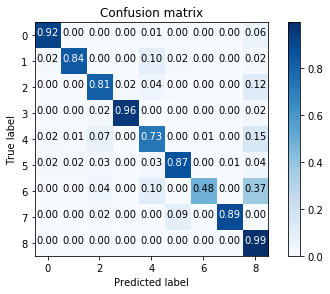

In [29]:
plot_confusion_matrix((cm_dict[50000]['model6']),normalize=True)
plt.savefig('cm_162946.png',dpi=300)

In [46]:
import csv
ts_list = [500,5000,50000,162946]
f_list = []
f = open('result1.csv', 'r', encoding='UTF8')
rdr = csv.reader(f)
for line in rdr:
    f_list.append(line)
f.close()
f_list[0][0] = f_list[0][0][1:]
f_list = np.array(f_list, dtype=float)

In [47]:
f_list[:,0]

array([0.56, 0.7 , 0.84, 0.86, 0.94, 0.96, 0.97, 0.97])

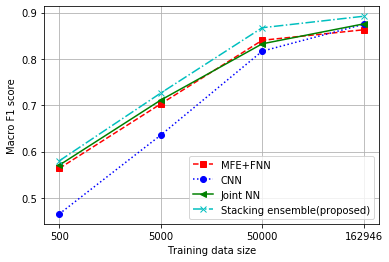

In [50]:
plt.plot(f_list[:4,0],'rs--', label='MFE+FNN')
plt.plot(f_list[:4,1],'bo:', label='CNN')
plt.plot(f_list[:4,2],'g<-', label='Joint NN')
plt.plot(f_list[:4,3],'cx-.', label='Stacking ensemble(proposed)')
plt.xticks(np.arange(4),['500','5000','50000','162946'])
plt.ylabel('Macro F1 score')
plt.xlabel('Training data size')
plt.legend(loc=4)
plt.grid()
plt.savefig('macrof1.png',dpi=300)

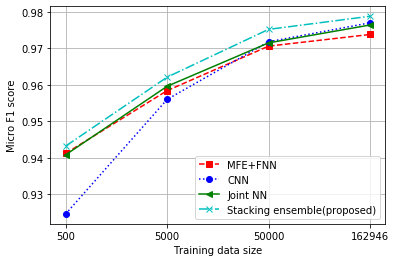

In [51]:
plt.plot(f_list[4:,0],'rs--', label='MFE+FNN')
plt.plot(f_list[4:,1],'bo:', label='CNN')
plt.plot(f_list[4:,2],'g<-', label='Joint NN')
plt.plot(f_list[4:,3],'cx-.', label='Stacking ensemble(proposed)')
plt.xticks(np.arange(4),['500','5000','50000','162946'])
plt.ylabel('Micro F1 score')
plt.xlabel('Training data size')
plt.legend(loc=4)
plt.grid()
plt.savefig('microf1.png',dpi=300)

In [58]:
data_size_list = [500,5000,50000,162946]
bar_width = 0.3
pattern_list = ['Center', 'Donut', 'Edge-loc', 'Edge-ring','Local','Random','Scratch','Near-full','None']
for data_size in data_size_list:
    coeff_sum = coeff_dict[data_size][9]
    for i in range(9):
        coeff_sum = np.add(coeff_sum, coeff_dict[data_size][i])
    coeff_mean = np.divide(coeff_sum,10)
    coeff = np.array(coeff_mean)
    co_list = []
    for k in range(9):
        co_list.append(coeff[k][k])
        co_list.append(coeff[k][k+9])
    plt.bar(pattern_list, co_list[9:],bar_width, color='b',hatch='/',edgecolor='black',label='MFE+FNN')
    plt.bar(np.arange(9)+bar_width, co_list[:9],bar_width, color='r',hatch='',edgecolor='black', label='CNN')
    plt.legend()
    plt.xticks(np.arange(9)+bar_width/2,rotation=-20)
    plt.xlabel('Defect Class')
    plt.ylabel('Linear Coefficient')
    plt.title('Training data size:'+ str(data_size))
    plt.savefig('coeff'+str(data_size)+'.png', bbox_inches='tight')
    plt.close()

50000


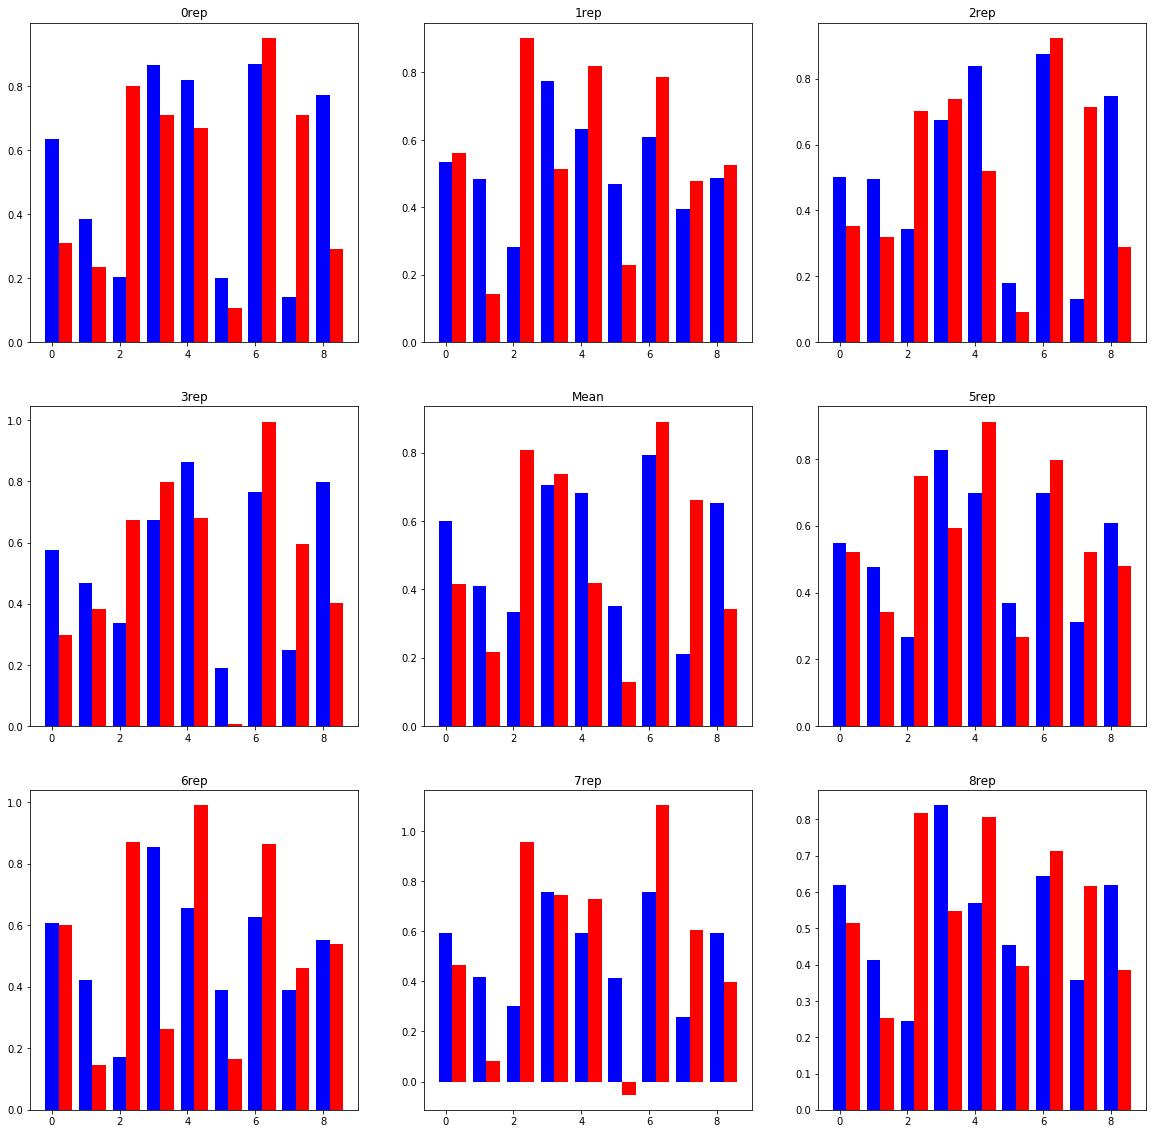

In [59]:
    data_size = 50000
    fig, ax = plt.subplots(nrows = 3, ncols = 3, figsize=(20, 20))
    ax = ax.ravel(order='C')
    for rep in range(9):
        if rep != 4:
            coeff = np.array(coeff_dict[data_size])[rep]
            co_list = []
            for k in range(9):
                co_list.append(coeff[k][k])
                co_list.append(coeff[k][k+9])

            bar_width = 0.4
            ax[rep].bar(np.arange(9), co_list[:9],bar_width, color='b')
            ax[rep].bar(np.arange(9)+bar_width, co_list[9:],bar_width, color='r')
            ax[rep].title.set_text(str(rep)+'rep')
        else:
            
            coeff = np.array(coeff_mean)
            co_list = []
            for k in range(9):
                co_list.append(coeff[k][k])
                co_list.append(coeff[k][k+9])

            bar_width = 0.4
            ax[rep].bar(np.arange(9), co_list[:9],bar_width, color='b')
            ax[rep].bar(np.arange(9)+bar_width, co_list[9:],bar_width, color='r')
            ax[rep].title.set_text('Mean')
            
    print(data_size)
    plt.show()
    

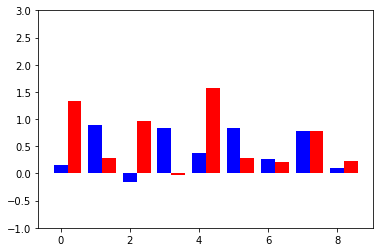

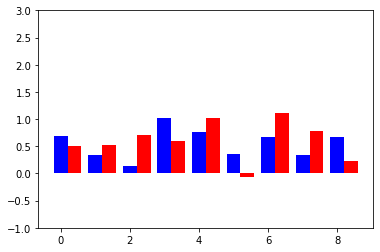

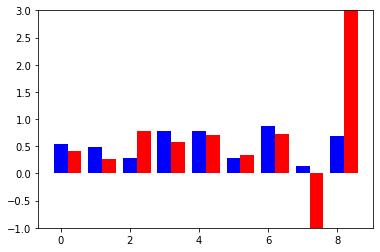

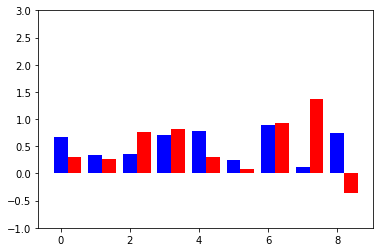

In [163]:
for data_size in data_size_list:
    coeff_sum = coeff_dict[data_size][9]
    for i in range(9):
        coeff_sum = np.add(coeff_sum, coeff_dict[data_size][i])
    coeff = np.divide(coeff_sum,10)
    co_list = []
    for k in range(9):
        co_list.append(coeff[k][k])
        co_list.append(coeff[k][k+9])
    r,c = rep % 3 , (rep- r) // 3

    bar_width = 0.4
    plt.bar(np.arange(9), co_list[:9],bar_width, color='b')
    plt.bar(np.arange(9)+bar_width, co_list[9:],bar_width, color='r')
    plt.ylim(-1,3)
    plt.show()